# Experiment 1: GPT-2 on wikitext but scaled down


In [6]:
# Install required packages (run once)
!pip install -q transformers datasets accelerate evaluate sentencepiece

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.9 MB/s eta 0:00:00


In [7]:
# Imports
import math, time, os, random
from collections import Counter, defaultdict
from functools import partial
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import GPT2TokenizerFast, GPT2LMHeadModel, get_linear_schedule_with_warmup
from datasets import load_dataset
from IPython.display import clear_output, display
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# Config (tune these for Colab convenience)
block_size = 128          # sequence length per example
train_examples = 20000    # number of blocks to use (small proxy). Increase to scale up.
batch_size = 8            # small batch for Colab GPU
groups = 10               # number of frequency groups (≈10%)

# Load tokenizer & dataset
tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')
# ensure eos/pad tokens
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '<|pad|>'})

ds = load_dataset('wikitext', 'wikitext-103-raw-v1', split='train')

# Concatenate texts and tokenize into a single long stream of tokens
def all_tokens(example):
    return tokenizer(example['text'])['input_ids']

# convert to token stream (this can be memory heavy for whole dataset; using subset)
texts = ds['text'][:5000]  # use first 5000 raw docs for proxy; increase for larger runs
tok_stream = []
for t in texts:
    if t is None or t.strip()=='':
        continue
    tok_stream.extend(tokenizer.encode(t))

# turn into blocks of block_size
input_ids = []
for i in range(0, len(tok_stream) - block_size, block_size):
    block = tok_stream[i:i+block_size]
    input_ids.append(block)
input_ids = input_ids[:train_examples]  # limit number of training examples for Colab
print("Prepared blocks:", len(input_ids))

# compute token frequency across all tokens used
flat = [tid for block in input_ids for tid in block]
freq = Counter(flat)
vocab_size = tokenizer.vocab_size
print("Vocab size (tokenizer):", vocab_size)
print("Unique tokens observed in sample:", len(freq))

# create groups of tokens by frequency such that each group covers ~10% of total tokens
# sort tokens by frequency descending
token_freq_pairs = sorted(freq.items(), key=lambda x: x[1], reverse=True)
total_tokens = sum(freq.values())
group_target = total_tokens / groups

groups_list = []
cur_group = set()
cur_sum = 0
for tok, c in token_freq_pairs:
    cur_group.add(tok)
    cur_sum += c
    if cur_sum >= group_target:
        groups_list.append(cur_group)
        cur_group = set()
        cur_sum = 0
# append remaining
if cur_group:
    groups_list.append(cur_group)
# if not enough groups due to few unique tokens, pad
while len(groups_list) < groups:
    groups_list.append(set())

print("Number of groups:", len(groups_list))
# create token->group map
tok2group = {}
for gi, s in enumerate(groups_list):
    for tok in s:
        tok2group[tok] = gi
# tokens not observed -> assign to last group
for t in range(vocab_size):
    if t not in tok2group:
        tok2group[t] = groups-1

# helper to compute per-group loss from token-level losses
def accumulate_group_losses(token_ids, token_losses):
    # token_ids: (B, L) list or numpy; token_losses: same shape
    group_losses = np.zeros(groups)
    group_counts = np.zeros(groups)
    for tid_row, loss_row in zip(token_ids, token_losses):
        for tid, ls in zip(tid_row, loss_row):
            g = tok2group.get(int(tid), groups-1)
            group_losses[g] += float(ls)
            group_counts[g] += 1
    # avoid div by zero
    group_avg = group_losses / np.maximum(group_counts, 1)
    return group_avg, group_counts


Device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

wikitext-103-raw-v1/test-00000-of-00001.(…):   0%|          | 0.00/733k [00:00<?, ?B/s]

wikitext-103-raw-v1/train-00000-of-00002(…):   0%|          | 0.00/157M [00:00<?, ?B/s]

wikitext-103-raw-v1/train-00001-of-00002(…):   0%|          | 0.00/157M [00:00<?, ?B/s]

wikitext-103-raw-v1/validation-00000-of-(…):   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/1801350 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

Prepared blocks: 2464
Vocab size (tokenizer): 50257
Unique tokens observed in sample: 21088
Number of groups: 10


In [ ]:
class BlockDataset(Dataset):
    def __init__(self, blocks):
        self.blocks = blocks
    def __len__(self):
        return len(self.blocks)
    def __getitem__(self, idx):
        ids = torch.tensor(self.blocks[idx], dtype=torch.long)
        return ids

train_dataset = BlockDataset(input_ids)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# small eval set (a held-out slice)
eval_blocks = input_ids[-1000:]
eval_dataset = BlockDataset(eval_blocks)
eval_loader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False)

# training step function
def run_experiment(optimizer_name='adam', lr=1e-4, epochs=1, log_steps=200):
    torch.manual_seed(42)
    model = GPT2LMHeadModel.from_pretrained('gpt2')
    model.resize_token_embeddings(len(tokenizer))  # in case we added pad token
    model.to(device)
    model.train()
    # optimizer choice
    if optimizer_name.lower() == 'sgd':
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    elif optimizer_name.lower() == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    else:
        raise ValueError(optimizer_name)
    total_steps = epochs * len(train_loader)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
    global_step = 0

    # logs
    overall_losses = []
    group_losses_history = []  # list of arrays per log point
    steps_history = []

    # training
    for ep in range(epochs):
        for batch in train_loader:
            batch = batch.to(device)  # shape (B, L)
            inputs = batch
            labels = batch.clone()
            outputs = model(input_ids=inputs, labels=labels)
            # outputs.loss is averaged over tokens in batch; we want per-token losses
            # compute per-token loss manually from logits
            logits = outputs.logits  # B x L x V
            shift_logits = logits[:, :-1, :].contiguous()
            shift_labels = labels[:, 1:].contiguous()
            # flatten
            loss_fct = torch.nn.CrossEntropyLoss(reduction='none')
            B, Lm = shift_labels.shape
            loss_flat = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
            per_token_loss = loss_flat.view(B, Lm).detach().cpu().numpy()
            # backprop using the averaged loss
            loss = outputs.loss
            optimizer.zero_grad()
            loss.backward()
            # optional grad clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            global_step += 1

            # periodic eval on a small held-out set to compute group losses
            if global_step % log_steps == 0 or global_step == 1:
                model.eval()
                # compute overall loss on small eval dataset and group losses
                all_token_ids = []
                all_token_losses = []
                with torch.no_grad():
                    eval_loss_accum = 0.0
                    eval_tokens = 0
                    for ebatch in eval_loader:
                        ebatch = ebatch.to(device)
                        labels_e = ebatch.clone()
                        out = model(input_ids=ebatch, labels=labels_e)
                        logits_e = out.logits
                        shift_logits_e = logits_e[:, :-1, :].contiguous()
                        shift_labels_e = labels_e[:, 1:].contiguous()
                        loss_flat_e = loss_fct(shift_logits_e.view(-1, shift_logits_e.size(-1)), shift_labels_e.view(-1))
                        per_token_loss_e = loss_flat_e.view(shift_labels_e.size(0), shift_labels_e.size(1)).cpu().numpy()
                        all_token_losses.append(per_token_loss_e)
                        all_token_ids.append(shift_labels_e.cpu().numpy())
                        eval_loss_accum += per_token_loss_e.sum()
                        eval_tokens += per_token_loss_e.size
                    # concatenate
                    all_token_losses = np.concatenate(all_token_losses, axis=0)
                    all_token_ids = np.concatenate(all_token_ids, axis=0)
                    avg_eval_loss = eval_loss_accum / eval_tokens
                    # compute group-wise averages
                    group_avg, _ = accumulate_group_losses(all_token_ids, all_token_losses)
                overall_losses.append(avg_eval_loss)
                group_losses_history.append(group_avg.copy())
                steps_history.append(global_step)
                model.train()

    return {
        'model': model,
        'overall_losses': np.array(overall_losses),
        'group_losses_history': np.stack(group_losses_history) if group_losses_history else np.zeros((0, groups)),
        'steps': np.array(steps_history)
    }


In [11]:
# ---------- New optimizers for language-model experiment ----------
import math
from torch.optim import Optimizer

# ------------------------------ Preconditioners ------------------------------
class Preconditioner:
    def prec(self, x): return x

import torch

class Clip(Preconditioner):
    """Elementwise hard clipping to [-1, 1]. Safe and bounded."""
    def prec(self, x):
        return torch.clamp(x, min=-1.0, max=1.0)

class Cosh(Preconditioner):
    """
    'Cosh' preconditioner: use a soft inverse-like transform.
    We use asinh(x) (inverse hyperbolic sine) as a smooth, odd transform that
    behaves like x for small values and like sign(x) * log(2|x|) for large values.
    This compresses large components instead of amplifying them.
    """
    def prec(self, x):
        return torch.asinh(x)   # numerically stable for all real x

class Exp(Preconditioner):
    """
    'Exp' (soft-exp) preconditioner: *not* raw exp(x) (would explode).
    Instead use sign(x) * log1p(|x|) which grows logarithmically for large |x|.
    This gives a soft, odd transform that compresses large gradients:
        prec(x) = sign(x) * log(1 + |x|)
    """
    def prec(self, x):
        return torch.sign(x) * torch.log1p(torch.abs(x))

class NegLog(Preconditioner):
    """
    'NegLog' preconditioner: a bounded, saturating transform.
    Implemented as x / (1 + |x|) which is odd, bounded in (-1,1), and
    behaves linearly near zero:
        prec(x) = x / (1 + |x|)
    This is numerically safe for all x.
    """
    def prec(self, x):
        return x / (1.0 + torch.abs(x))

class Identity(Preconditioner):
    """No preconditioning — returns the gradient as-is."""
    def prec(self, x):
        return x
class PrecGD(Optimizer):
    """
    Preconditioned GD optimizer (works with whole model parameters).
    Modes:
      - 'clip' : per-element clamp to [-clip_val, clip_val]
      - 'cosh' : per-element asinh(grad) (soft compression)
      - 's'    : alias for 'cosh' (sHGD)
      - 'i'    : isotropic scaling: scale = asinh(global_norm)/global_norm (iHGD)
    Supports heavy-ball style momentum (beta in [0,1)): m_k = beta*m_{k-1} + (1-beta)*pre
    NOTE: This optimizer updates parameters directly (no lr schedules inside).
    """
    def __init__(self, params, mode='cosh', lr=1e-3, momentum=0.0, clip_val=1.0):
        if lr:
          if lr <= 0.0:
              raise ValueError("lr must be > 0")
        if not (0.0 <= momentum < 1.0):
            raise ValueError("momentum must be in [0,1)")
        defaults = dict(lr=lr, momentum=momentum, mode=mode, clip_val=clip_val)
        super().__init__(params, defaults)
        self.mode = mode
        self.clip_val = clip_val
        # placeholder for iHGD scale computed each step
        self._global_scale = 1.0

    def _compute_global_grad_norm(self):
        total = 0.0
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                g = p.grad.data
                total += float((g.float() ** 2).sum().item())
        return math.sqrt(total)

    def step(self, closure=None):
        """Performs a single optimization step."""
        loss = None
        if closure is not None:
            loss = closure()

        # compute isotropic scale if needed
        if self.mode == 'i':
            total_norm = self._compute_global_grad_norm()
            eps = 1e-12
            self._global_scale = math.asinh(total_norm) / (total_norm + eps)

        for group in self.param_groups:
            lr = group['lr']
            beta = group.get('momentum', 0.0)
            mode = group.get('mode', self.mode)
            clip_val = group.get('clip_val', self.clip_val)

            for p in group['params']:
                if p.grad is None:
                    continue
                g = p.grad.data

                # compute preconditioned gradient (pre)
                if mode == 'clip':
                    pre = torch.clamp(g, min=-clip_val, max=clip_val)
                elif mode in ('cosh', 's'):
                    # elementwise asinh
                    pre = torch.asinh(g)
                elif mode == 'i':
                    pre = g.mul(self._global_scale)
                else:
                    # default: raw grad
                    pre = g

                # heavy-ball momentum buffer: m_k = beta*m_{k-1} + (1-beta)*pre
                state = self.state[p]
                if 'momentum_buffer' not in state:
                    state['momentum_buffer'] = torch.zeros_like(pre)
                m_buf = state['momentum_buffer']
                if beta > 0.0:
                    m_buf.mul_(beta).add_(pre, alpha=(1.0 - beta))
                    update = m_buf
                else:
                    update = pre

                p.data.add_(update, alpha=-lr)

        return loss
class PrecGDSepAdam(Optimizer):
    """
    Separable Adam-style preconditioning with pluggable second-moment transform.

    Options for v_transform:
      - 'square'     : standard Adam, psi(g) = g^2
      - 'cosh'       : psi(g) = cosh(scale * g) - 1
      - 'asinh_sq'   : psi(g) = asinh(g)^2
      - 'log1p_sq'   : psi(g) = log1p(g^2)
      - 'abs'        : psi(g) = |g|
      - callable     : a function psi(tensor) -> tensor

    The update still computes scaled = m_hat / (sqrt(v_hat) + eps),
    then delta = prec.prec(lamb * scaled) elementwise, and p -= lr * delta.
    """
    def __init__(self, params, prec,
                 lr=1e-3, lamb=1.0,
                 betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=0.0, bias_correction=True,
                 v_transform='square', v_scale=1.0):
        if lr <= 0.0:
            raise ValueError("Invalid lr")
        defaults = dict(lr=lr, lamb=lamb, betas=betas, eps=eps,
                        weight_decay=weight_decay, bias_correction=bias_correction,
                        v_transform=v_transform, v_scale=v_scale)
        super().__init__(params, defaults)
        self.prec = prec
        self._step = 0

        # map standard names to functions (callable expects tensor input)
        def _psi_square(g, scale=1.0):
            return (g * scale) ** 2

        def _psi_cosh(g, scale=1.0):
            # cosh(scale * g) - 1 ; subtract 1 so psi(0)=0
            return torch.cosh(g * scale) - 1.0

        def _psi_asinh_sq(g, scale=1.0):
            return torch.asinh(g * scale) ** 2

        def _psi_log1p_sq(g, scale=1.0):
            return torch.log1p((g * scale) ** 2)

        def _psi_abs(g, scale=1.0):
            return torch.abs(g * scale)

        self._builtin_psi = {
            'square': _psi_square,
            'cosh': _psi_cosh,
            'asinh_sq': _psi_asinh_sq,
            'log1p_sq': _psi_log1p_sq,
            'abs': _psi_abs
        }

    def _apply_psi(self, psi_spec, g, scale):
        """Return psi(g) given psi_spec (name or callable) and scale."""
        if callable(psi_spec):
            return psi_spec(g, scale) if _callable_accepts_scale(psi_spec) else psi_spec(g)
        if isinstance(psi_spec, str):
            fn = self._builtin_psi.get(psi_spec)
            if fn is None:
                raise ValueError(f"Unknown v_transform '{psi_spec}'")
            return fn(g, scale)
        raise ValueError("v_transform must be str or callable")

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()
        self._step += 1

        for group in self.param_groups:
            lr = group['lr']
            lamb = group['lamb']
            beta1, beta2 = group['betas']
            eps = group['eps']
            wd = group['weight_decay']
            bias_corr = group['bias_correction']
            psi_spec = group.get('v_transform', 'square')
            psi_scale = float(group.get('v_scale', 1.0))

            for p in group['params']:
                if p.grad is None:
                    continue
                g = p.grad.data
                # apply weight decay in Adam style if requested (decoupled or not? here we simply add)
                if wd != 0:
                    g = g.add(p.data, alpha=wd)

                state = self.state.setdefault(p, {})
                if 'm' not in state:
                    state['m'] = torch.zeros_like(p.data)
                    state['v'] = torch.zeros_like(p.data)

                m = state['m']
                v = state['v']

                # first moment
                m.mul_(beta1).add_(g, alpha=(1 - beta1))

                # second moment uses psi transform instead of g^2
                try:
                    psi_val = self._apply_psi(psi_spec, g, psi_scale)
                except Exception as e:
                    # fallback: if psi is weird, fall back to square
                    psi_val = g * g

                # ensure psi_val is same device/shape
                if not isinstance(psi_val, torch.Tensor) or psi_val.shape != g.shape:
                    psi_val = torch.as_tensor(psi_val, device=g.device, dtype=g.dtype).view_as(g)

                v.mul_(beta2).add_(psi_val, alpha=(1 - beta2))

                # bias correction
                if bias_corr:
                    bc1 = 1 - beta1 ** self._step
                    bc2 = 1 - beta2 ** self._step
                    # avoid divide-by-zero in early steps
                    m_hat = m / (bc1 + 1e-16)
                    v_hat = v / (bc2 + 1e-16)
                else:
                    m_hat = m
                    v_hat = v

                # ensure non-negativity and stability of v_hat (some psi could produce tiny negatives numerically)
                # clamp minimum to small positive
                v_hat = v_hat.clamp(min=1e-30)

                denom = v_hat.sqrt().add(eps)
                scaled = m_hat / denom

                # elementwise preconditioner application
                try:
                    delta = self.prec.prec(lamb * scaled)
                except Exception:
                    # fallback to elementwise scalar application (slower)
                    flat = scaled.view(-1)
                    vals = [self.prec.prec(float(x)) for x in flat]
                    delta = torch.tensor(vals, device=scaled.device, dtype=scaled.dtype).view_as(scaled)

                p.data.add_(delta, alpha=-lr)

        return loss
# ---------- helper factories for common defaults ----------
def make_precgd_for_model(model, name='cosh', lr=None, momentum=0.0, clip_val=1.0):
    """
    name: 'clip', 'cosh', 's', 'i', or momentum variants by passing momentum>0
    lr: learning rate (if None, choose sensible default relative to typical LM LR)
    """
    # Choose sensible default LR if None; match scale of your base experiment (1e-4 baseline)
    # These defaults follow the earlier guideline: iHGD can often use larger LR; cosh/clip slightly larger.
    if lr is None:
        if name == 'clip':
            lr = 2e-4      # slightly larger than base 1e-4
        elif name in ('cosh', 's'):
            lr = 2e-4      # slightly larger
        elif name == 'i':
            lr = 5e-4      # larger, isotropic compresses strongly so a bigger lr is okay
        else:
            lr = 1e-4
    params = model.parameters()
    return PrecGD(params, mode=name, lr=lr, momentum=momentum, clip_val=clip_val)

# ---------------------------
# Replace optimizer selection in run_experiment
# ---------------------------
# Copy the body of your original run_experiment but replace the optimizer choice section
# with the block below. Alternatively, replace the entire function with the updated one below.

def run_experiment(optimizer_name='adam', lr=1e-4, epochs=1, log_steps=200):
    torch.manual_seed(42)
    model = GPT2LMHeadModel.from_pretrained('gpt2')
    model.resize_token_embeddings(len(tokenizer))  # in case we added pad token
    model.to(device)
    model.train()

    opt_low = optimizer_name.lower()
    # --- optimizer selection (supports new methods) ---
    if opt_low == 'sgd':
        chosen_lr = lr if lr is not None else 2e-5
        optimizer = torch.optim.SGD(model.parameters(), lr=chosen_lr)
    elif opt_low == 'adam':
        chosen_lr = lr if lr is not None else 2e-5
        optimizer = torch.optim.Adam(model.parameters(), lr=chosen_lr)
    elif opt_low == 'clip':
        # clip-based preconditioner; use slightly larger lr default if user passed None
        chosen_lr = lr if lr is not None else 2e-5
        optimizer = make_precgd_for_model(model, name='clip', lr=chosen_lr, momentum=0.0, clip_val=1.0)
    elif opt_low == 'cosh':
        chosen_lr = lr if lr is not None else 2e-5
        optimizer = make_precgd_for_model(model, name='cosh', lr=chosen_lr, momentum=0.0)
    elif opt_low == 'shgd':
        chosen_lr = lr if lr is not None else 2e-5
        optimizer = make_precgd_for_model(model, name='s', lr=chosen_lr, momentum=0.0)
    elif opt_low == 'shgdm':
        chosen_lr = lr if lr is not None else 2e-5
        optimizer = make_precgd_for_model(model, name='s', lr=chosen_lr, momentum=0.9)
    elif opt_low == 'ihgd':
        chosen_lr = lr if lr is not None else 2e-5
        optimizer = make_precgd_for_model(model, name='i', lr=chosen_lr, momentum=0.0)
    elif opt_low == 'ihgdm':
        chosen_lr = lr if lr is not None else 2e-5
        optimizer = make_precgd_for_model(model, name='i', lr=chosen_lr, momentum=0.9)
    elif opt_low == 'sepadam_clip_coshv':
        optimizer = PrecGDSepAdam(
            model.parameters(),
            prec=Clip(),
            lr=1e-3 if lr is None else lr,
            lamb=1.0,
            betas=(0.9, 0.999),
            v_transform='cosh',
            v_scale=0.5
        )
    else:
        raise ValueError(f"Unknown optimizer: {optimizer_name}")

    total_steps = epochs * len(train_loader)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
    global_step = 0

    # logs
    overall_losses = []
    group_losses_history = []  # list of arrays per log point
    steps_history = []

    # training
    for ep in range(epochs):
        for batch in train_loader:
            batch = batch.to(device)  # shape (B, L)
            inputs = batch
            labels = batch.clone()
            outputs = model(input_ids=inputs, labels=labels)
            # outputs.loss is averaged over tokens in batch; we want per-token losses
            logits = outputs.logits  # B x L x V
            shift_logits = logits[:, :-1, :].contiguous()
            shift_labels = labels[:, 1:].contiguous()
            # flatten
            loss_fct = torch.nn.CrossEntropyLoss(reduction='none')
            B, Lm = shift_labels.shape
            loss_flat = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
            per_token_loss = loss_flat.view(B, Lm).detach().cpu().numpy()
            # backprop using the averaged loss
            loss = outputs.loss
            optimizer.zero_grad()
            loss.backward()
            # optional grad clipping for stability (still useful)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            global_step += 1

            # periodic eval on a small held-out set to compute group losses
            if global_step % log_steps == 0 or global_step == 1:
                model.eval()
                # compute overall loss on small eval dataset and group losses
                all_token_ids = []
                all_token_losses = []
                with torch.no_grad():
                    eval_loss_accum = 0.0
                    eval_tokens = 0
                    for ebatch in eval_loader:
                        ebatch = ebatch.to(device)
                        labels_e = ebatch.clone()
                        out = model(input_ids=ebatch, labels=labels_e)
                        logits_e = out.logits
                        shift_logits_e = logits_e[:, :-1, :].contiguous()
                        shift_labels_e = labels_e[:, 1:].contiguous()
                        loss_flat_e = loss_fct(shift_logits_e.view(-1, shift_logits_e.size(-1)), shift_labels_e.view(-1))
                        per_token_loss_e = loss_flat_e.view(shift_labels_e.size(0), shift_labels_e.size(1)).cpu().numpy()
                        all_token_losses.append(per_token_loss_e)
                        all_token_ids.append(shift_labels_e.cpu().numpy())
                        eval_loss_accum += per_token_loss_e.sum()
                        eval_tokens += per_token_loss_e.size
                    # concatenate
                    all_token_losses = np.concatenate(all_token_losses, axis=0)
                    all_token_ids = np.concatenate(all_token_ids, axis=0)
                    avg_eval_loss = eval_loss_accum / eval_tokens
                    # compute group-wise averages (assumes accumulate_group_losses is defined)
                    group_avg, _ = accumulate_group_losses(all_token_ids, all_token_losses)
                overall_losses.append(avg_eval_loss)
                group_losses_history.append(group_avg.copy())
                steps_history.append(global_step)
                model.train()

    return {
        'model': model,
        'overall_losses': np.array(overall_losses),
        'group_losses_history': np.stack(group_losses_history) if group_losses_history else np.zeros((0, groups)),
        'steps': np.array(steps_history)
    }


In [ ]:
# SMALL quick runs — set epochs=1 for quick proxy; increase to get stronger signal
print("Running SGD (proxy)...")
res_sgd = run_experiment(optimizer_name='sgd', lr=1e-3, epochs=1, log_steps=10)

print("Running Adam (proxy)...")
res_adam = run_experiment(optimizer_name='adam', lr=1e-4, epochs=1, log_steps=10)

Running SGD (proxy)...
Running Adam (proxy)...


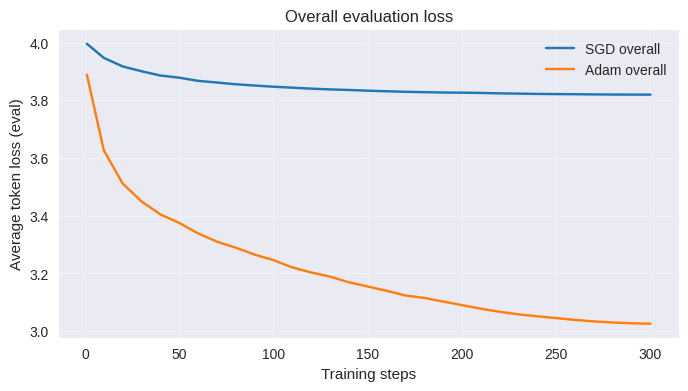

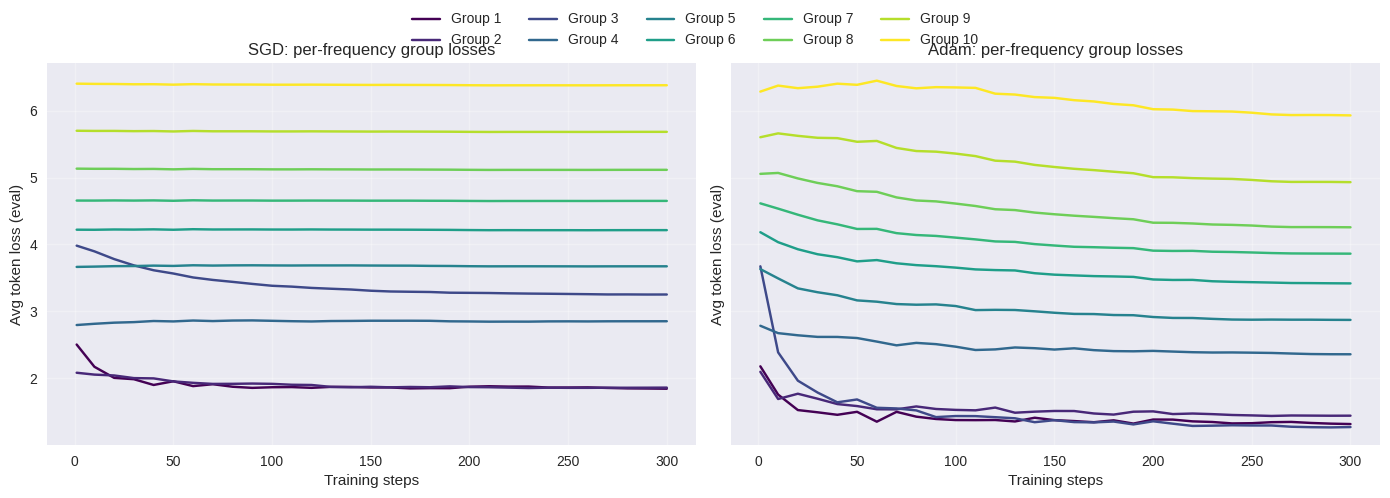

In [ ]:
def plot_results(res_sgd, res_adam, groups=10, cmap_name='viridis'):
    cmap = plt.get_cmap(cmap_name, groups)
    colors = [cmap(i) for i in range(groups)]

    # --- overall loss ---
    plt.figure(figsize=(8, 4))
    plt.plot(res_sgd['steps'], res_sgd['overall_losses'], label='SGD overall', color='tab:blue')
    plt.plot(res_adam['steps'], res_adam['overall_losses'], label='Adam overall', color='tab:orange')
    plt.xlabel('Training steps')
    plt.ylabel('Average token loss (eval)')
    plt.title('Overall evaluation loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # --- per-group losses ---
    fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
    for gi in range(groups):
        axs[0].plot(res_sgd['steps'], res_sgd['group_losses_history'][:, gi],
                    color=colors[gi], label=f'Group {gi+1}')
        axs[1].plot(res_adam['steps'], res_adam['group_losses_history'][:, gi],
                    color=colors[gi], label=f'Group {gi+1}')

    axs[0].set_title('SGD: per-frequency group losses')
    axs[1].set_title('Adam: per-frequency group losses')
    for ax in axs:
        ax.set_xlabel('Training steps')
        ax.set_ylabel('Avg token loss (eval)')
        ax.grid(True, alpha=0.3)
    # one shared legend
    handles, labels = axs[1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=groups//2)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

plot_results(res_sgd, res_adam)



=== Running optimizer: sepadam_clip_coshv ===


`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


-> Done sepadam_clip_coshv: saved 39 eval points, time elapsed 946.0s

=== Running optimizer: sgd ===
-> Done sgd: saved 39 eval points, time elapsed 1780.5s

=== Running optimizer: adam ===
-> Done adam: saved 39 eval points, time elapsed 2657.8s

All experiments finished (total time 2657.8s).


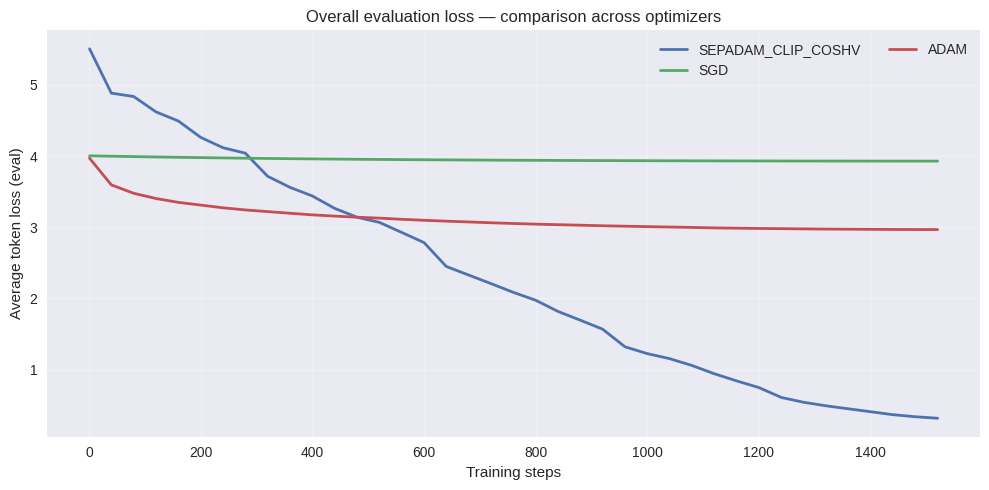

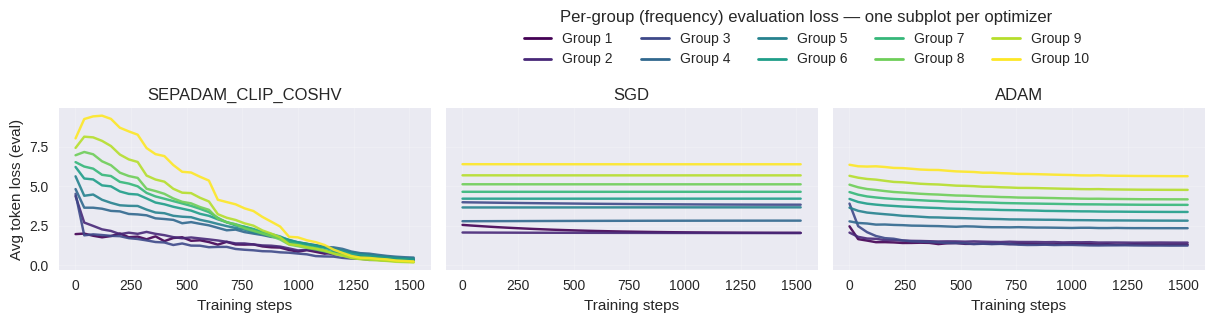

Saved all_results to lm_experiment_results.pkl


In [12]:
class BlockDataset(Dataset):
    def __init__(self, blocks):
        self.blocks = blocks
    def __len__(self):
        return len(self.blocks)
    def __getitem__(self, idx):
        ids = torch.tensor(self.blocks[idx], dtype=torch.long)
        return ids

train_dataset = BlockDataset(input_ids)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# small eval set (a held-out slice)
eval_blocks = input_ids[-1000:]
eval_dataset = BlockDataset(eval_blocks)
eval_loader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False)

# -----------------------
# Run experiments for all optimizers and plot results
# Paste this cell after your run_experiment definition.
# -----------------------

import time
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Choose which optimizers to run (must be supported by your run_experiment)
opt_list = ['sepadam_clip_coshv','sgd','adam']

# You can override lr or pass None to use the function's sensible defaults.
default_lr = None

# Safety: reduce epochs for quick debugging. Set to your desired value.
# (If you want the full runs, keep the epochs value you set inside run_experiment call.)
run_epochs = 5   # change to >1 for full runs (e.g., 1 -> quick smoke test)

all_results = {}
t0 = time.time()
for opt in opt_list:
    print(f"\n=== Running optimizer: {opt} ===")
    # run_experiment should accept optimizer_name and lr; it uses sensible defaults when lr is None
    res = run_experiment(optimizer_name=opt, lr=default_lr, epochs=run_epochs, log_steps=40)
    all_results[opt] = res
    print(f"-> Done {opt}: saved {len(res['overall_losses'])} eval points, time elapsed {time.time()-t0:.1f}s")

print(f"\nAll experiments finished (total time {time.time()-t0:.1f}s).")

# -----------------------
# Plot overall eval loss for all optimizers (clear legend)
# -----------------------
plt.figure(figsize=(10,5))
for opt in opt_list:
    res = all_results[opt]
    steps = res['steps']
    vals = res['overall_losses']
    if len(steps)==0 or len(vals)==0:
        continue
    plt.plot(steps, vals, label=opt.upper(), linewidth=2)
plt.xlabel('Training steps')
plt.ylabel('Average token loss (eval)')
plt.title('Overall evaluation loss — comparison across optimizers')
plt.legend(ncol=2, loc='upper right')
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()

# -----------------------
# Per-group plotting: one subplot per optimizer (2 rows x ceil(len/2) cols)
# -----------------------
groups = 10  # keep consistent with accumulate_group_losses earlier
cmap = plt.get_cmap('viridis', groups)
colors = [cmap(i) for i in range(groups)]

n_opts = len(opt_list)
ncols = 4
nrows = (n_opts + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows), sharex=True, sharey=True)
axes = axes.flatten()

for ax_idx, opt in enumerate(opt_list):
    ax = axes[ax_idx]
    res = all_results[opt]
    steps = res['steps']
    group_hist = res['group_losses_history']  # shape (T, groups)
    if group_hist is None or group_hist.shape[0] == 0:
        ax.text(0.5, 0.5, 'no eval points', ha='center', va='center')
        ax.set_title(opt.upper())
        continue
    # plot each group
    for g in range(groups):
        y = group_hist[:, g]
        ax.plot(steps, y, color=colors[g], alpha=0.9, label=f'G{g+1}' if ax_idx==0 else None)
    ax.set_title(opt.upper())
    ax.grid(alpha=0.2)
    if ax_idx % ncols == 0:
        ax.set_ylabel('Avg token loss (eval)')
    if ax_idx >= (nrows-1)*ncols:
        ax.set_xlabel('Training steps')

# hide extra axes if any
for i in range(len(opt_list), nrows*ncols):
    fig.delaxes(axes[i])

# shared legend for groups (place at top)
handles = [Line2D([0],[0], color=colors[g], lw=2) for g in range(groups)]
labels = [f'Group {g+1}' for g in range(groups)]
fig.legend(handles, labels, loc='upper center', ncol=groups//2, bbox_to_anchor=(0.5, 1.03))
fig.suptitle('Per-group (frequency) evaluation loss — one subplot per optimizer', y=1.06)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

# -----------------------
# Optional: Save results to disk (pickle) for later plotting/analysis
# -----------------------
import pickle
with open('lm_experiment_results.pkl', 'wb') as f:
    pickle.dump(all_results, f)
print("Saved all_results to lm_experiment_results.pkl")

# -----------------------
# Tip:
# - If this run is too slow, set run_epochs=1 above (quick smoke test).
# - For full experiments, increase run_epochs and consider increasing log_steps to reduce eval frequency.
# -----------------------


# Experiment 2: Resnet-18 on Imagenette with 10 classes



In [ ]:
!pip install -q torch torchvision torchaudio tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset, WeightedRandomSampler
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)


Device: cuda


In [ ]:
!wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz
!tar -xzf imagenette2-160.tgz

data_dir = "imagenette2-160/train"

# Standard ResNet transforms
train_transforms = transforms.Compose([
    transforms.Resize(160),
    transforms.RandomResizedCrop(160),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

train_dataset = datasets.ImageFolder(root=data_dir, transform=train_transforms)
num_classes = len(train_dataset.classes)
print("Number of classes:", num_classes)


--2025-10-08 11:44:55--  https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.232.88, 52.216.8.5, 52.217.108.134, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.232.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99003388 (94M) [application/x-tar]
Saving to: ‘imagenette2-160.tgz’

imagenette2-160.tgz 100%[===================>]  94.42M  41.0MB/s    in 2.3s    

2025-10-08 11:44:58 (41.0 MB/s) - ‘imagenette2-160.tgz’ saved [99003388/99003388]

Number of classes: 10


In [ ]:
# Compute per-class sample indices
class_indices = [[] for _ in range(num_classes)]
for idx, (_, label) in enumerate(train_dataset.samples):
    class_indices[label].append(idx)

# Target number of samples per class
total_samples = len(train_dataset)
target_samples = []

# Imbalanced: pi ∝ 1/k (k=1..num_classes)
for k in range(1, num_classes+1):
    target_samples.append(int((1/k) * total_samples / sum(1/np.array(range(1,num_classes+1)))))
print(target_samples)
# Subsample each class
imbalanced_indices = []
for k, num in enumerate(target_samples):
    inds = class_indices[k]
    if num < len(inds):
        sampled = random.sample(inds, num)
    else:
        sampled = inds
    imbalanced_indices.extend(sampled)

# Uniform subset: same total samples
uniform_indices = []
samples_per_class = len(imbalanced_indices) // num_classes
for k in range(num_classes):
    inds = class_indices[k]
    if samples_per_class < len(inds):
        sampled = random.sample(inds, samples_per_class)
    else:
        sampled = inds
    uniform_indices.extend(sampled)

# Subset datasets
from torch.utils.data import Subset
train_dataset_imbalanced = Subset(train_dataset, imbalanced_indices)
train_dataset_uniform = Subset(train_dataset, uniform_indices)

print("Imbalanced samples:", len(train_dataset_imbalanced))
print("Uniform samples:", len(train_dataset_uniform))


[3232, 1616, 1077, 808, 646, 538, 461, 404, 359, 323]
Imbalanced samples: 6450
Uniform samples: 6450


In [ ]:
batch_size = 32

train_loader_imbalanced = DataLoader(train_dataset_imbalanced, batch_size=batch_size, shuffle=True)
train_loader_uniform = DataLoader(train_dataset_uniform, batch_size=batch_size, shuffle=True)


In [ ]:
def get_model(num_classes):
    model = models.resnet18(pretrained=False)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model.to(device)


In [ ]:
def get_optimizer(model, lr=0.01):
    return optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)


In [ ]:
def get_optimizer(model, lr=0.001):
    return optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

In [ ]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    per_class_loss = np.zeros(num_classes)
    per_class_count = np.zeros(num_classes)

    for inputs, labels in tqdm(loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

        # compute per-class loss
        with torch.no_grad():
            probs = nn.functional.cross_entropy(outputs, labels, reduction='none')
            for i, lbl in enumerate(labels):
                per_class_loss[lbl] += probs[i].item()
                per_class_count[lbl] += 1

    overall_loss = running_loss / len(loader.dataset)
    per_class_avg = per_class_loss / np.maximum(per_class_count, 1)
    return overall_loss, per_class_avg


In [ ]:
epochs = 5  # increase for stronger signal, keep small for Colab

# Imbalanced
model_imb = get_model(num_classes)
opt_imb = get_optimizer(model_imb)
criterion = nn.CrossEntropyLoss()
loss_history_imb = []
per_class_history_imb = []

for epoch in range(epochs):
    overall, per_class = train_one_epoch(model_imb, train_loader_imbalanced, opt_imb, criterion)
    print(f"Epoch {epoch+1} | Overall Loss: {overall:.4f}")
    loss_history_imb.append(overall)
    per_class_history_imb.append(per_class)

# Uniform
model_uni = get_model(num_classes)
opt_uni = get_optimizer(model_uni)
loss_history_uni = []
per_class_history_uni = []

for epoch in range(epochs):
    overall, per_class = train_one_epoch(model_uni, train_loader_uniform, opt_uni, criterion)
    print(f"Epoch {epoch+1} | Overall Loss: {overall:.4f}")
    loss_history_uni.append(overall)
    per_class_history_uni.append(per_class)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
100%|██████████| 202/202 [00:22<00:00,  9.11it/s]


Epoch 1 | Overall Loss: 1.9492


100%|██████████| 202/202 [00:21<00:00,  9.45it/s]


Epoch 2 | Overall Loss: 1.6795


100%|██████████| 202/202 [00:21<00:00,  9.39it/s]


Epoch 3 | Overall Loss: 1.5535


100%|██████████| 202/202 [00:21<00:00,  9.37it/s]


Epoch 4 | Overall Loss: 1.4514


100%|██████████| 202/202 [00:21<00:00,  9.33it/s]


Epoch 5 | Overall Loss: 1.3601


100%|██████████| 202/202 [00:21<00:00,  9.46it/s]


Epoch 1 | Overall Loss: 1.9820


100%|██████████| 202/202 [00:21<00:00,  9.35it/s]


Epoch 2 | Overall Loss: 1.7029


100%|██████████| 202/202 [00:21<00:00,  9.22it/s]


Epoch 3 | Overall Loss: 1.5568


100%|██████████| 202/202 [00:21<00:00,  9.29it/s]


Epoch 4 | Overall Loss: 1.4470


100%|██████████| 202/202 [00:21<00:00,  9.29it/s]

Epoch 5 | Overall Loss: 1.3781


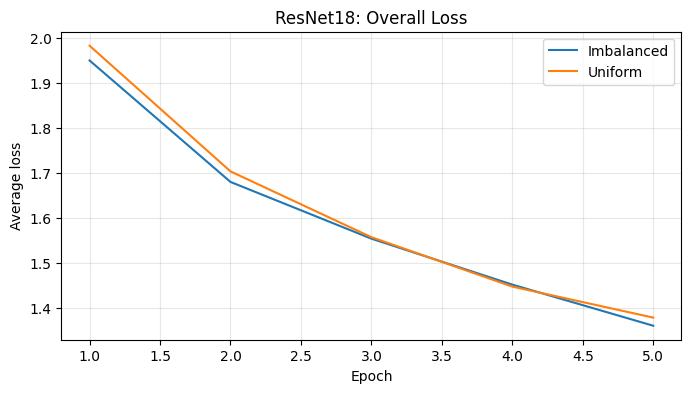

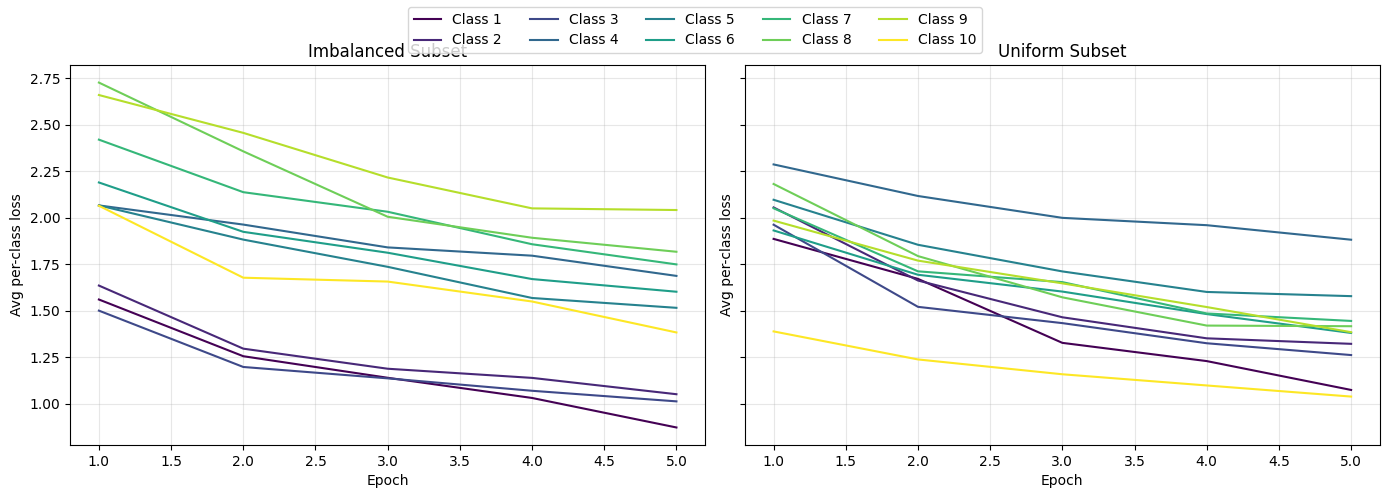

In [ ]:
# Overall loss
plt.figure(figsize=(8,4))
plt.plot(range(1, epochs+1), loss_history_imb, label='Imbalanced')
plt.plot(range(1, epochs+1), loss_history_uni, label='Uniform')
plt.xlabel('Epoch')
plt.ylabel('Average loss')
plt.title('ResNet18: Overall Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Per-class loss: gradual color for classes
cmap = plt.get_cmap('viridis', num_classes)
colors = [cmap(i) for i in range(num_classes)]

fig, axs = plt.subplots(1,2,figsize=(14,5), sharey=True)
for ci in range(num_classes):
    per_class_vals_imb = [per_class_history_imb[e][ci] for e in range(epochs)]
    per_class_vals_uni = [per_class_history_uni[e][ci] for e in range(epochs)]
    axs[0].plot(range(1, epochs+1), per_class_vals_imb, color=colors[ci], label=f'Class {ci+1}')
    axs[1].plot(range(1, epochs+1), per_class_vals_uni, color=colors[ci], label=f'Class {ci+1}')

axs[0].set_title('Imbalanced Subset')
axs[1].set_title('Uniform Subset')
for ax in axs:
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Avg per-class loss')
    ax.grid(True, alpha=0.3)
fig.legend(handles=axs[1].get_lines(), labels=[f'Class {i+1}' for i in range(num_classes)],
           loc='upper center', ncol=num_classes//2)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()


# Experiment 3: Resnet-18 on tiny-imagenet-200 with 200 classes

In [1]:
# Install deps
!pip install -q torch torchvision torchaudio tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random, os, zipfile, requests

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

Device: cuda


In [2]:
# ------------------------------------------------------------
# 1. DOWNLOAD tiny-IMAGENET-200 (train split only for simplicity)
# ------------------------------------------------------------
if not os.path.exists("tiny-imagenet-200/train"):
    print("Downloading tiny-imagenet-200 subset...")
    # ~13 GB total
    !wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
    !unzip tiny-imagenet-200.zip

else:
    print("tiny-imagenet-200 already available.")

data_dir = "tiny-imagenet-200/train"


Streaminguitvoer ingekort tot de laatste 5000 regels.
  inflating: tiny-imagenet-200/val/images/val_3979.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3963.JPEG  
  inflating: tiny-imagenet-200/val/images/val_7199.JPEG  
  inflating: tiny-imagenet-200/val/images/val_2752.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9687.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9407.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3603.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3412.JPEG  
  inflating: tiny-imagenet-200/val/images/val_6982.JPEG  
  inflating: tiny-imagenet-200/val/images/val_8496.JPEG  
  inflating: tiny-imagenet-200/val/images/val_7332.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9241.JPEG  
  inflating: tiny-imagenet-200/val/images/val_4196.JPEG  
  inflating: tiny-imagenet-200/val/images/val_5980.JPEG  
  inflating: tiny-imagenet-200/val/images/val_6697.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9969.JPEG  
  inflating: tiny-

In [3]:
!iunhy bgv,k;,jn # ------------------------------------------------------------
# 2. DATASET + TRANSFORMS
# ------------------------------------------------------------

train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

train_dataset = datasets.ImageFolder(root=data_dir, transform=train_transforms)

num_classes = len(train_dataset.classes)
num_samples = len(train_dataset.samples)
print(f"✅ Loaded dataset from: {data_dir}")
print(f"Number of classes: {num_classes}")
print(f"Number of image samples: {num_samples}")

# ------------------------------------------------------------
# 3. CREATE IMBALANCED AND UNIFORM SUBSETS (robust)
# ------------------------------------------------------------
# Collect all indices for each class
class_indices = [[] for _ in range(num_classes)]
for idx, (_, label) in enumerate(train_dataset.samples):
    class_indices[label].append(idx)

# Compute total number of available samples
total_samples = sum(len(v) for v in class_indices)

if total_samples < num_classes:
    print("⚠️ Warning: Fewer images than classes — imbalance will be minimal.")

# ------------------- Robust 1/k scaling relative to first class -------------------
# available samples per class
available = np.array([len(class_indices[k]) for k in range(num_classes)], dtype=int)
print("Available samples per class (first 10):", available[:10])

# Option A: base n1 on the first class in label order
n1 = available[0]

# Option B (alternative): base n1 on the dataset-wide maximum
# n1 = available.max()

# If n1 is zero (unlikely), fall back to 1
if n1 <= 0:
    n1 = 1

# Desired counts according to 1/k relative to n1
ranks = np.arange(1, num_classes + 1)
desired_by_rank = (n1 / ranks).astype(int)   # floor division effect
desired_by_rank[desired_by_rank == 0] = 1   # enforce at least 1

# Now cap by availability per class (we assume class label k corresponds to rank k here)
# If you intended a different mapping (e.g. rank by some sort order), sort/permute accordingly.
target_samples = np.minimum(desired_by_rank, available)

# If some classes have zero available, ensure we don't request them
target_samples = np.where(available > 0, target_samples, 0)

# Diagnostics
print("First 10 desired_by_rank:", desired_by_rank[:10])
print("First 10 available:", available[:10])
print("First 10 final target_samples:", target_samples[:10])
print("Total imbalanced samples to draw:", int(target_samples.sum()))

# ------------------- Subsample each class according to target_samples -------------------
imbalanced_indices = []
for k, num in enumerate(target_samples):
    inds = class_indices[k]
    if len(inds) == 0 or num == 0:
        continue
    # sample without replacement, cap by available
    sampled = random.sample(inds, min(int(num), len(inds)))
    imbalanced_indices.extend(sampled)

train_dataset_imbalanced = Subset(train_dataset, imbalanced_indices)

# ---------- Uniform subset (same total samples) ----------
uniform_indices = []
samples_per_class = max(1, len(imbalanced_indices) // max(1, num_classes))
for k in range(num_classes):
    inds = class_indices[k]
    if len(inds) == 0:
        continue
    sampled = random.sample(inds, min(samples_per_class, len(inds)))
    uniform_indices.extend(sampled)

train_dataset_uniform = Subset(train_dataset, uniform_indices)

print(f"Imbalanced subset size: {len(train_dataset_imbalanced)}")
print(f"Uniform subset size: {len(train_dataset_uniform)}")

# Optional: show per-class counts for imbalanced subset (quick sanity)
from collections import Counter
imb_counts = Counter([train_dataset.samples[i][1] for i in imbalanced_indices])
print("Imbalanced per-class counts (first 10 classes):", [imb_counts.get(i,0) for i in range(min(10, num_classes))])


print(f"Imbalanced subset size: {len(train_dataset_imbalanced)}")
print(f"Uniform subset size: {len(train_dataset_uniform)}")

# Optional: check class distribution
class_counts_imbalanced = [sum([1 for i in imbalanced_indices if train_dataset.samples[i][1] == c])
                           for c in range(num_classes)]
nonzero_classes = sum([1 for c in class_counts_imbalanced if c > 0])
print(f"Active classes in imbalanced subset: {nonzero_classes}/{num_classes}")

# ------------------------------------------------------------
# 4. DATALOADERS
# ------------------------------------------------------------
# ------------------------------------------------------------------
# Paste this block AFTER you have:
#   - created `train_dataset_imbalanced` and `train_dataset_uniform`
#   - defined `imbalanced_indices` (used for decile grouping earlier)
#   - set `device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')`
# ------------------------------------------------------------------

import time, os, numpy as np, random
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import models
from tqdm.notebook import tqdm
from torch.cuda.amp import GradScaler, autocast
from collections import Counter

# ---------- USER-TUNABLE HYPERPARAMETERS ----------
batch_size = 128            # training batch size (reduce if OOM)
eval_batch = 256            # evaluation batch size
epochs = 10                  # number of epochs
evals_per_epoch = 6         # how many evals per epoch (controls frequency)
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

# ---------- DATALOADERS (fast defaults) ----------
num_cpus = os.cpu_count() or 2
num_workers = min(8, max(0, num_cpus - 1))
pin_memory = True
persistent_workers = True
prefetch_factor = 2

train_loader_imbalanced = DataLoader(
    train_dataset_imbalanced,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory,
    persistent_workers=persistent_workers,
    prefetch_factor=prefetch_factor
)

train_loader_uniform = DataLoader(
    train_dataset_uniform,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory,
    persistent_workers=persistent_workers,
    prefetch_factor=prefetch_factor
)

# ---------------------- create smaller eval subsets ----------------------
eval_fraction = 0.1  # keep 10% of the dataset for evaluation

# imbalanced eval subset
num_eval_imb = max(1, int(len(train_dataset_imbalanced) * eval_fraction))
eval_indices_imbalanced = random.sample(range(len(train_dataset_imbalanced)), num_eval_imb)
eval_dataset_imbalanced_small = Subset(train_dataset_imbalanced, eval_indices_imbalanced)
# uniform eval subset
num_eval_uni = max(1, int(len(train_dataset_uniform) * eval_fraction))
eval_indices_uniform = random.sample(range(len(train_dataset_uniform)), num_eval_uni)
eval_dataset_uniform_small = Subset(train_dataset_uniform, eval_indices_uniform)

# ---------------------- small eval dataloaders ----------------------
eval_loader_imbalanced = DataLoader(
    eval_dataset_imbalanced_small,
    batch_size=eval_batch,
    shuffle=False,
    num_workers=max(0, min(4, num_workers)),
    pin_memory=pin_memory
)

eval_loader_uniform = DataLoader(
    eval_dataset_uniform_small,
    batch_size=eval_batch,
    shuffle=False,
    num_workers=max(0, min(4, num_workers)),
    pin_memory=pin_memory
)

print(f"✅ Small eval loaders: {len(eval_dataset_imbalanced_small)} imbalanced, {len(eval_dataset_uniform_small)} uniform")
# ---------- SPEED FLAGS ----------
torch.backends.cudnn.benchmark = True
USE_TORCH_COMPILE = hasattr(torch, "compile")

# ---------- MODEL & OPTIMIZERS (train only final FC) ----------
num_classes = len(train_dataset.classes)

def get_model(num_classes):
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

    # ❌ remove or comment out these lines:
    # for param in model.parameters():
    #     param.requires_grad = False

    # ✅ keep the classification head replacement
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    model = model.to(device)

    # optional compile
    if USE_TORCH_COMPILE:
        try:
            model = torch.compile(model)
        except Exception:
            pass
    return model


def get_sgd(model, lr=0.01):
    return optim.SGD(model.fc.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)

def get_adam(model, lr=1e-3):
    return optim.Adam(model.fc.parameters(), lr=lr, weight_decay=1e-4)


# ---------- iHGD / sHGD custom optimizers (drop-in) ----------
class Preconditioner:
    def prec(self, x): return x

import torch

class Clip(Preconditioner):
    """Elementwise hard clipping to [-1, 1]. Safe and bounded."""
    def prec(self, x):
        return torch.clamp(x, min=-0.01, max=0.01)

class Cosh(Preconditioner):
    """
    'Cosh' preconditioner: use a soft inverse-like transform.
    We use asinh(x) (inverse hyperbolic sine) as a smooth, odd transform that
    behaves like x for small values and like sign(x) * log(2|x|) for large values.
    This compresses large components instead of amplifying them.
    """
    def prec(self, x):
        return torch.asinh(x)   # numerically stable for all real x

class Exp(Preconditioner):
    """
    'Exp' (soft-exp) preconditioner: *not* raw exp(x) (would explode).
    Instead use sign(x) * log1p(|x|) which grows logarithmically for large |x|.
    This gives a soft, odd transform that compresses large gradients:
        prec(x) = sign(x) * log(1 + |x|)
    """
    def prec(self, x):
        return torch.sign(x) * torch.log1p(torch.abs(x))

class NegLog(Preconditioner):
    """
    'NegLog' preconditioner: a bounded, saturating transform.
    Implemented as x / (1 + |x|) which is odd, bounded in (-1,1), and
    behaves linearly near zero:
        prec(x) = x / (1 + |x|)
    This is numerically safe for all x.
    """
    def prec(self, x):
        return x / (1.0 + torch.abs(x))

class Identity(Preconditioner):
    """No preconditioning — returns the gradient as-is."""
    def prec(self, x):
        return x

import math
import torch
from torch.optim import Optimizer

class _BaseHGD(Optimizer):
    """Base class w/ common helpers for iHGD / sHGD."""
    def __init__(self, params, lr=1e-2, momentum=0.0, weight_decay=0.0):
        if lr <= 0.0:
            raise ValueError("lr must be > 0")
        if not (0.0 <= momentum < 1.0):
            raise ValueError("momentum must be in [0,1)")
        defaults = dict(lr=lr, momentum=momentum, weight_decay=weight_decay)
        super().__init__(params, defaults)

    def _apply_weight_decay(self, p, group):
        wd = group['weight_decay']
        if wd:
            return p.data.mul(wd)
        return None

class iHGD(_BaseHGD):
    """
    Isotropic Hyperbolic Gradient Descent (iHGD) optimizer.
    preconditioner: scale = asinh(norm)/norm  (applied globally to all gradients)
    Supports momentum as in m-NPGM: m_k = beta*m_{k-1} + (1-beta)*precond_grad
    """
    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        # collect all grads and compute global norm
        total_norm_sq = 0.0
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                g = p.grad.data
                total_norm_sq += float((g.float() ** 2).sum().item())
        total_norm = math.sqrt(total_norm_sq)
        # avoid zero division
        eps = 1e-12
        scale = math.asinh(total_norm) / (total_norm + eps)

        # apply update for each param
        for group in self.param_groups:
            lr = group['lr']
            beta = group['momentum']
            wd = group['weight_decay']

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                # apply weight decay (L2) if requested (like SGD)
                if wd:
                    grad = grad.add(wd, p.data)

                # preconditioned gradient (isotropic scaling)
                pre = grad.mul(scale)

                state = self.state[p]
                if 'momentum_buffer' not in state:
                    # initialize momentum buffer m_{-1} = 0
                    state['momentum_buffer'] = torch.zeros_like(pre)

                m_buf = state['momentum_buffer']
                # heavy-ball style update: m_k = beta*m_{k-1} + (1-beta)*pre
                if beta > 0.0:
                    m_buf.mul_(beta).add_(pre, alpha=(1.0 - beta))
                    update = m_buf
                else:
                    update = pre

                # parameter update
                p.data.add_(update, alpha=-lr)

        return loss

class sHGD(_BaseHGD):
    """
    Separable Hyperbolic Gradient Descent (sHGD).
    preconditioner: per-coordinate asinh(grad)
    Supports momentum similar to the paper.
    """
    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            lr = group['lr']
            beta = group['momentum']
            wd = group['weight_decay']

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                # apply weight decay if requested
                if wd:
                    grad = grad.add(wd, p.data)

                # per-element preconditioning: asinh(grad)
                # asinh on potentially FP16 grads is ok when scaler has unscaled them already
                pre = torch.asinh(grad)

                state = self.state[p]
                if 'momentum_buffer' not in state:
                    state['momentum_buffer'] = torch.zeros_like(pre)

                m_buf = state['momentum_buffer']

                if beta > 0.0:
                    m_buf.mul_(beta).add_(pre, alpha=(1.0 - beta))
                    update = m_buf
                else:
                    update = pre

                p.data.add_(update, alpha=-lr)

        return loss

class PrecGDSepAdam(Optimizer):
    """
    Separable Adam-style preconditioning with pluggable second-moment transform.

    Options for v_transform:
      - 'square'     : standard Adam, psi(g) = g^2
      - 'cosh'       : psi(g) = cosh(scale * g) - 1
      - 'asinh_sq'   : psi(g) = asinh(g)^2
      - 'log1p_sq'   : psi(g) = log1p(g^2)
      - 'abs'        : psi(g) = |g|
      - callable     : a function psi(tensor) -> tensor

    The update still computes scaled = m_hat / (sqrt(v_hat) + eps),
    then delta = prec.prec(lamb * scaled) elementwise, and p -= lr * delta.
    """
    def __init__(self, params, prec,
                 lr=1e-3, lamb=1.0,
                 betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=0.0, bias_correction=True,
                 v_transform='square', v_scale=1.0):
        if lr <= 0.0:
            raise ValueError("Invalid lr")
        defaults = dict(lr=lr, lamb=lamb, betas=betas, eps=eps,
                        weight_decay=weight_decay, bias_correction=bias_correction,
                        v_transform=v_transform, v_scale=v_scale)
        super().__init__(params, defaults)
        self.prec = prec
        self._step = 0

        # map standard names to functions (callable expects tensor input)
        def _psi_square(g, scale=1.0):
            return (g * scale) ** 2

        def _psi_cosh(g, scale=1.0):
            # cosh(scale * g) - 1 ; subtract 1 so psi(0)=0
            return torch.cosh(g * scale) - 1.0

        def _psi_asinh_sq(g, scale=1.0):
            return torch.asinh(g * scale) ** 2

        def _psi_log1p_sq(g, scale=1.0):
            return torch.log1p((g * scale) ** 2)

        def _psi_abs(g, scale=1.0):
            return torch.abs(g * scale)

        self._builtin_psi = {
            'square': _psi_square,
            'cosh': _psi_cosh,
            'asinh_sq': _psi_asinh_sq,
            'log1p_sq': _psi_log1p_sq,
            'abs': _psi_abs
        }

    def _apply_psi(self, psi_spec, g, scale):
        """Return psi(g) given psi_spec (name or callable) and scale."""
        if callable(psi_spec):
            return psi_spec(g, scale) if _callable_accepts_scale(psi_spec) else psi_spec(g)
        if isinstance(psi_spec, str):
            fn = self._builtin_psi.get(psi_spec)
            if fn is None:
                raise ValueError(f"Unknown v_transform '{psi_spec}'")
            return fn(g, scale)
        raise ValueError("v_transform must be str or callable")

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()
        self._step += 1

        for group in self.param_groups:
            lr = group['lr']
            lamb = group['lamb']
            beta1, beta2 = group['betas']
            eps = group['eps']
            wd = group['weight_decay']
            bias_corr = group['bias_correction']
            psi_spec = group.get('v_transform', 'square')
            psi_scale = float(group.get('v_scale', 1.0))

            for p in group['params']:
                if p.grad is None:
                    continue
                g = p.grad.data
                # apply weight decay in Adam style if requested (decoupled or not? here we simply add)
                if wd != 0:
                    g = g.add(p.data, alpha=wd)

                state = self.state.setdefault(p, {})
                if 'm' not in state:
                    state['m'] = torch.zeros_like(p.data)
                    state['v'] = torch.zeros_like(p.data)

                m = state['m']
                v = state['v']

                # first moment
                m.mul_(beta1).add_(g, alpha=(1 - beta1))

                # second moment uses psi transform instead of g^2
                try:
                    psi_val = self._apply_psi(psi_spec, g, psi_scale)
                except Exception as e:
                    # fallback: if psi is weird, fall back to square
                    psi_val = g * g

                # ensure psi_val is same device/shape
                if not isinstance(psi_val, torch.Tensor) or psi_val.shape != g.shape:
                    psi_val = torch.as_tensor(psi_val, device=g.device, dtype=g.dtype).view_as(g)

                v.mul_(beta2).add_(psi_val, alpha=(1 - beta2))

                # bias correction
                if bias_corr:
                    bc1 = 1 - beta1 ** self._step
                    bc2 = 1 - beta2 ** self._step
                    # avoid divide-by-zero in early steps
                    m_hat = m / (bc1 + 1e-16)
                    v_hat = v / (bc2 + 1e-16)
                else:
                    m_hat = m
                    v_hat = v

                # ensure non-negativity and stability of v_hat (some psi could produce tiny negatives numerically)
                # clamp minimum to small positive
                v_hat = v_hat.clamp(min=1e-30)

                denom = v_hat.sqrt().add(eps)
                scaled = m_hat / denom

                # elementwise preconditioner application
                try:
                    delta = self.prec.prec(lamb * scaled)
                except Exception:
                    # fallback to elementwise scalar application (slower)
                    flat = scaled.view(-1)
                    vals = [self.prec.prec(float(x)) for x in flat]
                    delta = torch.tensor(vals, device=scaled.device, dtype=scaled.dtype).view_as(scaled)

                p.data.add_(delta, alpha=-lr)

        return loss

# ---------- convenience factory wrappers ----------
def get_ihgd(model, lr=1e-2, momentum=0.0, weight_decay=0.0):
    # Only optimize model.fc parameters (as you intended)
    params = model.fc.parameters()
    return iHGD(params, lr=lr, momentum=momentum, weight_decay=weight_decay)

def get_shgd(model, lr=1e-2, momentum=0.0, weight_decay=0.0):
    params = model.fc.parameters()
    return sHGD(params, lr=lr, momentum=momentum, weight_decay=weight_decay)


# ---------- evaluation helper (per-class losses) ----------
loss_fn_per_sample = nn.CrossEntropyLoss(reduction='none')

def evaluate_per_class(model, loader):
    model.eval()
    per_class_loss = np.zeros(num_classes, dtype=float)
    per_class_count = np.zeros(num_classes, dtype=int)
    total_loss = 0.0
    total_samples = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            logits = model(inputs)
            losses = loss_fn_per_sample(logits, labels)  # shape (B,)
            total_loss += losses.sum().item()
            total_samples += labels.size(0)
            lbls_cpu = labels.cpu().numpy()
            for i, lbl in enumerate(lbls_cpu):
                per_class_loss[lbl] += float(losses[i].item())
                per_class_count[lbl] += 1
    per_class_avg = per_class_loss / np.maximum(per_class_count, 1)
    overall_avg = total_loss / max(1, total_samples)
    return overall_avg, per_class_avg, per_class_count

# ---------- improved decile grouping so each decile has ~10% of the SAMPLES ----------
# requires `imbalanced_indices` (list of dataset indices used in imbalanced subset)

from collections import Counter

# per-class counts in the imbalanced subset
imbalanced_labels = [train_dataset.samples[idx][1] for idx in imbalanced_indices]
class_counts = Counter(imbalanced_labels)
class_freqs = np.array([class_counts.get(c, 0) for c in range(num_classes)], dtype=int)
print("class freqs (first 20):", class_freqs[:20])

# sort classes by descending frequency (class indices)
sorted_classes_desc = np.argsort(-class_freqs)
sorted_counts = class_freqs[sorted_classes_desc]

total_samples_in_subset = sorted_counts.sum()
if total_samples_in_subset == 0:
    raise ValueError("Imbalanced subset has zero samples.")
print("total samples in imbalanced subset:", total_samples_in_subset)

# desired cumulative cut points (10%, 20%, ..., 90%) - we will create 10 bins
n_bins = 10
cuts = [total_samples_in_subset * i / n_bins for i in range(1, n_bins)]  # 9 cut thresholds

# cumulative sums over sorted counts
cumsum = np.cumsum(sorted_counts)

# find class indices where cuts are crossed
cut_positions = np.searchsorted(cumsum, cuts, side='left')  # indices into sorted_classes_desc

# now build bins by slicing sorted_classes_desc
decile_indices = []
prev = 0
for pos in cut_positions:
    # slice classes from prev .. pos (inclusive pos)
    if pos < prev:
        pos = prev
    decile_indices.append(sorted_classes_desc[prev:pos+1])  # include pos to ensure progress
    prev = pos+1
# last bin: remaining classes
decile_indices.append(sorted_classes_desc[prev:])

# If some bins ended up empty (possible for extreme distributions), fix by moving classes
# from neighboring bins until none are empty.
for i in range(len(decile_indices)):
    if len(decile_indices[i]) == 0:
        # try borrow from next bin
        j = i+1
        while j < len(decile_indices) and len(decile_indices[j]) == 0:
            j += 1
        if j < len(decile_indices) and len(decile_indices[j]) > 1:
            # move the first class of j to i
            decile_indices[i] = np.array([decile_indices[j][0]])
            decile_indices[j] = decile_indices[j][1:]
        else:
            # otherwise borrow from previous bin
            j = i-1
            while j >= 0 and len(decile_indices[j]) <= 1:
                j -= 1
            if j >= 0:
                decile_indices[i] = np.array([decile_indices[j][-1]])
                decile_indices[j] = decile_indices[j][:-1]
            else:
                # last-resort: leave empty (rare)
                pass

# Final diagnostics: compute sample counts per decile
decile_counts = np.array([class_freqs[inds].sum() if len(inds) > 0 else 0 for inds in decile_indices])
print("decile sample counts (final):", decile_counts, "sum:", decile_counts.sum())
most_freq_decile = int(np.argmax(decile_counts))
print("most_freq_decile (0-indexed):", most_freq_decile)
num_deciles = len(decile_indices)
print("num_deciles:", num_deciles)

# Optionally show number of classes per decile
print("classes per decile:", [len(inds) for inds in decile_indices])


# ---------------------- Balanced per-class eval subsets (k per class) ----------------------
from collections import defaultdict

k_per_class = 5   # <--- choose how many samples per class for balanced eval (5 is a good default)

def build_balanced_eval_subset(full_subset_indices, dataset_obj, k=k_per_class):
    """
    full_subset_indices: list of indices into dataset_obj (these are the indices of the training subset)
    dataset_obj: the original full train_dataset (so dataset_obj.samples[idx][1] -> label)
    returns: a list of dataset indices forming the balanced eval subset
    """
    # collect indices per class (but indices are indices into dataset_obj)
    per_class = defaultdict(list)
    for idx in full_subset_indices:
        lbl = dataset_obj.samples[idx][1]
        per_class[lbl].append(idx)

    # sample up to k per class
    chosen = []
    for c, inds in per_class.items():
        if len(inds) == 0:
            continue
        n_take = min(k, len(inds))
        # sample deterministically for reproducibility? you can use random.sample for random
        chosen_inds = random.sample(inds, n_take)
        chosen.extend(chosen_inds)
    return chosen

# Build balanced eval indices for imbalanced subset (we use imbalanced_indices which are dataset indices)
balanced_eval_indices_imbalanced = build_balanced_eval_subset(imbalanced_indices, train_dataset, k=k_per_class)

# For uniform subset, we used "uniform_indices" above (dataset indices). If not available, create it similarly.
# uniform_indices should exist from earlier code. If you used different variable names, adapt accordingly.
balanced_eval_indices_uniform = build_balanced_eval_subset(uniform_indices, train_dataset, k=k_per_class)

# Convert to Subsets (these are Subset objects indexing into the original train_dataset)
balanced_eval_dataset_imbalanced = Subset(train_dataset, balanced_eval_indices_imbalanced)
balanced_eval_dataset_uniform = Subset(train_dataset, balanced_eval_indices_uniform)

# Create DataLoaders for balanced evals (small and cheap)
eval_batch = min(256, max(1, len(balanced_eval_indices_imbalanced)))  # reuse eval_batch variable but safe
balanced_eval_loader_imbalanced = DataLoader(
    balanced_eval_dataset_imbalanced,
    batch_size=eval_batch,
    shuffle=False,
    num_workers=max(0, min(4, num_workers)),
    pin_memory=pin_memory
)

balanced_eval_loader_uniform = DataLoader(
    balanced_eval_dataset_uniform,
    batch_size=eval_batch,
    shuffle=False,
    num_workers=max(0, min(4, num_workers)),
    pin_memory=pin_memory
)

print(f"Balanced eval: imbalanced subset -> {len(balanced_eval_dataset_imbalanced)} samples ({k_per_class} per active class)")
print(f"Balanced eval: uniform subset    -> {len(balanced_eval_dataset_uniform)} samples ({k_per_class} per active class)")

# ---------------------- Use balanced eval loaders in your runner ----------------------
# In the run_experiment function you used small_train_eval_loader = eval_loader_imbalanced / eval_loader_uniform.
# Replace those with the balanced loaders:
#
#    if dataset == 'imbalanced':
#        train_loader = train_loader_imbalanced
#        small_train_eval_loader = balanced_eval_loader_imbalanced
#    else:
#        train_loader = train_loader_uniform
#        small_train_eval_loader = balanced_eval_loader_uniform
#
# If you want, paste the exact updated run_experiment below (complete replacement):

def run_experiment(optimizer_name='sgd', dataset='imbalanced', lr=None):
    """
    Records training losses per batch separately from evaluation snapshots.
    - train_steps / train_losses: recorded every batch (fine-grained)
    - eval_steps / per_class_history: recorded at init, periodic evals, and epoch-end (coarse snapshots)
    Returns both sets for correct plotting.
    """
    if dataset == 'imbalanced':
        train_loader = train_loader_imbalanced
        small_train_eval_loader = balanced_eval_loader_imbalanced
    else:
        train_loader = train_loader_uniform
        small_train_eval_loader = balanced_eval_loader_uniform

    model = get_model(num_classes)
    opt_name = optimizer_name.lower()
    if opt_name == 'sgd':
        opt = get_sgd(model, lr=(0.01 if lr is None else lr))
    elif opt_name == 'adam':
        opt = get_adam(model, lr=(1e-3 if lr is None else lr))
    elif opt_name == 'ihgd':
        # default lr slightly larger by intuition, override with lr param if given
        opt = get_ihgd(model, lr=(1e-2 if lr is None else lr), momentum=0.0, weight_decay=1e-4)
    elif opt_name == 'shgd':
        opt = get_shgd(model, lr=(1e-2 if lr is None else lr), momentum=0.0, weight_decay=1e-4)
    # optional momentum variants: 'ihgdm' and 'shgdm' (you can call these names)
    elif opt_name == 'ihgdm':
        opt = get_ihgd(model, lr=(1e-2 if lr is None else lr), momentum=0.9, weight_decay=1e-4)
    elif opt_name == 'shgdm':
        opt = get_shgd(model, lr=(1e-2 if lr is None else lr), momentum=0.9, weight_decay=1e-4)
    elif opt_name == 'sepadam_clip_coshv':
        opt = PrecGDSepAdam(
            model.parameters(),
            prec=Clip(),
            lr=1e-3 if lr is None else lr,
            lamb=1.0,
            betas=(0.9, 0.999),
            v_transform='cosh',
            v_scale=0.5
        )
    else:
        raise ValueError("optimizer must be 'sgd', 'adam', 'ihgd', 'shgd', 'ihgdm', 'shgdm' or 'sepadam_clip_coshv'")


    scaler = GradScaler()
    batches_per_epoch = len(train_loader)
    eval_interval = max(1, batches_per_epoch // max(1, evals_per_epoch))

    # storage: separate train vs eval
    train_steps = []
    train_losses = []
    eval_steps = []
    per_class_hist = []
    global_step = 0

    # ---------- initial "step 0" training-loss estimate ----------
    try:
        first_batch = next(iter(train_loader))
        inputs0, labels0 = first_batch
        inputs0, labels0 = inputs0.to(device, non_blocking=True), labels0.to(device, non_blocking=True)
        model.eval()
        with torch.no_grad():
            logits0 = model(inputs0)
            loss0 = nn.functional.cross_entropy(logits0, labels0).item()
    except Exception:
        loss0 = float('nan')

    # record initial training estimate (not a batch step)
    # note: do NOT put this into train_steps (since no training step executed yet)
    # keep as eval snapshot at step 0
    eval_steps.append(0)
    per_class_avg0, pc_avg0, pc_cnt0 = None, None, None
    ov, pc_avg, pc_cnt = evaluate_per_class(model, small_train_eval_loader)
    per_class_hist.append(pc_avg.copy())

    print(f"[Init] {optimizer_name.upper()} on {dataset}: train-batch-loss-estimate={loss0:.4f}, balanced-small-train-eval-loss={ov:.4f}")

    model.train()
    for ep in range(epochs):
        epoch_start = time.time()
        pbar = tqdm(train_loader, desc=f"{optimizer_name.upper()}-{dataset} EP{ep+1}", leave=False)
        for bidx, (inputs, labels) in enumerate(pbar):
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            opt.zero_grad()

            with autocast():
                logits = model(inputs)
                loss = nn.functional.cross_entropy(logits, labels)

            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()

            global_step += 1

            # record train loss for this batch
            train_steps.append(global_step)
            train_losses.append(loss.item())

            # update pbar occasionally
            if bidx % max(1, (eval_interval // 2)) == 0:
                pbar.set_postfix({'batch_loss': f"{loss.item():.4f}"})
                pbar.refresh()

            # periodic eval snapshot (cheap balanced per-class eval)
            if global_step % eval_interval == 0:
                model.eval()
                ov_small, pc_avg_small, pc_cnt_small = evaluate_per_class(model, small_train_eval_loader)
                eval_steps.append(global_step)
                per_class_hist.append(pc_avg_small.copy())
                print(f"   Eval snapshot @ step {global_step}: balanced-small-train-loss={ov_small:.4f}", flush=True)
                model.train()

        # end-of-epoch snapshot (even if last batch already triggered an eval, it's fine to capture again)
        model.eval()
        ov_small, pc_avg_small, pc_cnt_small = evaluate_per_class(model, small_train_eval_loader)
        eval_steps.append(global_step)
        per_class_hist.append(pc_avg_small.copy())
        print(f"[Epoch {ep+1}] {optimizer_name.upper()} on {dataset}: balanced-small-train-loss={ov_small:.4f}  (epoch time {time.time()-epoch_start:.1f}s)")
        model.train()

    # convert histories to arrays
    per_class_arr = np.stack(per_class_hist)  # shape (T_eval, num_classes)

    return {
        'optimizer': optimizer_name,
        'dataset': dataset,
        # training (per-batch)
        'train_steps': np.array(train_steps),
        'train_losses': np.array(train_losses),
        # evaluation snapshots (coarse)
        'eval_steps': np.array(eval_steps),
        'per_class_history': per_class_arr,   # rows correspond to eval_steps
        # compatibility fields (old names) — overall_losses kept as train_losses for backward compatibility
        'steps': np.array(train_steps),
        'overall_losses': np.array(train_losses),
    }



# ---------- USAGE EXAMPLE ----------
# res_sgd_imb = run_experiment('sgd', 'imbalanced')
# res_adam_imb = run_experiment('adam', 'imbalanced')
# res_sgd_uni = run_experiment('sgd', 'uniform')
# res_adam_uni = run_experiment('adam', 'uniform')

print("Helper block loaded — call run_experiment(...) to run trials.")


/bin/bash: line 1: iunhy: command not found
/bin/bash: line 1: ,jn: command not found
✅ Loaded dataset from: tiny-imagenet-200/train
Number of classes: 200
Number of image samples: 100000
Available samples per class (first 10): [500 500 500 500 500 500 500 500 500 500]
First 10 desired_by_rank: [500 250 166 125 100  83  71  62  55  50]
First 10 available: [500 500 500 500 500 500 500 500 500 500]
First 10 final target_samples: [500 250 166 125 100  83  71  62  55  50]
Total imbalanced samples to draw: 2840
Imbalanced subset size: 2840
Uniform subset size: 2800
Imbalanced per-class counts (first 10 classes): [500, 250, 166, 125, 100, 83, 71, 62, 55, 50]
Imbalanced subset size: 2840
Uniform subset size: 2800
Active classes in imbalanced subset: 200/200
✅ Small eval loaders: 284 imbalanced, 280 uniform
class freqs (first 20): [500 250 166 125 100  83  71  62  55  50  45  41  38  35  33  31  29  27
  26  25]
total samples in imbalanced subset: 2840
decile sample counts (final): [500 250 16

In [ ]:
import pandas as pd
import numpy as np
import os

# make sure results folder exists
results_dir = "experiment_results"
os.makedirs(results_dir, exist_ok=True)

# ---------------- HELPER: PER-DECILE HISTORY ----------------
def per_decile_history(res):
    """
    Build decile history from res['per_class_history'] (shape: T_eval x num_classes).
    Use np.nanmean to ignore classes with no samples in the balanced eval.
    Returns decile_hist shape (num_deciles, T_eval).
    """
    per_class_hist = res['per_class_history']  # shape (T_eval, num_classes)
    T = per_class_hist.shape[0]
    decile_hist = np.full((num_deciles, T), np.nan, dtype=float)
    for d, inds in enumerate(decile_indices):
        if len(inds) == 0:
            continue
        # take nanmean across the selected class columns
        decile_hist[d, :] = np.nanmean(per_class_hist[:, inds], axis=1)
    return decile_hist

# ---------------- SAVE CSV HELPERS ----------------
def save_decile_history_csv(decile_hist, eval_steps, opt_name, dataset_name):
    """
    decile_hist: (num_deciles, T_eval)
    eval_steps: length T_eval (x-axis for decile snapshots)
    """
    df = pd.DataFrame(decile_hist.T, columns=[f"Decile_{i+1}" for i in range(decile_hist.shape[0])])
    df.insert(0, "Step", eval_steps)
    file_path = os.path.join(results_dir, f"{opt_name}_{dataset_name}_deciles.csv")
    df.to_csv(file_path, index=False)
    print(f"Saved decile history to {file_path}")

def save_overall_loss_csv(train_losses, train_steps, opt_name, dataset_name):
    df = pd.DataFrame({"Step": train_steps, "Overall_Loss": train_losses})
    file_path = os.path.join(results_dir, f"{opt_name}_{dataset_name}_overall.csv")
    df.to_csv(file_path, index=False)
    print(f"Saved overall loss to {file_path}")

# ---------------- RUN ALL FOUR EXPERIMENTS (updated) ----------------
experiments = [
    ('sepadam_clip_coshv', 'imbalanced'),
    ('sepadam_clip_coshv', 'uniform'),
    ('sgd', 'imbalanced'),
    ('adam', 'imbalanced'),
    ('ihgdm', 'imbalanced'),
    ('shgdm', 'imbalanced'),
    ('sgd', 'uniform'),
    ('adam', 'uniform'),
    ('ihgd', 'uniform'),
    ('shgd', 'uniform')
]

results = {}
for opt_name, dataset_name in experiments:
    print(f"\n=== Running {opt_name.upper()} on {dataset_name} ===")
    res = run_experiment(opt_name, dataset_name)

    # get train/eval arrays (backwards-compatible aliases exist too)
    train_steps = res.get('train_steps', res.get('steps', np.array([], dtype=int)))
    train_losses = res.get('train_losses', res.get('overall_losses', np.array([], dtype=float)))
    eval_steps = res.get('eval_steps', np.array([], dtype=int))
    per_class_history = res['per_class_history']  # shape (T_eval, num_classes)

    # compute decile history (aligned with eval_steps) and save CSV (use eval_steps)
    if per_class_history.size > 0 and eval_steps.size > 0:
        decile_hist = per_decile_history(res)  # shape (num_deciles, T_eval)
        save_decile_history_csv(decile_hist, eval_steps, opt_name, dataset_name)
    else:
        print("Warning: no eval snapshots found; skipping decile CSV.")

    # save overall training loss CSV (use train_steps)
    if train_losses.size > 0 and train_steps.size > 0:
        save_overall_loss_csv(train_losses, train_steps, opt_name, dataset_name)
    else:
        print("Warning: no train losses found; skipping overall CSV.")

    # store in memory
    results[f"{opt_name}_{dataset_name}"] = res

print("\nAll experiments completed and saved.")



=== Running SEPADAM_CLIP_COSHV on imbalanced ===
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 188MB/s]
/tmp/ipython-input-1195210293.py:775: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
W1028 08:02:39.670000 1961 torch/_inductor/utils.py:1436] [0/0] Not enough SMs to use max_autotune_gemm mode


[Init] SEPADAM_CLIP_COSHV on imbalanced: train-batch-loss-estimate=5.5357, balanced-small-train-eval-loss=5.4679


SEPADAM_CLIP_COSHV-imbalanced EP1:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipython-input-1195210293.py:816: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-1195210293.py:816: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


   Eval snapshot @ step 3: balanced-small-train-loss=5.4708
   Eval snapshot @ step 6: balanced-small-train-loss=5.4552
   Eval snapshot @ step 9: balanced-small-train-loss=5.4382
   Eval snapshot @ step 12: balanced-small-train-loss=5.4003
   Eval snapshot @ step 15: balanced-small-train-loss=5.4071
   Eval snapshot @ step 18: balanced-small-train-loss=5.3902
   Eval snapshot @ step 21: balanced-small-train-loss=5.3569
[Epoch 1] SEPADAM_CLIP_COSHV on imbalanced: balanced-small-train-loss=5.3607  (epoch time 92.7s)


SEPADAM_CLIP_COSHV-imbalanced EP2:   0%|          | 0/23 [00:00<?, ?it/s]

   Eval snapshot @ step 24: balanced-small-train-loss=5.3679
   Eval snapshot @ step 27: balanced-small-train-loss=5.3472
   Eval snapshot @ step 30: balanced-small-train-loss=5.3482
   Eval snapshot @ step 33: balanced-small-train-loss=5.3119
   Eval snapshot @ step 36: balanced-small-train-loss=5.3176
   Eval snapshot @ step 39: balanced-small-train-loss=5.3226
   Eval snapshot @ step 42: balanced-small-train-loss=5.3136
   Eval snapshot @ step 45: balanced-small-train-loss=5.2926
[Epoch 2] SEPADAM_CLIP_COSHV on imbalanced: balanced-small-train-loss=5.3007  (epoch time 40.3s)


SEPADAM_CLIP_COSHV-imbalanced EP3:   0%|          | 0/23 [00:00<?, ?it/s]

   Eval snapshot @ step 48: balanced-small-train-loss=5.2638
   Eval snapshot @ step 51: balanced-small-train-loss=5.2904
   Eval snapshot @ step 54: balanced-small-train-loss=5.2664
   Eval snapshot @ step 57: balanced-small-train-loss=5.2470
   Eval snapshot @ step 60: balanced-small-train-loss=5.2655
   Eval snapshot @ step 63: balanced-small-train-loss=5.2615
   Eval snapshot @ step 66: balanced-small-train-loss=5.2205
   Eval snapshot @ step 69: balanced-small-train-loss=5.2291
[Epoch 3] SEPADAM_CLIP_COSHV on imbalanced: balanced-small-train-loss=5.2121  (epoch time 38.3s)


SEPADAM_CLIP_COSHV-imbalanced EP4:   0%|          | 0/23 [00:00<?, ?it/s]

   Eval snapshot @ step 72: balanced-small-train-loss=5.2369
   Eval snapshot @ step 75: balanced-small-train-loss=5.2324
   Eval snapshot @ step 78: balanced-small-train-loss=5.1913
   Eval snapshot @ step 81: balanced-small-train-loss=5.1945
   Eval snapshot @ step 84: balanced-small-train-loss=5.1808
   Eval snapshot @ step 87: balanced-small-train-loss=5.1530
   Eval snapshot @ step 90: balanced-small-train-loss=5.1409
[Epoch 4] SEPADAM_CLIP_COSHV on imbalanced: balanced-small-train-loss=5.1246  (epoch time 37.9s)


SEPADAM_CLIP_COSHV-imbalanced EP5:   0%|          | 0/23 [00:00<?, ?it/s]

   Eval snapshot @ step 93: balanced-small-train-loss=5.1469
   Eval snapshot @ step 96: balanced-small-train-loss=5.1140
   Eval snapshot @ step 99: balanced-small-train-loss=5.1042
   Eval snapshot @ step 102: balanced-small-train-loss=5.1084
   Eval snapshot @ step 105: balanced-small-train-loss=5.0736
   Eval snapshot @ step 108: balanced-small-train-loss=5.0588
   Eval snapshot @ step 111: balanced-small-train-loss=5.0605
   Eval snapshot @ step 114: balanced-small-train-loss=5.0626
[Epoch 5] SEPADAM_CLIP_COSHV on imbalanced: balanced-small-train-loss=5.0563  (epoch time 38.5s)


SEPADAM_CLIP_COSHV-imbalanced EP6:   0%|          | 0/23 [00:00<?, ?it/s]

   Eval snapshot @ step 117: balanced-small-train-loss=5.0399
   Eval snapshot @ step 120: balanced-small-train-loss=5.0352
   Eval snapshot @ step 123: balanced-small-train-loss=5.0265
   Eval snapshot @ step 126: balanced-small-train-loss=5.0118
   Eval snapshot @ step 129: balanced-small-train-loss=4.9950
   Eval snapshot @ step 132: balanced-small-train-loss=4.9820
   Eval snapshot @ step 135: balanced-small-train-loss=4.9604
   Eval snapshot @ step 138: balanced-small-train-loss=5.0002
[Epoch 6] SEPADAM_CLIP_COSHV on imbalanced: balanced-small-train-loss=4.9843  (epoch time 38.7s)


SEPADAM_CLIP_COSHV-imbalanced EP7:   0%|          | 0/23 [00:00<?, ?it/s]

   Eval snapshot @ step 141: balanced-small-train-loss=4.9722
   Eval snapshot @ step 144: balanced-small-train-loss=4.9796
   Eval snapshot @ step 147: balanced-small-train-loss=4.9594
   Eval snapshot @ step 150: balanced-small-train-loss=4.9580
   Eval snapshot @ step 153: balanced-small-train-loss=4.9535
   Eval snapshot @ step 156: balanced-small-train-loss=4.9503
   Eval snapshot @ step 159: balanced-small-train-loss=4.9141
[Epoch 7] SEPADAM_CLIP_COSHV on imbalanced: balanced-small-train-loss=4.9197  (epoch time 37.9s)


SEPADAM_CLIP_COSHV-imbalanced EP8:   0%|          | 0/23 [00:00<?, ?it/s]

   Eval snapshot @ step 162: balanced-small-train-loss=4.9248
   Eval snapshot @ step 165: balanced-small-train-loss=4.9092
   Eval snapshot @ step 168: balanced-small-train-loss=4.9051
   Eval snapshot @ step 171: balanced-small-train-loss=4.9131
   Eval snapshot @ step 174: balanced-small-train-loss=4.9409
   Eval snapshot @ step 177: balanced-small-train-loss=4.8847
   Eval snapshot @ step 180: balanced-small-train-loss=4.8704
   Eval snapshot @ step 183: balanced-small-train-loss=4.8878
[Epoch 8] SEPADAM_CLIP_COSHV on imbalanced: balanced-small-train-loss=4.8634  (epoch time 37.8s)


SEPADAM_CLIP_COSHV-imbalanced EP9:   0%|          | 0/23 [00:00<?, ?it/s]

   Eval snapshot @ step 186: balanced-small-train-loss=4.8750
   Eval snapshot @ step 189: balanced-small-train-loss=4.8445
   Eval snapshot @ step 192: balanced-small-train-loss=4.8399
   Eval snapshot @ step 195: balanced-small-train-loss=4.8633
   Eval snapshot @ step 198: balanced-small-train-loss=4.8057
   Eval snapshot @ step 201: balanced-small-train-loss=4.8193
   Eval snapshot @ step 204: balanced-small-train-loss=4.7919
   Eval snapshot @ step 207: balanced-small-train-loss=4.7588
[Epoch 9] SEPADAM_CLIP_COSHV on imbalanced: balanced-small-train-loss=4.8145  (epoch time 38.0s)


SEPADAM_CLIP_COSHV-imbalanced EP10:   0%|          | 0/23 [00:00<?, ?it/s]

   Eval snapshot @ step 210: balanced-small-train-loss=4.7665
   Eval snapshot @ step 213: balanced-small-train-loss=4.8056
   Eval snapshot @ step 216: balanced-small-train-loss=4.7683
   Eval snapshot @ step 219: balanced-small-train-loss=4.7658
   Eval snapshot @ step 222: balanced-small-train-loss=4.7481
   Eval snapshot @ step 225: balanced-small-train-loss=4.7245
   Eval snapshot @ step 228: balanced-small-train-loss=4.7265
[Epoch 10] SEPADAM_CLIP_COSHV on imbalanced: balanced-small-train-loss=4.7253  (epoch time 35.2s)
Saved decile history to experiment_results/sepadam_clip_coshv_imbalanced_deciles.csv
Saved overall loss to experiment_results/sepadam_clip_coshv_imbalanced_overall.csv

=== Running SEPADAM_CLIP_COSHV on uniform ===


/tmp/ipython-input-1195210293.py:775: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


[Init] SEPADAM_CLIP_COSHV on uniform: train-batch-loss-estimate=5.4832, balanced-small-train-eval-loss=5.5309


SEPADAM_CLIP_COSHV-uniform EP1:   0%|          | 0/22 [00:00<?, ?it/s]

/tmp/ipython-input-1195210293.py:816: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


   Eval snapshot @ step 3: balanced-small-train-loss=5.5252
   Eval snapshot @ step 6: balanced-small-train-loss=5.5098
   Eval snapshot @ step 9: balanced-small-train-loss=5.4668
   Eval snapshot @ step 12: balanced-small-train-loss=5.4479
   Eval snapshot @ step 15: balanced-small-train-loss=5.4414
   Eval snapshot @ step 18: balanced-small-train-loss=5.4061
   Eval snapshot @ step 21: balanced-small-train-loss=5.3843
[Epoch 1] SEPADAM_CLIP_COSHV on uniform: balanced-small-train-loss=5.3718  (epoch time 50.3s)


SEPADAM_CLIP_COSHV-uniform EP2:   0%|          | 0/22 [00:00<?, ?it/s]

   Eval snapshot @ step 24: balanced-small-train-loss=5.3742
   Eval snapshot @ step 27: balanced-small-train-loss=5.3267
   Eval snapshot @ step 30: balanced-small-train-loss=5.3229
   Eval snapshot @ step 33: balanced-small-train-loss=5.3080
   Eval snapshot @ step 36: balanced-small-train-loss=5.3024
   Eval snapshot @ step 39: balanced-small-train-loss=5.2718
   Eval snapshot @ step 42: balanced-small-train-loss=5.2669
[Epoch 2] SEPADAM_CLIP_COSHV on uniform: balanced-small-train-loss=5.2379  (epoch time 40.5s)


SEPADAM_CLIP_COSHV-uniform EP3:   0%|          | 0/22 [00:00<?, ?it/s]

   Eval snapshot @ step 45: balanced-small-train-loss=5.2228
   Eval snapshot @ step 48: balanced-small-train-loss=5.2114
   Eval snapshot @ step 51: balanced-small-train-loss=5.1832
   Eval snapshot @ step 54: balanced-small-train-loss=5.1687
   Eval snapshot @ step 57: balanced-small-train-loss=5.1363
   Eval snapshot @ step 60: balanced-small-train-loss=5.1256
   Eval snapshot @ step 63: balanced-small-train-loss=5.0984
   Eval snapshot @ step 66: balanced-small-train-loss=5.0751
[Epoch 3] SEPADAM_CLIP_COSHV on uniform: balanced-small-train-loss=5.0846  (epoch time 44.7s)


SEPADAM_CLIP_COSHV-uniform EP4:   0%|          | 0/22 [00:00<?, ?it/s]

   Eval snapshot @ step 69: balanced-small-train-loss=5.0813
   Eval snapshot @ step 72: balanced-small-train-loss=5.0463
   Eval snapshot @ step 75: balanced-small-train-loss=5.0156
   Eval snapshot @ step 78: balanced-small-train-loss=5.0219
   Eval snapshot @ step 81: balanced-small-train-loss=5.0021
   Eval snapshot @ step 84: balanced-small-train-loss=4.9720
   Eval snapshot @ step 87: balanced-small-train-loss=4.9589
[Epoch 4] SEPADAM_CLIP_COSHV on uniform: balanced-small-train-loss=4.9470  (epoch time 40.5s)


SEPADAM_CLIP_COSHV-uniform EP5:   0%|          | 0/22 [00:00<?, ?it/s]

   Eval snapshot @ step 90: balanced-small-train-loss=4.9129
   Eval snapshot @ step 93: balanced-small-train-loss=4.9112
   Eval snapshot @ step 96: balanced-small-train-loss=4.8914
   Eval snapshot @ step 99: balanced-small-train-loss=4.8783
   Eval snapshot @ step 102: balanced-small-train-loss=4.8407
   Eval snapshot @ step 105: balanced-small-train-loss=4.8308
   Eval snapshot @ step 108: balanced-small-train-loss=4.8096
[Epoch 5] SEPADAM_CLIP_COSHV on uniform: balanced-small-train-loss=4.7857  (epoch time 40.0s)


SEPADAM_CLIP_COSHV-uniform EP6:   0%|          | 0/22 [00:00<?, ?it/s]

   Eval snapshot @ step 111: balanced-small-train-loss=4.7915
   Eval snapshot @ step 114: balanced-small-train-loss=4.7694
   Eval snapshot @ step 117: balanced-small-train-loss=4.7556
   Eval snapshot @ step 120: balanced-small-train-loss=4.7206
   Eval snapshot @ step 123: balanced-small-train-loss=4.7169
   Eval snapshot @ step 126: balanced-small-train-loss=4.6988
   Eval snapshot @ step 129: balanced-small-train-loss=4.6605
   Eval snapshot @ step 132: balanced-small-train-loss=4.6627
[Epoch 6] SEPADAM_CLIP_COSHV on uniform: balanced-small-train-loss=4.6492  (epoch time 44.5s)


SEPADAM_CLIP_COSHV-uniform EP7:   0%|          | 0/22 [00:00<?, ?it/s]

   Eval snapshot @ step 135: balanced-small-train-loss=4.6312
   Eval snapshot @ step 138: balanced-small-train-loss=4.6043
   Eval snapshot @ step 141: balanced-small-train-loss=4.6002
   Eval snapshot @ step 144: balanced-small-train-loss=4.5793
   Eval snapshot @ step 147: balanced-small-train-loss=4.5677
   Eval snapshot @ step 150: balanced-small-train-loss=4.5735
   Eval snapshot @ step 153: balanced-small-train-loss=4.5143
[Epoch 7] SEPADAM_CLIP_COSHV on uniform: balanced-small-train-loss=4.4867  (epoch time 41.3s)


SEPADAM_CLIP_COSHV-uniform EP8:   0%|          | 0/22 [00:00<?, ?it/s]

   Eval snapshot @ step 156: balanced-small-train-loss=4.5059
   Eval snapshot @ step 159: balanced-small-train-loss=4.4668
   Eval snapshot @ step 162: balanced-small-train-loss=4.4567
   Eval snapshot @ step 165: balanced-small-train-loss=4.4862
   Eval snapshot @ step 168: balanced-small-train-loss=4.4221
   Eval snapshot @ step 171: balanced-small-train-loss=4.4225
   Eval snapshot @ step 174: balanced-small-train-loss=4.3966
[Epoch 8] SEPADAM_CLIP_COSHV on uniform: balanced-small-train-loss=4.3706  (epoch time 42.9s)


SEPADAM_CLIP_COSHV-uniform EP9:   0%|          | 0/22 [00:00<?, ?it/s]

   Eval snapshot @ step 177: balanced-small-train-loss=4.4029
   Eval snapshot @ step 180: balanced-small-train-loss=4.3658
   Eval snapshot @ step 183: balanced-small-train-loss=4.3576
   Eval snapshot @ step 186: balanced-small-train-loss=4.3349
   Eval snapshot @ step 189: balanced-small-train-loss=4.2853
   Eval snapshot @ step 192: balanced-small-train-loss=4.2953
   Eval snapshot @ step 195: balanced-small-train-loss=4.2519
   Eval snapshot @ step 198: balanced-small-train-loss=4.2377
[Epoch 9] SEPADAM_CLIP_COSHV on uniform: balanced-small-train-loss=4.2454  (epoch time 44.8s)


SEPADAM_CLIP_COSHV-uniform EP10:   0%|          | 0/22 [00:00<?, ?it/s]

   Eval snapshot @ step 201: balanced-small-train-loss=4.2471
   Eval snapshot @ step 204: balanced-small-train-loss=4.2120
   Eval snapshot @ step 207: balanced-small-train-loss=4.2126
   Eval snapshot @ step 210: balanced-small-train-loss=4.1852
   Eval snapshot @ step 213: balanced-small-train-loss=4.1928
   Eval snapshot @ step 216: balanced-small-train-loss=4.1627
   Eval snapshot @ step 219: balanced-small-train-loss=4.1497
[Epoch 10] SEPADAM_CLIP_COSHV on uniform: balanced-small-train-loss=4.1475  (epoch time 40.3s)
Saved decile history to experiment_results/sepadam_clip_coshv_uniform_deciles.csv
Saved overall loss to experiment_results/sepadam_clip_coshv_uniform_overall.csv

=== Running SGD on imbalanced ===


/tmp/ipython-input-1195210293.py:775: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


[Init] SGD on imbalanced: train-batch-loss-estimate=5.7395, balanced-small-train-eval-loss=5.5489


SGD-imbalanced EP1:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipython-input-1195210293.py:816: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


   Eval snapshot @ step 3: balanced-small-train-loss=5.5407
   Eval snapshot @ step 6: balanced-small-train-loss=5.8852
   Eval snapshot @ step 9: balanced-small-train-loss=5.9362
   Eval snapshot @ step 12: balanced-small-train-loss=5.9418
   Eval snapshot @ step 15: balanced-small-train-loss=5.7758
   Eval snapshot @ step 18: balanced-small-train-loss=5.7438
   Eval snapshot @ step 21: balanced-small-train-loss=5.6894
[Epoch 1] SGD on imbalanced: balanced-small-train-loss=5.6780  (epoch time 35.4s)


SGD-imbalanced EP2:   0%|          | 0/23 [00:00<?, ?it/s]

   Eval snapshot @ step 24: balanced-small-train-loss=5.7110
   Eval snapshot @ step 27: balanced-small-train-loss=5.6665
   Eval snapshot @ step 30: balanced-small-train-loss=5.5807
   Eval snapshot @ step 33: balanced-small-train-loss=5.6597
   Eval snapshot @ step 36: balanced-small-train-loss=5.5714
   Eval snapshot @ step 39: balanced-small-train-loss=5.5395
   Eval snapshot @ step 42: balanced-small-train-loss=5.4692
   Eval snapshot @ step 45: balanced-small-train-loss=5.3296
[Epoch 2] SGD on imbalanced: balanced-small-train-loss=5.3358  (epoch time 37.8s)


SGD-imbalanced EP3:   0%|          | 0/23 [00:00<?, ?it/s]

   Eval snapshot @ step 48: balanced-small-train-loss=5.3288
   Eval snapshot @ step 51: balanced-small-train-loss=5.4020
   Eval snapshot @ step 54: balanced-small-train-loss=5.2960
   Eval snapshot @ step 57: balanced-small-train-loss=5.2514
   Eval snapshot @ step 60: balanced-small-train-loss=5.1828
   Eval snapshot @ step 63: balanced-small-train-loss=5.1727
   Eval snapshot @ step 66: balanced-small-train-loss=5.2253
   Eval snapshot @ step 69: balanced-small-train-loss=5.1228
[Epoch 3] SGD on imbalanced: balanced-small-train-loss=5.1506  (epoch time 37.9s)


SGD-imbalanced EP4:   0%|          | 0/23 [00:00<?, ?it/s]

   Eval snapshot @ step 72: balanced-small-train-loss=5.1200
   Eval snapshot @ step 75: balanced-small-train-loss=5.1038
   Eval snapshot @ step 78: balanced-small-train-loss=5.0816
   Eval snapshot @ step 81: balanced-small-train-loss=5.0519
   Eval snapshot @ step 84: balanced-small-train-loss=4.9983
   Eval snapshot @ step 87: balanced-small-train-loss=4.9692
   Eval snapshot @ step 90: balanced-small-train-loss=4.9548
[Epoch 4] SGD on imbalanced: balanced-small-train-loss=4.9461  (epoch time 34.6s)


SGD-imbalanced EP5:   0%|          | 0/23 [00:00<?, ?it/s]

   Eval snapshot @ step 93: balanced-small-train-loss=4.9497
   Eval snapshot @ step 96: balanced-small-train-loss=4.9653
   Eval snapshot @ step 99: balanced-small-train-loss=4.9335
   Eval snapshot @ step 102: balanced-small-train-loss=4.9468
   Eval snapshot @ step 105: balanced-small-train-loss=4.8856
   Eval snapshot @ step 108: balanced-small-train-loss=4.8397
   Eval snapshot @ step 111: balanced-small-train-loss=4.7672
   Eval snapshot @ step 114: balanced-small-train-loss=4.7073
[Epoch 5] SGD on imbalanced: balanced-small-train-loss=4.6922  (epoch time 37.3s)


SGD-imbalanced EP6:   0%|          | 0/23 [00:00<?, ?it/s]

   Eval snapshot @ step 117: balanced-small-train-loss=4.7189
   Eval snapshot @ step 120: balanced-small-train-loss=4.7393
   Eval snapshot @ step 123: balanced-small-train-loss=4.6917
   Eval snapshot @ step 126: balanced-small-train-loss=4.6479
   Eval snapshot @ step 129: balanced-small-train-loss=4.5699
   Eval snapshot @ step 132: balanced-small-train-loss=4.5969
   Eval snapshot @ step 135: balanced-small-train-loss=4.6344
   Eval snapshot @ step 138: balanced-small-train-loss=4.6826
[Epoch 6] SGD on imbalanced: balanced-small-train-loss=4.7073  (epoch time 37.7s)


SGD-imbalanced EP7:   0%|          | 0/23 [00:00<?, ?it/s]

   Eval snapshot @ step 141: balanced-small-train-loss=4.7784
   Eval snapshot @ step 144: balanced-small-train-loss=4.6801
   Eval snapshot @ step 147: balanced-small-train-loss=4.5331
   Eval snapshot @ step 150: balanced-small-train-loss=4.5759
   Eval snapshot @ step 153: balanced-small-train-loss=4.5531
   Eval snapshot @ step 156: balanced-small-train-loss=4.5577
   Eval snapshot @ step 159: balanced-small-train-loss=4.5279
[Epoch 7] SGD on imbalanced: balanced-small-train-loss=4.4610  (epoch time 35.2s)


SGD-imbalanced EP8:   0%|          | 0/23 [00:00<?, ?it/s]

   Eval snapshot @ step 162: balanced-small-train-loss=4.4280
   Eval snapshot @ step 165: balanced-small-train-loss=4.4403
   Eval snapshot @ step 168: balanced-small-train-loss=4.3837
   Eval snapshot @ step 171: balanced-small-train-loss=4.3248
   Eval snapshot @ step 174: balanced-small-train-loss=4.3714
   Eval snapshot @ step 177: balanced-small-train-loss=4.3485
   Eval snapshot @ step 180: balanced-small-train-loss=4.3743
   Eval snapshot @ step 183: balanced-small-train-loss=4.3992
[Epoch 8] SGD on imbalanced: balanced-small-train-loss=4.3959  (epoch time 37.9s)


SGD-imbalanced EP9:   0%|          | 0/23 [00:00<?, ?it/s]

   Eval snapshot @ step 186: balanced-small-train-loss=4.4242
   Eval snapshot @ step 189: balanced-small-train-loss=4.3756
   Eval snapshot @ step 192: balanced-small-train-loss=4.3122
   Eval snapshot @ step 195: balanced-small-train-loss=4.2009
   Eval snapshot @ step 198: balanced-small-train-loss=4.2544
   Eval snapshot @ step 201: balanced-small-train-loss=4.2506
   Eval snapshot @ step 204: balanced-small-train-loss=4.3117
   Eval snapshot @ step 207: balanced-small-train-loss=4.1906
[Epoch 9] SGD on imbalanced: balanced-small-train-loss=4.2416  (epoch time 37.5s)


SGD-imbalanced EP10:   0%|          | 0/23 [00:00<?, ?it/s]

   Eval snapshot @ step 210: balanced-small-train-loss=4.1907
   Eval snapshot @ step 213: balanced-small-train-loss=4.1908
   Eval snapshot @ step 216: balanced-small-train-loss=4.1775
   Eval snapshot @ step 219: balanced-small-train-loss=4.2149
   Eval snapshot @ step 222: balanced-small-train-loss=4.1645
   Eval snapshot @ step 225: balanced-small-train-loss=4.0725
   Eval snapshot @ step 228: balanced-small-train-loss=4.0720
[Epoch 10] SGD on imbalanced: balanced-small-train-loss=4.0506  (epoch time 35.8s)
Saved decile history to experiment_results/sgd_imbalanced_deciles.csv
Saved overall loss to experiment_results/sgd_imbalanced_overall.csv

=== Running ADAM on imbalanced ===


/tmp/ipython-input-1195210293.py:775: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


[Init] ADAM on imbalanced: train-batch-loss-estimate=5.4346, balanced-small-train-eval-loss=5.4895


ADAM-imbalanced EP1:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipython-input-1195210293.py:816: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


   Eval snapshot @ step 3: balanced-small-train-loss=5.5859
   Eval snapshot @ step 6: balanced-small-train-loss=5.9908
   Eval snapshot @ step 9: balanced-small-train-loss=6.3139
   Eval snapshot @ step 12: balanced-small-train-loss=6.4295
   Eval snapshot @ step 15: balanced-small-train-loss=6.3528
   Eval snapshot @ step 18: balanced-small-train-loss=6.1440
   Eval snapshot @ step 21: balanced-small-train-loss=5.9794
[Epoch 1] ADAM on imbalanced: balanced-small-train-loss=5.8433  (epoch time 34.9s)


ADAM-imbalanced EP2:   0%|          | 0/23 [00:00<?, ?it/s]

   Eval snapshot @ step 24: balanced-small-train-loss=5.8090
   Eval snapshot @ step 27: balanced-small-train-loss=5.6665
   Eval snapshot @ step 30: balanced-small-train-loss=5.5497
   Eval snapshot @ step 33: balanced-small-train-loss=5.4952
   Eval snapshot @ step 36: balanced-small-train-loss=5.4592
   Eval snapshot @ step 39: balanced-small-train-loss=5.4167
   Eval snapshot @ step 42: balanced-small-train-loss=5.3412
   Eval snapshot @ step 45: balanced-small-train-loss=5.2825
[Epoch 2] ADAM on imbalanced: balanced-small-train-loss=5.2745  (epoch time 37.8s)


ADAM-imbalanced EP3:   0%|          | 0/23 [00:00<?, ?it/s]

   Eval snapshot @ step 48: balanced-small-train-loss=5.2161
   Eval snapshot @ step 51: balanced-small-train-loss=5.1672
   Eval snapshot @ step 54: balanced-small-train-loss=5.1219
   Eval snapshot @ step 57: balanced-small-train-loss=5.1273
   Eval snapshot @ step 60: balanced-small-train-loss=5.0685
   Eval snapshot @ step 63: balanced-small-train-loss=5.0540
   Eval snapshot @ step 66: balanced-small-train-loss=5.0114
   Eval snapshot @ step 69: balanced-small-train-loss=5.0022
[Epoch 3] ADAM on imbalanced: balanced-small-train-loss=5.0012  (epoch time 37.7s)


ADAM-imbalanced EP4:   0%|          | 0/23 [00:00<?, ?it/s]

   Eval snapshot @ step 72: balanced-small-train-loss=4.9652
   Eval snapshot @ step 75: balanced-small-train-loss=4.8813
   Eval snapshot @ step 78: balanced-small-train-loss=4.8679
   Eval snapshot @ step 81: balanced-small-train-loss=4.8322
   Eval snapshot @ step 84: balanced-small-train-loss=4.7723
   Eval snapshot @ step 87: balanced-small-train-loss=4.6937
   Eval snapshot @ step 90: balanced-small-train-loss=4.6358
[Epoch 4] ADAM on imbalanced: balanced-small-train-loss=4.6383  (epoch time 34.7s)


ADAM-imbalanced EP5:   0%|          | 0/23 [00:00<?, ?it/s]

   Eval snapshot @ step 93: balanced-small-train-loss=4.6054
   Eval snapshot @ step 96: balanced-small-train-loss=4.6126
   Eval snapshot @ step 99: balanced-small-train-loss=4.5878
   Eval snapshot @ step 102: balanced-small-train-loss=4.5782
   Eval snapshot @ step 105: balanced-small-train-loss=4.5377
   Eval snapshot @ step 108: balanced-small-train-loss=4.4323
   Eval snapshot @ step 111: balanced-small-train-loss=4.4167
   Eval snapshot @ step 114: balanced-small-train-loss=4.3191
[Epoch 5] ADAM on imbalanced: balanced-small-train-loss=4.2862  (epoch time 37.4s)


ADAM-imbalanced EP6:   0%|          | 0/23 [00:00<?, ?it/s]

   Eval snapshot @ step 117: balanced-small-train-loss=4.2536
   Eval snapshot @ step 120: balanced-small-train-loss=4.2257
   Eval snapshot @ step 123: balanced-small-train-loss=4.2078
   Eval snapshot @ step 126: balanced-small-train-loss=4.2343
   Eval snapshot @ step 129: balanced-small-train-loss=4.1689
   Eval snapshot @ step 132: balanced-small-train-loss=4.1671
   Eval snapshot @ step 135: balanced-small-train-loss=4.1164
   Eval snapshot @ step 138: balanced-small-train-loss=4.0537
[Epoch 6] ADAM on imbalanced: balanced-small-train-loss=4.0139  (epoch time 37.8s)


ADAM-imbalanced EP7:   0%|          | 0/23 [00:00<?, ?it/s]

   Eval snapshot @ step 141: balanced-small-train-loss=4.0398
   Eval snapshot @ step 144: balanced-small-train-loss=4.0876
   Eval snapshot @ step 147: balanced-small-train-loss=4.0620
   Eval snapshot @ step 150: balanced-small-train-loss=3.9729
   Eval snapshot @ step 153: balanced-small-train-loss=3.9939
   Eval snapshot @ step 156: balanced-small-train-loss=3.9827
   Eval snapshot @ step 159: balanced-small-train-loss=3.8740
[Epoch 7] ADAM on imbalanced: balanced-small-train-loss=3.8377  (epoch time 35.0s)


ADAM-imbalanced EP8:   0%|          | 0/23 [00:00<?, ?it/s]

   Eval snapshot @ step 162: balanced-small-train-loss=3.8595
   Eval snapshot @ step 165: balanced-small-train-loss=3.8056
   Eval snapshot @ step 168: balanced-small-train-loss=3.7925
   Eval snapshot @ step 171: balanced-small-train-loss=3.8231
   Eval snapshot @ step 174: balanced-small-train-loss=3.7325
   Eval snapshot @ step 177: balanced-small-train-loss=3.7338
   Eval snapshot @ step 180: balanced-small-train-loss=3.7017
   Eval snapshot @ step 183: balanced-small-train-loss=3.6183
[Epoch 8] ADAM on imbalanced: balanced-small-train-loss=3.6471  (epoch time 38.8s)


ADAM-imbalanced EP9:   0%|          | 0/23 [00:00<?, ?it/s]

   Eval snapshot @ step 186: balanced-small-train-loss=3.5989
   Eval snapshot @ step 189: balanced-small-train-loss=3.6473
   Eval snapshot @ step 192: balanced-small-train-loss=3.6082
   Eval snapshot @ step 195: balanced-small-train-loss=3.5812
   Eval snapshot @ step 198: balanced-small-train-loss=3.5244
   Eval snapshot @ step 201: balanced-small-train-loss=3.4571
   Eval snapshot @ step 204: balanced-small-train-loss=3.4329
   Eval snapshot @ step 207: balanced-small-train-loss=3.4617
[Epoch 9] ADAM on imbalanced: balanced-small-train-loss=3.4106  (epoch time 37.8s)


ADAM-imbalanced EP10:   0%|          | 0/23 [00:00<?, ?it/s]

   Eval snapshot @ step 210: balanced-small-train-loss=3.4263
   Eval snapshot @ step 213: balanced-small-train-loss=3.4107
   Eval snapshot @ step 216: balanced-small-train-loss=3.4250
   Eval snapshot @ step 219: balanced-small-train-loss=3.3945
   Eval snapshot @ step 222: balanced-small-train-loss=3.3603
   Eval snapshot @ step 225: balanced-small-train-loss=3.3298
   Eval snapshot @ step 228: balanced-small-train-loss=3.3904
[Epoch 10] ADAM on imbalanced: balanced-small-train-loss=3.3043  (epoch time 34.2s)
Saved decile history to experiment_results/adam_imbalanced_deciles.csv
Saved overall loss to experiment_results/adam_imbalanced_overall.csv

=== Running IHGDM on imbalanced ===


/tmp/ipython-input-1195210293.py:775: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


[Init] IHGDM on imbalanced: train-batch-loss-estimate=5.4449, balanced-small-train-eval-loss=5.5227


IHGDM-imbalanced EP1:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipython-input-1195210293.py:816: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-1195210293.py:334: UserWarning: This overload of add is deprecated:
	add(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add(Tensor other, *, Number alpha = 1) (Triggered internally at /pytorch/torch/csrc/utils/python_arg_parser.cpp:1691.)
  grad = grad.add(wd, p.data)


   Eval snapshot @ step 3: balanced-small-train-loss=5.5352
   Eval snapshot @ step 6: balanced-small-train-loss=5.5278
   Eval snapshot @ step 9: balanced-small-train-loss=5.5282
   Eval snapshot @ step 12: balanced-small-train-loss=5.5016
   Eval snapshot @ step 15: balanced-small-train-loss=5.5380
   Eval snapshot @ step 18: balanced-small-train-loss=5.5982
   Eval snapshot @ step 21: balanced-small-train-loss=5.6677
[Epoch 1] IHGDM on imbalanced: balanced-small-train-loss=5.7260  (epoch time 34.7s)


IHGDM-imbalanced EP2:   0%|          | 0/23 [00:00<?, ?it/s]

   Eval snapshot @ step 24: balanced-small-train-loss=5.7584
   Eval snapshot @ step 27: balanced-small-train-loss=5.8092
   Eval snapshot @ step 30: balanced-small-train-loss=5.7990
   Eval snapshot @ step 33: balanced-small-train-loss=5.8104
   Eval snapshot @ step 36: balanced-small-train-loss=5.7832
   Eval snapshot @ step 39: balanced-small-train-loss=5.7725
   Eval snapshot @ step 42: balanced-small-train-loss=5.7440
   Eval snapshot @ step 45: balanced-small-train-loss=5.7583
[Epoch 2] IHGDM on imbalanced: balanced-small-train-loss=5.7385  (epoch time 37.8s)


IHGDM-imbalanced EP3:   0%|          | 0/23 [00:00<?, ?it/s]

   Eval snapshot @ step 48: balanced-small-train-loss=5.7453
   Eval snapshot @ step 51: balanced-small-train-loss=5.7432
   Eval snapshot @ step 54: balanced-small-train-loss=5.7780
   Eval snapshot @ step 57: balanced-small-train-loss=5.7582
   Eval snapshot @ step 60: balanced-small-train-loss=5.7679
   Eval snapshot @ step 63: balanced-small-train-loss=5.7843
   Eval snapshot @ step 66: balanced-small-train-loss=5.8141
   Eval snapshot @ step 69: balanced-small-train-loss=5.8238
[Epoch 3] IHGDM on imbalanced: balanced-small-train-loss=5.8085  (epoch time 38.0s)


IHGDM-imbalanced EP4:   0%|          | 0/23 [00:00<?, ?it/s]

   Eval snapshot @ step 72: balanced-small-train-loss=5.8226
   Eval snapshot @ step 75: balanced-small-train-loss=5.8024
   Eval snapshot @ step 78: balanced-small-train-loss=5.8275
   Eval snapshot @ step 81: balanced-small-train-loss=5.8425
   Eval snapshot @ step 84: balanced-small-train-loss=5.8269
   Eval snapshot @ step 87: balanced-small-train-loss=5.8182
   Eval snapshot @ step 90: balanced-small-train-loss=5.8052
[Epoch 4] IHGDM on imbalanced: balanced-small-train-loss=5.8146  (epoch time 34.4s)


IHGDM-imbalanced EP5:   0%|          | 0/23 [00:00<?, ?it/s]

   Eval snapshot @ step 93: balanced-small-train-loss=5.8382
   Eval snapshot @ step 96: balanced-small-train-loss=5.8063
   Eval snapshot @ step 99: balanced-small-train-loss=5.7562
   Eval snapshot @ step 102: balanced-small-train-loss=5.7830
   Eval snapshot @ step 105: balanced-small-train-loss=5.7898
   Eval snapshot @ step 108: balanced-small-train-loss=5.7698
   Eval snapshot @ step 111: balanced-small-train-loss=5.7595
   Eval snapshot @ step 114: balanced-small-train-loss=5.7917
[Epoch 5] IHGDM on imbalanced: balanced-small-train-loss=5.7770  (epoch time 37.9s)


IHGDM-imbalanced EP6:   0%|          | 0/23 [00:00<?, ?it/s]

   Eval snapshot @ step 117: balanced-small-train-loss=5.7688
   Eval snapshot @ step 120: balanced-small-train-loss=5.7547
   Eval snapshot @ step 123: balanced-small-train-loss=5.7861
   Eval snapshot @ step 126: balanced-small-train-loss=5.7766
   Eval snapshot @ step 129: balanced-small-train-loss=5.7642
   Eval snapshot @ step 132: balanced-small-train-loss=5.7631
   Eval snapshot @ step 135: balanced-small-train-loss=5.7970
   Eval snapshot @ step 138: balanced-small-train-loss=5.7491
[Epoch 6] IHGDM on imbalanced: balanced-small-train-loss=5.7373  (epoch time 38.3s)


IHGDM-imbalanced EP7:   0%|          | 0/23 [00:00<?, ?it/s]

   Eval snapshot @ step 141: balanced-small-train-loss=5.7404
   Eval snapshot @ step 144: balanced-small-train-loss=5.7494
   Eval snapshot @ step 147: balanced-small-train-loss=5.7405
   Eval snapshot @ step 150: balanced-small-train-loss=5.7244
   Eval snapshot @ step 153: balanced-small-train-loss=5.7397
   Eval snapshot @ step 156: balanced-small-train-loss=5.7395
   Eval snapshot @ step 159: balanced-small-train-loss=5.7450
[Epoch 7] IHGDM on imbalanced: balanced-small-train-loss=5.7290  (epoch time 35.3s)


IHGDM-imbalanced EP8:   0%|          | 0/23 [00:00<?, ?it/s]

   Eval snapshot @ step 162: balanced-small-train-loss=5.7073
   Eval snapshot @ step 165: balanced-small-train-loss=5.7366
   Eval snapshot @ step 168: balanced-small-train-loss=5.7471
   Eval snapshot @ step 171: balanced-small-train-loss=5.7565
   Eval snapshot @ step 174: balanced-small-train-loss=5.7135
   Eval snapshot @ step 177: balanced-small-train-loss=5.7209
   Eval snapshot @ step 180: balanced-small-train-loss=5.7314
   Eval snapshot @ step 183: balanced-small-train-loss=5.7363
[Epoch 8] IHGDM on imbalanced: balanced-small-train-loss=5.7289  (epoch time 36.9s)


IHGDM-imbalanced EP9:   0%|          | 0/23 [00:00<?, ?it/s]

   Eval snapshot @ step 186: balanced-small-train-loss=5.7448
   Eval snapshot @ step 189: balanced-small-train-loss=5.6826
   Eval snapshot @ step 192: balanced-small-train-loss=5.6814
   Eval snapshot @ step 195: balanced-small-train-loss=5.7121
   Eval snapshot @ step 198: balanced-small-train-loss=5.6727
   Eval snapshot @ step 201: balanced-small-train-loss=5.7004
   Eval snapshot @ step 204: balanced-small-train-loss=5.6823
   Eval snapshot @ step 207: balanced-small-train-loss=5.6934
[Epoch 9] IHGDM on imbalanced: balanced-small-train-loss=5.6892  (epoch time 37.7s)


IHGDM-imbalanced EP10:   0%|          | 0/23 [00:00<?, ?it/s]

   Eval snapshot @ step 210: balanced-small-train-loss=5.6834
   Eval snapshot @ step 213: balanced-small-train-loss=5.6584
   Eval snapshot @ step 216: balanced-small-train-loss=5.6740
   Eval snapshot @ step 219: balanced-small-train-loss=5.6713
   Eval snapshot @ step 222: balanced-small-train-loss=5.6519
   Eval snapshot @ step 225: balanced-small-train-loss=5.6722
   Eval snapshot @ step 228: balanced-small-train-loss=5.6570
[Epoch 10] IHGDM on imbalanced: balanced-small-train-loss=5.6839  (epoch time 34.6s)
Saved decile history to experiment_results/ihgdm_imbalanced_deciles.csv
Saved overall loss to experiment_results/ihgdm_imbalanced_overall.csv

=== Running SHGDM on imbalanced ===


/tmp/ipython-input-1195210293.py:775: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


[Init] SHGDM on imbalanced: train-batch-loss-estimate=5.5786, balanced-small-train-eval-loss=5.5243


SHGDM-imbalanced EP1:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipython-input-1195210293.py:816: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


   Eval snapshot @ step 3: balanced-small-train-loss=5.5028
   Eval snapshot @ step 6: balanced-small-train-loss=5.4899
   Eval snapshot @ step 9: balanced-small-train-loss=5.4861
   Eval snapshot @ step 12: balanced-small-train-loss=5.5489
   Eval snapshot @ step 15: balanced-small-train-loss=5.7335
   Eval snapshot @ step 18: balanced-small-train-loss=5.8344
   Eval snapshot @ step 21: balanced-small-train-loss=5.7977
[Epoch 1] SHGDM on imbalanced: balanced-small-train-loss=5.7535  (epoch time 34.4s)


SHGDM-imbalanced EP2:   0%|          | 0/23 [00:00<?, ?it/s]

   Eval snapshot @ step 24: balanced-small-train-loss=5.7599
   Eval snapshot @ step 27: balanced-small-train-loss=5.7144
   Eval snapshot @ step 30: balanced-small-train-loss=5.7245
   Eval snapshot @ step 33: balanced-small-train-loss=5.7420
   Eval snapshot @ step 36: balanced-small-train-loss=5.7522
   Eval snapshot @ step 39: balanced-small-train-loss=5.7943
   Eval snapshot @ step 42: balanced-small-train-loss=5.7731
   Eval snapshot @ step 45: balanced-small-train-loss=5.8166
[Epoch 2] SHGDM on imbalanced: balanced-small-train-loss=5.8031  (epoch time 37.5s)


SHGDM-imbalanced EP3:   0%|          | 0/23 [00:00<?, ?it/s]

   Eval snapshot @ step 48: balanced-small-train-loss=5.8106
   Eval snapshot @ step 51: balanced-small-train-loss=5.8124
   Eval snapshot @ step 54: balanced-small-train-loss=5.7602
   Eval snapshot @ step 57: balanced-small-train-loss=5.7891
   Eval snapshot @ step 60: balanced-small-train-loss=5.8010
   Eval snapshot @ step 63: balanced-small-train-loss=5.7793
   Eval snapshot @ step 66: balanced-small-train-loss=5.7836
   Eval snapshot @ step 69: balanced-small-train-loss=5.7795
[Epoch 3] SHGDM on imbalanced: balanced-small-train-loss=5.7819  (epoch time 38.0s)


SHGDM-imbalanced EP4:   0%|          | 0/23 [00:00<?, ?it/s]

   Eval snapshot @ step 72: balanced-small-train-loss=5.7920
   Eval snapshot @ step 75: balanced-small-train-loss=5.7718
   Eval snapshot @ step 78: balanced-small-train-loss=5.7530
   Eval snapshot @ step 81: balanced-small-train-loss=5.7671
   Eval snapshot @ step 84: balanced-small-train-loss=5.7617
   Eval snapshot @ step 87: balanced-small-train-loss=5.7676
   Eval snapshot @ step 90: balanced-small-train-loss=5.7413
[Epoch 4] SHGDM on imbalanced: balanced-small-train-loss=5.7349  (epoch time 34.6s)


SHGDM-imbalanced EP5:   0%|          | 0/23 [00:00<?, ?it/s]

   Eval snapshot @ step 93: balanced-small-train-loss=5.7409
   Eval snapshot @ step 96: balanced-small-train-loss=5.7285
   Eval snapshot @ step 99: balanced-small-train-loss=5.7050
   Eval snapshot @ step 102: balanced-small-train-loss=5.7101
   Eval snapshot @ step 105: balanced-small-train-loss=5.6992
   Eval snapshot @ step 108: balanced-small-train-loss=5.7334
   Eval snapshot @ step 111: balanced-small-train-loss=5.6958
   Eval snapshot @ step 114: balanced-small-train-loss=5.6962
[Epoch 5] SHGDM on imbalanced: balanced-small-train-loss=5.6936  (epoch time 38.1s)


SHGDM-imbalanced EP6:   0%|          | 0/23 [00:00<?, ?it/s]

   Eval snapshot @ step 117: balanced-small-train-loss=5.7015
   Eval snapshot @ step 120: balanced-small-train-loss=5.6742
   Eval snapshot @ step 123: balanced-small-train-loss=5.6880
   Eval snapshot @ step 126: balanced-small-train-loss=5.6675
   Eval snapshot @ step 129: balanced-small-train-loss=5.6655
   Eval snapshot @ step 132: balanced-small-train-loss=5.6569
   Eval snapshot @ step 135: balanced-small-train-loss=5.6744
   Eval snapshot @ step 138: balanced-small-train-loss=5.6906
[Epoch 6] SHGDM on imbalanced: balanced-small-train-loss=5.6961  (epoch time 37.3s)


SHGDM-imbalanced EP7:   0%|          | 0/23 [00:00<?, ?it/s]

   Eval snapshot @ step 141: balanced-small-train-loss=5.6617
   Eval snapshot @ step 144: balanced-small-train-loss=5.6520
   Eval snapshot @ step 147: balanced-small-train-loss=5.6621
   Eval snapshot @ step 150: balanced-small-train-loss=5.6592
   Eval snapshot @ step 153: balanced-small-train-loss=5.6544
   Eval snapshot @ step 156: balanced-small-train-loss=5.6326
   Eval snapshot @ step 159: balanced-small-train-loss=5.6443
[Epoch 7] SHGDM on imbalanced: balanced-small-train-loss=5.6893  (epoch time 34.9s)


SHGDM-imbalanced EP8:   0%|          | 0/23 [00:00<?, ?it/s]

   Eval snapshot @ step 162: balanced-small-train-loss=5.6765
   Eval snapshot @ step 165: balanced-small-train-loss=5.6288
   Eval snapshot @ step 168: balanced-small-train-loss=5.6525
   Eval snapshot @ step 171: balanced-small-train-loss=5.6711


Loaded decile arrays shape: (10, 87), (10, 87)
Train losses lengths: 230, 230


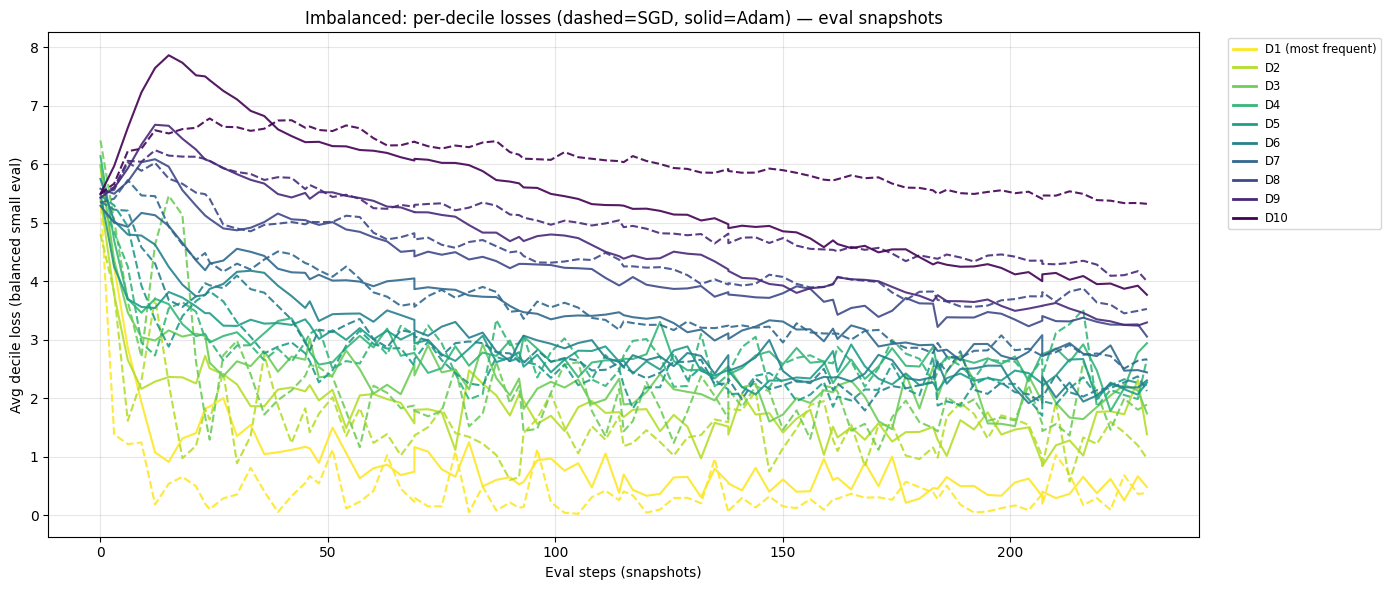

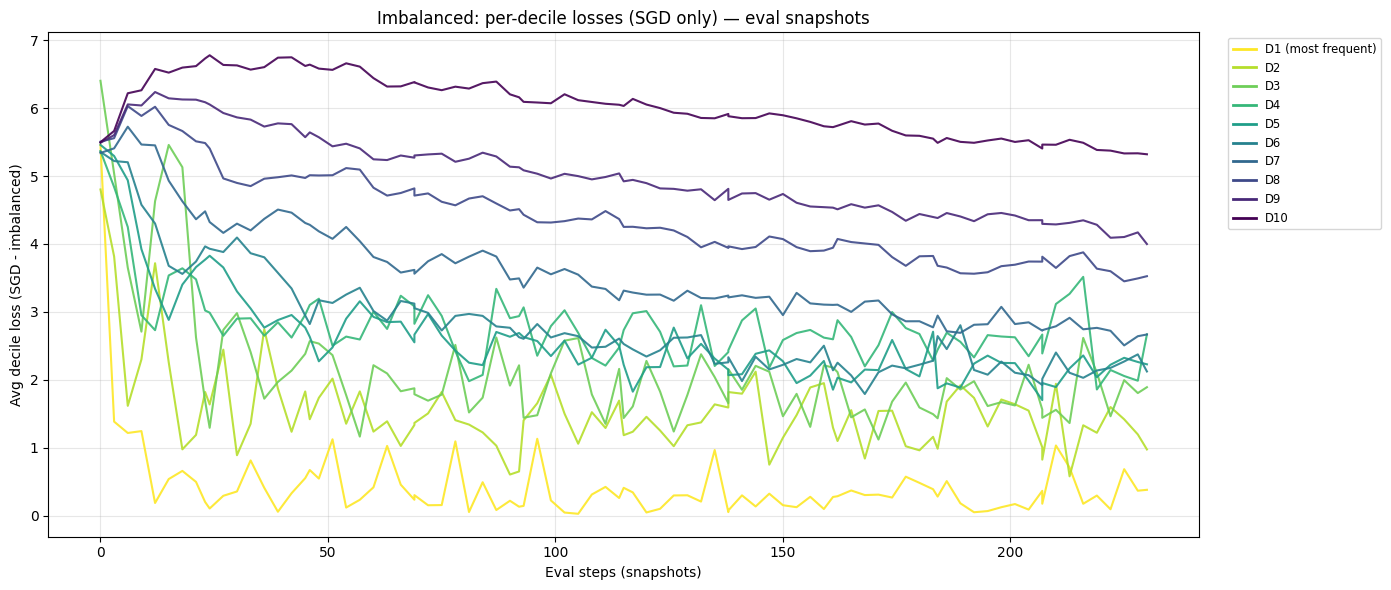

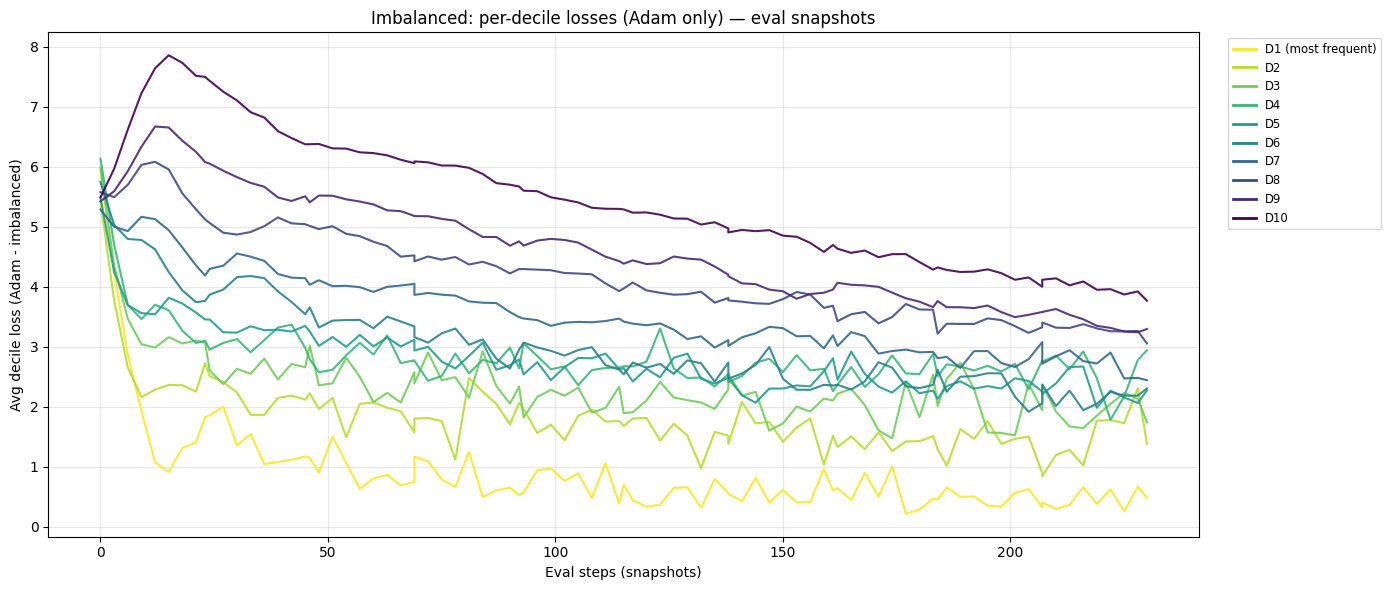

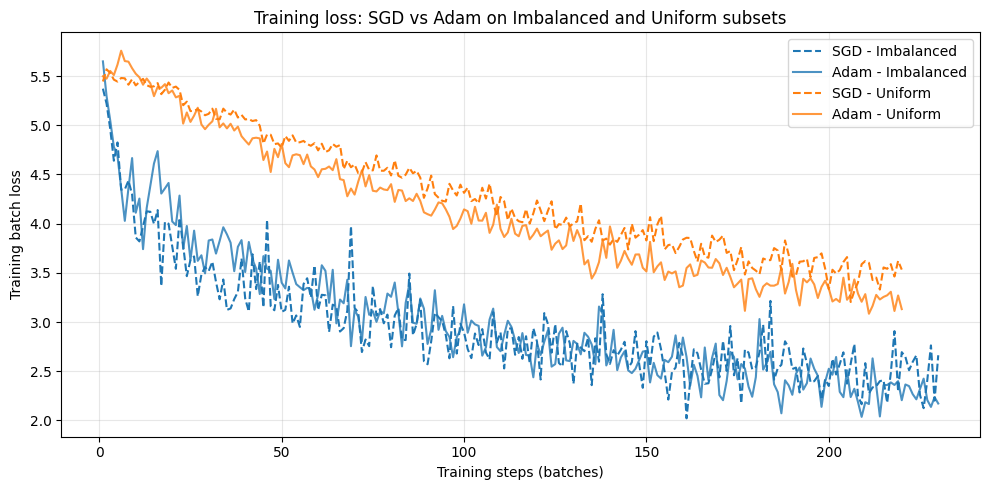

✅ Done — plots generated from saved CSVs (aligned to eval/train steps).


In [ ]:
# Paste & run this in Colab to load saved files and replot results (updated for train/eval separation).
import os, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Where results were saved
RESULTS_DIRS = ['experiment_results', '.']  # check these paths

# expected file patterns (CSV names saved by your pipeline)
decile_files_expected = {
    'sgd_imbalanced': 'sgd_imbalanced_deciles.csv',
    'adam_imbalanced': 'adam_imbalanced_deciles.csv'
}
overall_files_expected = {
    'sgd_imbalanced': 'sgd_imbalanced_overall.csv',
    'adam_imbalanced': 'adam_imbalanced_overall.csv',
    'sgd_uniform': 'sgd_uniform_overall.csv',
    'adam_uniform': 'adam_uniform_overall.csv'
}

# helper to find file in likely directories
def find_file(fname):
    for d in RESULTS_DIRS:
        p = os.path.join(d, fname)
        if os.path.exists(p):
            return p
    return None

# If files missing, prompt upload
missing = []
for k,f in list(decile_files_expected.items()) + list(overall_files_expected.items()):
    if find_file((f if isinstance(f,str) else f[1])) is None:
        missing.append(f if isinstance(f,str) else f[1])

if len(missing) > 0:
    print("Some result files not found locally. You can upload them now (select the CSV files you saved).")
    from google.colab import files
    uploaded = files.upload()  # user selects files
    # save them to working dir
    for name, data in uploaded.items():
        with open(name, 'wb') as fh:
            fh.write(data)
    print("Uploaded files saved to working dir.")

# Now load decile CSVs (imbalanced sgd/adam)
def load_decile_csv(opt_dataset):
    fname = decile_files_expected[opt_dataset]
    p = find_file(fname) or fname
    if not os.path.exists(p):
        raise FileNotFoundError(f"Decile CSV not found: {fname}")
    df = pd.read_csv(p)
    eval_steps = df['Step'].to_numpy()
    deciles = df.drop(columns=['Step']).to_numpy().T  # shape (num_deciles, T_eval)
    colnames = df.columns[1:].tolist()
    return eval_steps, deciles, colnames

def load_overall_csv(opt_dataset):
    fname = overall_files_expected[opt_dataset]
    p = find_file(fname) or fname
    if not os.path.exists(p):
        raise FileNotFoundError(f"Overall CSV not found: {fname}")
    df = pd.read_csv(p)
    train_steps = df['Step'].to_numpy()
    train_losses = df['Overall_Loss'].to_numpy()
    return train_steps, train_losses

# load files
eval_sgd_steps, decile_sgd_imb, decile_names = load_decile_csv('sgd_imbalanced')
eval_adam_steps, decile_adam_imb, _ = load_decile_csv('adam_imbalanced')

train_sgd_steps, sgd_train_losses = load_overall_csv('sgd_imbalanced')
train_adam_steps, adam_train_losses = load_overall_csv('adam_imbalanced')
train_sgd_uni_steps, sgd_uni_train_losses = load_overall_csv('sgd_uniform')
train_adam_uni_steps, adam_uni_train_losses = load_overall_csv('adam_uniform')

# Basic sanity
num_deciles = decile_sgd_imb.shape[0]
print(f"Loaded decile arrays shape: {decile_sgd_imb.shape}, {decile_adam_imb.shape}")
print(f"Train losses lengths: {len(sgd_train_losses)}, {len(adam_train_losses)}")

# assume decile columns are ordered most -> least frequent (Decile_1 = most)
most_freq_decile = 0

# colormap (most frequent darker)
cmap = plt.get_cmap('viridis_r', num_deciles)

# ---------- Plot 1: per-decile losses (SGD vs Adam, same plot) ----------
plt.figure(figsize=(14,6))
for d in range(num_deciles):
    color = cmap(d / max(1, num_deciles - 1))
    y_sgd = np.ma.masked_invalid(decile_sgd_imb[d])
    y_adam = np.ma.masked_invalid(decile_adam_imb[d])
    plt.plot(eval_sgd_steps, y_sgd, '--', color=color, alpha=0.9)   # use eval steps for deciles
    plt.plot(eval_adam_steps, y_adam, '-', color=color, alpha=0.9)

plt.xlabel('Eval steps (snapshots)')
plt.ylabel('Avg decile loss (balanced small eval)')
plt.title('Imbalanced: per-decile losses (dashed=SGD, solid=Adam) — eval snapshots')
plt.grid(True, alpha=0.3)

# legend showing decile colors and mark most frequent
legend_elements = []
for d in range(num_deciles):
    color = cmap(d / max(1, num_deciles - 1))
    lab = f'D{d+1}'
    if d == most_freq_decile:
        lab += ' (most frequent)'
    legend_elements.append(Line2D([0], [0], color=color, lw=2, label=lab))
plt.legend(handles=legend_elements, bbox_to_anchor=(1.02,1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

# ---------- Plot 2: per-decile losses (SGD only) ----------
plt.figure(figsize=(14,6))
for d in range(num_deciles):
    color = cmap(d / max(1, num_deciles - 1))
    y_sgd = np.ma.masked_invalid(decile_sgd_imb[d])
    plt.plot(eval_sgd_steps, y_sgd, '-', color=color, alpha=0.9)

plt.xlabel('Eval steps (snapshots)')
plt.ylabel('Avg decile loss (SGD - imbalanced)')
plt.title('Imbalanced: per-decile losses (SGD only) — eval snapshots')
plt.grid(True, alpha=0.3)
legend_elements = []
for d in range(num_deciles):
    color = cmap(d / max(1, num_deciles - 1))
    lab = f'D{d+1}'
    if d == most_freq_decile:
        lab += ' (most frequent)'
    legend_elements.append(Line2D([0], [0], color=color, lw=2, label=lab))
plt.legend(handles=legend_elements, bbox_to_anchor=(1.02,1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

# ---------- Plot 3: per-decile losses (Adam only) ----------
plt.figure(figsize=(14,6))
for d in range(num_deciles):
    color = cmap(d / max(1, num_deciles - 1))
    y_adam = np.ma.masked_invalid(decile_adam_imb[d])
    plt.plot(eval_adam_steps, y_adam, '-', color=color, alpha=0.9)

plt.xlabel('Eval steps (snapshots)')
plt.ylabel('Avg decile loss (Adam - imbalanced)')
plt.title('Imbalanced: per-decile losses (Adam only) — eval snapshots')
plt.grid(True, alpha=0.3)
legend_elements = []
for d in range(num_deciles):
    color = cmap(d / max(1, num_deciles - 1))
    lab = f'D{d+1}'
    if d == most_freq_decile:
        lab += ' (most frequent)'
    legend_elements.append(Line2D([0], [0], color=color, lw=2, label=lab))
plt.legend(handles=legend_elements, bbox_to_anchor=(1.02,1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

# ---------- Plot 4: overall training loss comparison (train steps) ----------
plt.figure(figsize=(10,5))
plt.plot(train_sgd_steps, sgd_train_losses, '--', label='SGD - Imbalanced', color='tab:blue')
plt.plot(train_adam_steps, adam_train_losses, '-', label='Adam - Imbalanced', color='tab:blue', alpha=0.8)
plt.plot(train_sgd_uni_steps, sgd_uni_train_losses, '--', label='SGD - Uniform', color='tab:orange')
plt.plot(train_adam_uni_steps, adam_uni_train_losses, '-', label='Adam - Uniform', color='tab:orange', alpha=0.8)
plt.xlabel('Training steps (batches)')
plt.ylabel('Training batch loss')
plt.title('Training loss: SGD vs Adam on Imbalanced and Uniform subsets')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("✅ Done — plots generated from saved CSVs (aligned to eval/train steps).")


# Visualization of Nonlinear Preconditioners


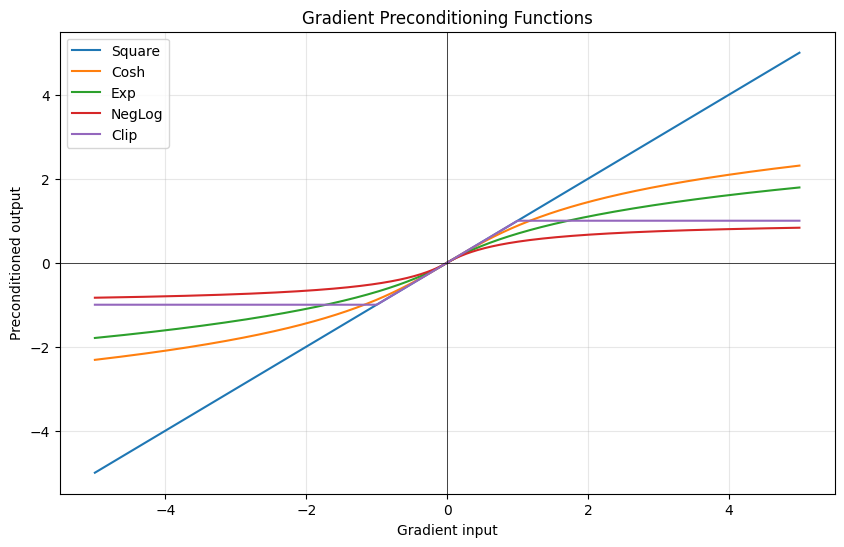

In [ ]:
import torch
import matplotlib.pyplot as plt

x = torch.linspace(-5, 5, 500)

preconditioners = {
    "Square": lambda x: x,
    "Cosh": lambda x: torch.arcsinh(x),
    "Exp": lambda x: torch.sign(x) * torch.log1p(torch.abs(x)),
    "NegLog": lambda x: x / (1 + torch.abs(x)),
    "Clip": lambda x: torch.clamp(x, -1, 1),
}

plt.figure(figsize=(10,6))
for name, f in preconditioners.items():
    plt.plot(x.numpy(), f(x).numpy(), label=name)
plt.axhline(0, color='black', lw=0.5)
plt.axvline(0, color='black', lw=0.5)
plt.xlabel("Gradient input")
plt.ylabel("Preconditioned output")
plt.title("Gradient Preconditioning Functions")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


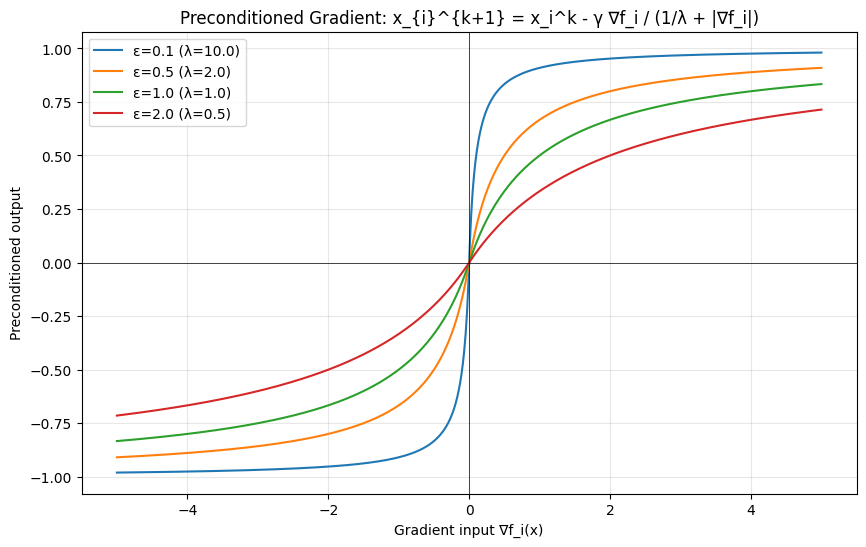

In [ ]:
import torch
import matplotlib.pyplot as plt

# Gradient input
g = torch.linspace(-5, 5, 500)

# Choose epsilon values (lambda = 1/epsilon)
epsilons = [0.1, 0.5, 1.0, 2.0]
plt.figure(figsize=(10,6))

for eps in epsilons:
    lambda_ = 1/eps
    precond = g / (1/lambda_ + torch.abs(g))
    plt.plot(g.numpy(), precond.numpy(), label=f"ε={eps} (λ={lambda_:.1f})")

plt.axhline(0, color='black', lw=0.5)
plt.axvline(0, color='black', lw=0.5)
plt.xlabel("Gradient input ∇f_i(x)")
plt.ylabel("Preconditioned output")
plt.title("Preconditioned Gradient: x_{i}^{k+1} = x_i^k - γ ∇f_i / (1/λ + |∇f_i|)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


# Experiment 4: overparametrized linear network on synthetic random data


Device: cuda
Class counts summary: C=1000, total_train=7069, n1=1000, alpha=1.0
First 10 class sizes: [1000  500  333  250  200  166  142  125  111  100]
Train shape: (7069, 512) (7069,)
Decile sample counts (final): [1000  500  783  644  613  723  690  703  707  706] sum: 7069
Running: sgd
[Init] sgd: train_loss=6.9125


sgd EP1:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 2: train_loss=5.9480
  Eval @ step 4: train_loss=6.2293
  Eval @ step 6: train_loss=6.4471
  Eval @ step 8: train_loss=5.9970
  Eval @ step 10: train_loss=6.4300
  Eval @ step 12: train_loss=6.2861
  Eval @ step 14: train_loss=6.2395
[Epoch 1] sgd: train_loss=6.2395


sgd EP2:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 16: train_loss=5.3390
  Eval @ step 18: train_loss=5.2960
  Eval @ step 20: train_loss=5.9735
  Eval @ step 22: train_loss=5.6109
  Eval @ step 24: train_loss=6.1128
  Eval @ step 26: train_loss=5.5542
  Eval @ step 28: train_loss=5.4902
[Epoch 2] sgd: train_loss=5.4902


sgd EP3:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 30: train_loss=5.9026
  Eval @ step 32: train_loss=5.3480
  Eval @ step 34: train_loss=5.2741
  Eval @ step 36: train_loss=5.5111
  Eval @ step 38: train_loss=5.4709
  Eval @ step 40: train_loss=5.2134
  Eval @ step 42: train_loss=5.5129
[Epoch 3] sgd: train_loss=5.5129


sgd EP4:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 44: train_loss=5.4425
  Eval @ step 46: train_loss=5.2258
  Eval @ step 48: train_loss=5.8193
  Eval @ step 50: train_loss=5.5518
  Eval @ step 52: train_loss=5.5429
  Eval @ step 54: train_loss=4.8806
  Eval @ step 56: train_loss=5.1598
[Epoch 4] sgd: train_loss=5.1598


sgd EP5:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 58: train_loss=5.7394
  Eval @ step 60: train_loss=5.3092
  Eval @ step 62: train_loss=6.1212
  Eval @ step 64: train_loss=5.3652
  Eval @ step 66: train_loss=5.3760
  Eval @ step 68: train_loss=5.0945
  Eval @ step 70: train_loss=5.0095
[Epoch 5] sgd: train_loss=5.0095


sgd EP6:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 72: train_loss=4.9095
  Eval @ step 74: train_loss=4.9651
  Eval @ step 76: train_loss=4.8513
  Eval @ step 78: train_loss=4.7396
  Eval @ step 80: train_loss=4.7451
  Eval @ step 82: train_loss=4.6918
  Eval @ step 84: train_loss=4.6883
[Epoch 6] sgd: train_loss=4.6883


sgd EP7:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 86: train_loss=4.7047
  Eval @ step 88: train_loss=4.7125
  Eval @ step 90: train_loss=4.7627
  Eval @ step 92: train_loss=4.6705
  Eval @ step 94: train_loss=4.6633
  Eval @ step 96: train_loss=4.6188
  Eval @ step 98: train_loss=4.6240
[Epoch 7] sgd: train_loss=4.6240


sgd EP8:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 100: train_loss=4.6300
  Eval @ step 102: train_loss=4.6230
  Eval @ step 104: train_loss=4.6181
  Eval @ step 106: train_loss=4.6389
  Eval @ step 108: train_loss=4.5909
  Eval @ step 110: train_loss=4.5806
  Eval @ step 112: train_loss=4.5581
[Epoch 8] sgd: train_loss=4.5581


sgd EP9:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 114: train_loss=4.5541
  Eval @ step 116: train_loss=4.5415
  Eval @ step 118: train_loss=4.5340
  Eval @ step 120: train_loss=4.5404
  Eval @ step 122: train_loss=4.5547
  Eval @ step 124: train_loss=4.5078
  Eval @ step 126: train_loss=4.5126
[Epoch 9] sgd: train_loss=4.5126


sgd EP10:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 128: train_loss=4.4996
  Eval @ step 130: train_loss=4.4900
  Eval @ step 132: train_loss=4.5052
  Eval @ step 134: train_loss=4.4614
  Eval @ step 136: train_loss=4.4675
  Eval @ step 138: train_loss=4.4659
  Eval @ step 140: train_loss=4.4894
[Epoch 10] sgd: train_loss=4.4894


sgd EP11:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 142: train_loss=4.4668
  Eval @ step 144: train_loss=4.4753
  Eval @ step 146: train_loss=4.4598
  Eval @ step 148: train_loss=4.4106
  Eval @ step 150: train_loss=4.4271
  Eval @ step 152: train_loss=4.4198
  Eval @ step 154: train_loss=4.4019
[Epoch 11] sgd: train_loss=4.4019


sgd EP12:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 156: train_loss=4.3894
  Eval @ step 158: train_loss=4.3958
  Eval @ step 160: train_loss=4.3692
  Eval @ step 162: train_loss=4.3489
  Eval @ step 164: train_loss=4.3478
  Eval @ step 166: train_loss=4.3476
  Eval @ step 168: train_loss=4.3239
[Epoch 12] sgd: train_loss=4.3239


sgd EP13:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 170: train_loss=4.3283
  Eval @ step 172: train_loss=4.3189
  Eval @ step 174: train_loss=4.2996
  Eval @ step 176: train_loss=4.3051
  Eval @ step 178: train_loss=4.2835
  Eval @ step 180: train_loss=4.2850
  Eval @ step 182: train_loss=4.2685
[Epoch 13] sgd: train_loss=4.2685


sgd EP14:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 184: train_loss=4.2759
  Eval @ step 186: train_loss=4.2516
  Eval @ step 188: train_loss=4.2530
  Eval @ step 190: train_loss=4.2886
  Eval @ step 192: train_loss=4.2475
  Eval @ step 194: train_loss=4.2444
  Eval @ step 196: train_loss=4.2173
[Epoch 14] sgd: train_loss=4.2173


sgd EP15:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 198: train_loss=4.2338
  Eval @ step 200: train_loss=4.2433
  Eval @ step 202: train_loss=4.2664
  Eval @ step 204: train_loss=4.2323
  Eval @ step 206: train_loss=4.1926
  Eval @ step 208: train_loss=4.1740
  Eval @ step 210: train_loss=4.2062
[Epoch 15] sgd: train_loss=4.2062


sgd EP16:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 212: train_loss=4.1718
  Eval @ step 214: train_loss=4.1972
  Eval @ step 216: train_loss=4.1692
  Eval @ step 218: train_loss=4.1636
  Eval @ step 220: train_loss=4.1393
  Eval @ step 222: train_loss=4.1290
  Eval @ step 224: train_loss=4.1305
[Epoch 16] sgd: train_loss=4.1305


sgd EP17:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 226: train_loss=4.1203
  Eval @ step 228: train_loss=4.1043
  Eval @ step 230: train_loss=4.0967
  Eval @ step 232: train_loss=4.1195
  Eval @ step 234: train_loss=4.0760
  Eval @ step 236: train_loss=4.0826
  Eval @ step 238: train_loss=4.0848
[Epoch 17] sgd: train_loss=4.0848


sgd EP18:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 240: train_loss=4.0697
  Eval @ step 242: train_loss=4.0850
  Eval @ step 244: train_loss=4.0889
  Eval @ step 246: train_loss=4.0708
  Eval @ step 248: train_loss=4.0491
  Eval @ step 250: train_loss=4.0212
  Eval @ step 252: train_loss=4.0444
[Epoch 18] sgd: train_loss=4.0444


sgd EP19:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 254: train_loss=4.0628
  Eval @ step 256: train_loss=4.0561
  Eval @ step 258: train_loss=4.0070
  Eval @ step 260: train_loss=3.9976
  Eval @ step 262: train_loss=3.9999
  Eval @ step 264: train_loss=4.0099
  Eval @ step 266: train_loss=3.9875
[Epoch 19] sgd: train_loss=3.9875


sgd EP20:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 268: train_loss=3.9795
  Eval @ step 270: train_loss=3.9773
  Eval @ step 272: train_loss=3.9850
  Eval @ step 274: train_loss=3.9585
  Eval @ step 276: train_loss=3.9625
  Eval @ step 278: train_loss=3.9420
  Eval @ step 280: train_loss=3.9857
[Epoch 20] sgd: train_loss=3.9857
Running: adam
[Init] adam: train_loss=6.9141


adam EP1:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 2: train_loss=6.3998
  Eval @ step 4: train_loss=5.9803
  Eval @ step 6: train_loss=5.6500
  Eval @ step 8: train_loss=5.4019
  Eval @ step 10: train_loss=5.2255
  Eval @ step 12: train_loss=5.1053
  Eval @ step 14: train_loss=5.0355
[Epoch 1] adam: train_loss=5.0355


adam EP2:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 16: train_loss=5.0073
  Eval @ step 18: train_loss=5.0061
  Eval @ step 20: train_loss=5.0180
  Eval @ step 22: train_loss=5.0300
  Eval @ step 24: train_loss=5.0281
  Eval @ step 26: train_loss=5.0055
  Eval @ step 28: train_loss=4.9714
[Epoch 2] adam: train_loss=4.9714


adam EP3:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 30: train_loss=4.9393
  Eval @ step 32: train_loss=4.9173
  Eval @ step 34: train_loss=4.9051
  Eval @ step 36: train_loss=4.8973
  Eval @ step 38: train_loss=4.8887
  Eval @ step 40: train_loss=4.8765
  Eval @ step 42: train_loss=4.8598
[Epoch 3] adam: train_loss=4.8598


adam EP4:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 44: train_loss=4.8441
  Eval @ step 46: train_loss=4.8312
  Eval @ step 48: train_loss=4.8203
  Eval @ step 50: train_loss=4.8107
  Eval @ step 52: train_loss=4.8002
  Eval @ step 54: train_loss=4.7880
  Eval @ step 56: train_loss=4.7749
[Epoch 4] adam: train_loss=4.7749


adam EP5:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 58: train_loss=4.7633
  Eval @ step 60: train_loss=4.7534
  Eval @ step 62: train_loss=4.7437
  Eval @ step 64: train_loss=4.7341
  Eval @ step 66: train_loss=4.7235
  Eval @ step 68: train_loss=4.7113
  Eval @ step 70: train_loss=4.6974
[Epoch 5] adam: train_loss=4.6974


adam EP6:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 72: train_loss=4.6861
  Eval @ step 74: train_loss=4.6772
  Eval @ step 76: train_loss=4.6688
  Eval @ step 78: train_loss=4.6593
  Eval @ step 80: train_loss=4.6477
  Eval @ step 82: train_loss=4.6345
  Eval @ step 84: train_loss=4.6204
[Epoch 6] adam: train_loss=4.6204


adam EP7:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 86: train_loss=4.6092
  Eval @ step 88: train_loss=4.6009
  Eval @ step 90: train_loss=4.5933
  Eval @ step 92: train_loss=4.5833
  Eval @ step 94: train_loss=4.5712
  Eval @ step 96: train_loss=4.5583
  Eval @ step 98: train_loss=4.5441
[Epoch 7] adam: train_loss=4.5441


adam EP8:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 100: train_loss=4.5319
  Eval @ step 102: train_loss=4.5220
  Eval @ step 104: train_loss=4.5123
  Eval @ step 106: train_loss=4.5026
  Eval @ step 108: train_loss=4.4918
  Eval @ step 110: train_loss=4.4787
  Eval @ step 112: train_loss=4.4645
[Epoch 8] adam: train_loss=4.4645


adam EP9:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 114: train_loss=4.4534
  Eval @ step 116: train_loss=4.4448
  Eval @ step 118: train_loss=4.4349
  Eval @ step 120: train_loss=4.4231
  Eval @ step 122: train_loss=4.4108
  Eval @ step 124: train_loss=4.3984
  Eval @ step 126: train_loss=4.3851
[Epoch 9] adam: train_loss=4.3851


adam EP10:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 128: train_loss=4.3738
  Eval @ step 130: train_loss=4.3648
  Eval @ step 132: train_loss=4.3552
  Eval @ step 134: train_loss=4.3439
  Eval @ step 136: train_loss=4.3314
  Eval @ step 138: train_loss=4.3185
  Eval @ step 140: train_loss=4.3052
[Epoch 10] adam: train_loss=4.3052


adam EP11:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 142: train_loss=4.2957
  Eval @ step 144: train_loss=4.2872
  Eval @ step 146: train_loss=4.2762
  Eval @ step 148: train_loss=4.2641
  Eval @ step 150: train_loss=4.2524
  Eval @ step 152: train_loss=4.2400
  Eval @ step 154: train_loss=4.2263
[Epoch 11] adam: train_loss=4.2263


adam EP12:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 156: train_loss=4.2146
  Eval @ step 158: train_loss=4.2052
  Eval @ step 160: train_loss=4.1969
  Eval @ step 162: train_loss=4.1866
  Eval @ step 164: train_loss=4.1738
  Eval @ step 166: train_loss=4.1598
  Eval @ step 168: train_loss=4.1456
[Epoch 12] adam: train_loss=4.1456


adam EP13:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 170: train_loss=4.1343
  Eval @ step 172: train_loss=4.1256
  Eval @ step 174: train_loss=4.1160
  Eval @ step 176: train_loss=4.1060
  Eval @ step 178: train_loss=4.0935
  Eval @ step 180: train_loss=4.0792
  Eval @ step 182: train_loss=4.0636
[Epoch 13] adam: train_loss=4.0636


adam EP14:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 184: train_loss=4.0514
  Eval @ step 186: train_loss=4.0430
  Eval @ step 188: train_loss=4.0342
  Eval @ step 190: train_loss=4.0241
  Eval @ step 192: train_loss=4.0123
  Eval @ step 194: train_loss=3.9979
  Eval @ step 196: train_loss=3.9830
[Epoch 14] adam: train_loss=3.9830


adam EP15:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 198: train_loss=3.9712
  Eval @ step 200: train_loss=3.9618
  Eval @ step 202: train_loss=3.9539
  Eval @ step 204: train_loss=3.9455
  Eval @ step 206: train_loss=3.9340
  Eval @ step 208: train_loss=3.9187
  Eval @ step 210: train_loss=3.9030
[Epoch 15] adam: train_loss=3.9030


adam EP16:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 212: train_loss=3.8913
  Eval @ step 214: train_loss=3.8838
  Eval @ step 216: train_loss=3.8758
  Eval @ step 218: train_loss=3.8652
  Eval @ step 220: train_loss=3.8521
  Eval @ step 222: train_loss=3.8380
  Eval @ step 224: train_loss=3.8238
[Epoch 16] adam: train_loss=3.8238


adam EP17:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 226: train_loss=3.8128
  Eval @ step 228: train_loss=3.8032
  Eval @ step 230: train_loss=3.7930
  Eval @ step 232: train_loss=3.7825
  Eval @ step 234: train_loss=3.7709
  Eval @ step 236: train_loss=3.7572
  Eval @ step 238: train_loss=3.7433
[Epoch 17] adam: train_loss=3.7433


adam EP18:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 240: train_loss=3.7321
  Eval @ step 242: train_loss=3.7227
  Eval @ step 244: train_loss=3.7134
  Eval @ step 246: train_loss=3.7040
  Eval @ step 248: train_loss=3.6931
  Eval @ step 250: train_loss=3.6792
  Eval @ step 252: train_loss=3.6650
[Epoch 18] adam: train_loss=3.6650


adam EP19:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 254: train_loss=3.6530
  Eval @ step 256: train_loss=3.6437
  Eval @ step 258: train_loss=3.6348
  Eval @ step 260: train_loss=3.6255
  Eval @ step 262: train_loss=3.6144
  Eval @ step 264: train_loss=3.6018
  Eval @ step 266: train_loss=3.5879
[Epoch 19] adam: train_loss=3.5879


adam EP20:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 268: train_loss=3.5767
  Eval @ step 270: train_loss=3.5689
  Eval @ step 272: train_loss=3.5600
  Eval @ step 274: train_loss=3.5497
  Eval @ step 276: train_loss=3.5388
  Eval @ step 278: train_loss=3.5261
  Eval @ step 280: train_loss=3.5121
[Epoch 20] adam: train_loss=3.5121
Running: adamnomem
[Init] adamnomem: train_loss=6.9258


adamnomem EP1:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 2: train_loss=6.4147
  Eval @ step 4: train_loss=5.9664
  Eval @ step 6: train_loss=5.6145
  Eval @ step 8: train_loss=5.3439
  Eval @ step 10: train_loss=5.1649
  Eval @ step 12: train_loss=5.0641
  Eval @ step 14: train_loss=5.0353
[Epoch 1] adamnomem: train_loss=5.0353


adamnomem EP2:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 16: train_loss=5.0548
  Eval @ step 18: train_loss=5.0679
  Eval @ step 20: train_loss=5.0839
  Eval @ step 22: train_loss=5.1006
  Eval @ step 24: train_loss=5.1243
  Eval @ step 26: train_loss=5.1481
  Eval @ step 28: train_loss=5.1795
[Epoch 2] adamnomem: train_loss=5.1795


adamnomem EP3:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 30: train_loss=5.2003
  Eval @ step 32: train_loss=5.2218
  Eval @ step 34: train_loss=5.2503
  Eval @ step 36: train_loss=5.2633
  Eval @ step 38: train_loss=5.2904
  Eval @ step 40: train_loss=5.3179
  Eval @ step 42: train_loss=5.3430
[Epoch 3] adamnomem: train_loss=5.3430


adamnomem EP4:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 44: train_loss=5.3713
  Eval @ step 46: train_loss=5.4034
  Eval @ step 48: train_loss=5.4288
  Eval @ step 50: train_loss=5.4540
  Eval @ step 52: train_loss=5.4740
  Eval @ step 54: train_loss=5.4982
  Eval @ step 56: train_loss=5.5264
[Epoch 4] adamnomem: train_loss=5.5264


adamnomem EP5:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 58: train_loss=5.5543
  Eval @ step 60: train_loss=5.5754
  Eval @ step 62: train_loss=5.6015
  Eval @ step 64: train_loss=5.6339
  Eval @ step 66: train_loss=5.6560
  Eval @ step 68: train_loss=5.6784
  Eval @ step 70: train_loss=5.7088
[Epoch 5] adamnomem: train_loss=5.7088


adamnomem EP6:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 72: train_loss=5.7294
  Eval @ step 74: train_loss=5.7635
  Eval @ step 76: train_loss=5.7725
  Eval @ step 78: train_loss=5.8034
  Eval @ step 80: train_loss=5.8229
  Eval @ step 82: train_loss=5.8397
  Eval @ step 84: train_loss=5.8639
[Epoch 6] adamnomem: train_loss=5.8639


adamnomem EP7:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 86: train_loss=5.8825
  Eval @ step 88: train_loss=5.8983
  Eval @ step 90: train_loss=5.9081
  Eval @ step 92: train_loss=5.9255
  Eval @ step 94: train_loss=5.9400
  Eval @ step 96: train_loss=5.9475
  Eval @ step 98: train_loss=5.9753
[Epoch 7] adamnomem: train_loss=5.9753


adamnomem EP8:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 100: train_loss=5.9933
  Eval @ step 102: train_loss=6.0113
  Eval @ step 104: train_loss=6.0228
  Eval @ step 106: train_loss=6.0218
  Eval @ step 108: train_loss=6.0182
  Eval @ step 110: train_loss=6.0261
  Eval @ step 112: train_loss=6.0320
[Epoch 8] adamnomem: train_loss=6.0320


adamnomem EP9:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 114: train_loss=6.0446
  Eval @ step 116: train_loss=6.0587
  Eval @ step 118: train_loss=6.0623
  Eval @ step 120: train_loss=6.0783
  Eval @ step 122: train_loss=6.0812
  Eval @ step 124: train_loss=6.0807
  Eval @ step 126: train_loss=6.0832
[Epoch 9] adamnomem: train_loss=6.0832


adamnomem EP10:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 128: train_loss=6.0930
  Eval @ step 130: train_loss=6.0962
  Eval @ step 132: train_loss=6.1067
  Eval @ step 134: train_loss=6.0911
  Eval @ step 136: train_loss=6.0964
  Eval @ step 138: train_loss=6.1091
  Eval @ step 140: train_loss=6.1109
[Epoch 10] adamnomem: train_loss=6.1109


adamnomem EP11:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 142: train_loss=6.1162
  Eval @ step 144: train_loss=6.1114
  Eval @ step 146: train_loss=6.1131
  Eval @ step 148: train_loss=6.1140
  Eval @ step 150: train_loss=6.1255
  Eval @ step 152: train_loss=6.1248
  Eval @ step 154: train_loss=6.1285
[Epoch 11] adamnomem: train_loss=6.1285


adamnomem EP12:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 156: train_loss=6.1321
  Eval @ step 158: train_loss=6.1244
  Eval @ step 160: train_loss=6.1267
  Eval @ step 162: train_loss=6.1272
  Eval @ step 164: train_loss=6.1260
  Eval @ step 166: train_loss=6.1226
  Eval @ step 168: train_loss=6.1347
[Epoch 12] adamnomem: train_loss=6.1347


adamnomem EP13:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 170: train_loss=6.1410
  Eval @ step 172: train_loss=6.1358
  Eval @ step 174: train_loss=6.1322
  Eval @ step 176: train_loss=6.1358
  Eval @ step 178: train_loss=6.1366
  Eval @ step 180: train_loss=6.1284
  Eval @ step 182: train_loss=6.1339
[Epoch 13] adamnomem: train_loss=6.1339


adamnomem EP14:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 184: train_loss=6.1375
  Eval @ step 186: train_loss=6.1287
  Eval @ step 188: train_loss=6.1222
  Eval @ step 190: train_loss=6.1275
  Eval @ step 192: train_loss=6.1369
  Eval @ step 194: train_loss=6.1326
  Eval @ step 196: train_loss=6.1369
[Epoch 14] adamnomem: train_loss=6.1369


adamnomem EP15:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 198: train_loss=6.1368
  Eval @ step 200: train_loss=6.1330
  Eval @ step 202: train_loss=6.1249
  Eval @ step 204: train_loss=6.1201
  Eval @ step 206: train_loss=6.1202
  Eval @ step 208: train_loss=6.1217
  Eval @ step 210: train_loss=6.1210
[Epoch 15] adamnomem: train_loss=6.1210


adamnomem EP16:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 212: train_loss=6.1232
  Eval @ step 214: train_loss=6.1152
  Eval @ step 216: train_loss=6.1057
  Eval @ step 218: train_loss=6.1055
  Eval @ step 220: train_loss=6.1063
  Eval @ step 222: train_loss=6.1082
  Eval @ step 224: train_loss=6.1187
[Epoch 16] adamnomem: train_loss=6.1187


adamnomem EP17:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 226: train_loss=6.1128
  Eval @ step 228: train_loss=6.1123
  Eval @ step 230: train_loss=6.1065
  Eval @ step 232: train_loss=6.1103
  Eval @ step 234: train_loss=6.1085
  Eval @ step 236: train_loss=6.1124
  Eval @ step 238: train_loss=6.1091
[Epoch 17] adamnomem: train_loss=6.1091


adamnomem EP18:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 240: train_loss=6.1139
  Eval @ step 242: train_loss=6.1128
  Eval @ step 244: train_loss=6.1103
  Eval @ step 246: train_loss=6.1028
  Eval @ step 248: train_loss=6.0930
  Eval @ step 250: train_loss=6.0917
  Eval @ step 252: train_loss=6.0965
[Epoch 18] adamnomem: train_loss=6.0965


adamnomem EP19:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 254: train_loss=6.0900
  Eval @ step 256: train_loss=6.1042
  Eval @ step 258: train_loss=6.1064
  Eval @ step 260: train_loss=6.0974
  Eval @ step 262: train_loss=6.0947
  Eval @ step 264: train_loss=6.0958
  Eval @ step 266: train_loss=6.0840
[Epoch 19] adamnomem: train_loss=6.0840


adamnomem EP20:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 268: train_loss=6.0750
  Eval @ step 270: train_loss=6.0737
  Eval @ step 272: train_loss=6.0759
  Eval @ step 274: train_loss=6.0739
  Eval @ step 276: train_loss=6.0680
  Eval @ step 278: train_loss=6.0726
  Eval @ step 280: train_loss=6.0784
[Epoch 20] adamnomem: train_loss=6.0784
Running: adamnomomentum
[Init] adamnomomentum: train_loss=6.9471


adamnomomentum EP1:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 2: train_loss=6.4451
  Eval @ step 4: train_loss=6.0216
  Eval @ step 6: train_loss=5.7086
  Eval @ step 8: train_loss=5.4676
  Eval @ step 10: train_loss=5.3000
  Eval @ step 12: train_loss=5.1694
  Eval @ step 14: train_loss=5.0953
[Epoch 1] adamnomomentum: train_loss=5.0953


adamnomomentum EP2:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 16: train_loss=5.0433
  Eval @ step 18: train_loss=5.0032
  Eval @ step 20: train_loss=4.9833
  Eval @ step 22: train_loss=4.9622
  Eval @ step 24: train_loss=4.9499
  Eval @ step 26: train_loss=4.9365
  Eval @ step 28: train_loss=4.9272
[Epoch 2] adamnomomentum: train_loss=4.9272


adamnomomentum EP3:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 30: train_loss=4.9263
  Eval @ step 32: train_loss=4.9169
  Eval @ step 34: train_loss=4.9056
  Eval @ step 36: train_loss=4.8952
  Eval @ step 38: train_loss=4.8814
  Eval @ step 40: train_loss=4.8685
  Eval @ step 42: train_loss=4.8596
[Epoch 3] adamnomomentum: train_loss=4.8596


adamnomomentum EP4:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 44: train_loss=4.8583
  Eval @ step 46: train_loss=4.8490
  Eval @ step 48: train_loss=4.8368
  Eval @ step 50: train_loss=4.8281
  Eval @ step 52: train_loss=4.8106
  Eval @ step 54: train_loss=4.8031
  Eval @ step 56: train_loss=4.7904
[Epoch 4] adamnomomentum: train_loss=4.7904


adamnomomentum EP5:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 58: train_loss=4.7873
  Eval @ step 60: train_loss=4.7802
  Eval @ step 62: train_loss=4.7684
  Eval @ step 64: train_loss=4.7548
  Eval @ step 66: train_loss=4.7410
  Eval @ step 68: train_loss=4.7274
  Eval @ step 70: train_loss=4.7194
[Epoch 5] adamnomomentum: train_loss=4.7194


adamnomomentum EP6:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 72: train_loss=4.7158
  Eval @ step 74: train_loss=4.7079
  Eval @ step 76: train_loss=4.6933
  Eval @ step 78: train_loss=4.6845
  Eval @ step 80: train_loss=4.6701
  Eval @ step 82: train_loss=4.6547
  Eval @ step 84: train_loss=4.6477
[Epoch 6] adamnomomentum: train_loss=4.6477


adamnomomentum EP7:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 86: train_loss=4.6490
  Eval @ step 88: train_loss=4.6359
  Eval @ step 90: train_loss=4.6233
  Eval @ step 92: train_loss=4.6109
  Eval @ step 94: train_loss=4.5964
  Eval @ step 96: train_loss=4.5799
  Eval @ step 98: train_loss=4.5703
[Epoch 7] adamnomomentum: train_loss=4.5703


adamnomomentum EP8:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 100: train_loss=4.5725
  Eval @ step 102: train_loss=4.5601
  Eval @ step 104: train_loss=4.5505
  Eval @ step 106: train_loss=4.5321
  Eval @ step 108: train_loss=4.5189
  Eval @ step 110: train_loss=4.5075
  Eval @ step 112: train_loss=4.4966
[Epoch 8] adamnomomentum: train_loss=4.4966


adamnomomentum EP9:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 114: train_loss=4.4968
  Eval @ step 116: train_loss=4.4859
  Eval @ step 118: train_loss=4.4699
  Eval @ step 120: train_loss=4.4626
  Eval @ step 122: train_loss=4.4468
  Eval @ step 124: train_loss=4.4299
  Eval @ step 126: train_loss=4.4215
[Epoch 9] adamnomomentum: train_loss=4.4215


adamnomomentum EP10:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 128: train_loss=4.4199
  Eval @ step 130: train_loss=4.4077
  Eval @ step 132: train_loss=4.3969
  Eval @ step 134: train_loss=4.3818
  Eval @ step 136: train_loss=4.3721
  Eval @ step 138: train_loss=4.3584
  Eval @ step 140: train_loss=4.3461
[Epoch 10] adamnomomentum: train_loss=4.3461


adamnomomentum EP11:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 142: train_loss=4.3491
  Eval @ step 144: train_loss=4.3353
  Eval @ step 146: train_loss=4.3256
  Eval @ step 148: train_loss=4.3085
  Eval @ step 150: train_loss=4.2931
  Eval @ step 152: train_loss=4.2821
  Eval @ step 154: train_loss=4.2731
[Epoch 11] adamnomomentum: train_loss=4.2731


adamnomomentum EP12:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 156: train_loss=4.2629
  Eval @ step 158: train_loss=4.2611
  Eval @ step 160: train_loss=4.2430
  Eval @ step 162: train_loss=4.2313
  Eval @ step 164: train_loss=4.2204
  Eval @ step 166: train_loss=4.2019
  Eval @ step 168: train_loss=4.1900
[Epoch 12] adamnomomentum: train_loss=4.1900


adamnomomentum EP13:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 170: train_loss=4.1907
  Eval @ step 172: train_loss=4.1813
  Eval @ step 174: train_loss=4.1638
  Eval @ step 176: train_loss=4.1549
  Eval @ step 178: train_loss=4.1462
  Eval @ step 180: train_loss=4.1255
  Eval @ step 182: train_loss=4.1185
[Epoch 13] adamnomomentum: train_loss=4.1185


adamnomomentum EP14:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 184: train_loss=4.1139
  Eval @ step 186: train_loss=4.1064
  Eval @ step 188: train_loss=4.0853
  Eval @ step 190: train_loss=4.0767
  Eval @ step 192: train_loss=4.0650
  Eval @ step 194: train_loss=4.0500
  Eval @ step 196: train_loss=4.0397
[Epoch 14] adamnomomentum: train_loss=4.0397


adamnomomentum EP15:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 198: train_loss=4.0340
  Eval @ step 200: train_loss=4.0244
  Eval @ step 202: train_loss=4.0089
  Eval @ step 204: train_loss=3.9982
  Eval @ step 206: train_loss=3.9859
  Eval @ step 208: train_loss=3.9721
  Eval @ step 210: train_loss=3.9635
[Epoch 15] adamnomomentum: train_loss=3.9635


adamnomomentum EP16:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 212: train_loss=3.9594
  Eval @ step 214: train_loss=3.9484
  Eval @ step 216: train_loss=3.9358
  Eval @ step 218: train_loss=3.9199
  Eval @ step 220: train_loss=3.9071
  Eval @ step 222: train_loss=3.8917
  Eval @ step 224: train_loss=3.8837
[Epoch 16] adamnomomentum: train_loss=3.8837


adamnomomentum EP17:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 226: train_loss=3.8839
  Eval @ step 228: train_loss=3.8675
  Eval @ step 230: train_loss=3.8600
  Eval @ step 232: train_loss=3.8427
  Eval @ step 234: train_loss=3.8308
  Eval @ step 236: train_loss=3.8183
  Eval @ step 238: train_loss=3.8082
[Epoch 17] adamnomomentum: train_loss=3.8082


adamnomomentum EP18:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 240: train_loss=3.8038
  Eval @ step 242: train_loss=3.7937
  Eval @ step 244: train_loss=3.7823
  Eval @ step 246: train_loss=3.7682
  Eval @ step 248: train_loss=3.7562
  Eval @ step 250: train_loss=3.7472
  Eval @ step 252: train_loss=3.7321
[Epoch 18] adamnomomentum: train_loss=3.7321


adamnomomentum EP19:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 254: train_loss=3.7282
  Eval @ step 256: train_loss=3.7222
  Eval @ step 258: train_loss=3.7074
  Eval @ step 260: train_loss=3.6940
  Eval @ step 262: train_loss=3.6804
  Eval @ step 264: train_loss=3.6645
  Eval @ step 266: train_loss=3.6552
[Epoch 19] adamnomomentum: train_loss=3.6552


adamnomomentum EP20:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 268: train_loss=3.6514
  Eval @ step 270: train_loss=3.6430
  Eval @ step 272: train_loss=3.6343
  Eval @ step 274: train_loss=3.6168
  Eval @ step 276: train_loss=3.6039
  Eval @ step 278: train_loss=3.5912
  Eval @ step 280: train_loss=3.5821
[Epoch 20] adamnomomentum: train_loss=3.5821
Running: clip
[Init] clip: train_loss=6.9538


clip EP1:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 2: train_loss=6.1732
  Eval @ step 4: train_loss=5.8113
  Eval @ step 6: train_loss=5.6421
  Eval @ step 8: train_loss=5.5211
  Eval @ step 10: train_loss=5.4432
  Eval @ step 12: train_loss=5.3985
  Eval @ step 14: train_loss=5.3590
[Epoch 1] clip: train_loss=5.3590


clip EP2:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 16: train_loss=5.3148
  Eval @ step 18: train_loss=5.2832
  Eval @ step 20: train_loss=5.2612
  Eval @ step 22: train_loss=5.2398
  Eval @ step 24: train_loss=5.2253
  Eval @ step 26: train_loss=5.2058
  Eval @ step 28: train_loss=5.1946
[Epoch 2] clip: train_loss=5.1946


clip EP3:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 30: train_loss=5.1788
  Eval @ step 32: train_loss=5.1826
  Eval @ step 34: train_loss=5.1591
  Eval @ step 36: train_loss=5.1500
  Eval @ step 38: train_loss=5.1465
  Eval @ step 40: train_loss=5.1407
  Eval @ step 42: train_loss=5.1512
[Epoch 3] clip: train_loss=5.1512


clip EP4:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 44: train_loss=5.1349
  Eval @ step 46: train_loss=5.1148
  Eval @ step 48: train_loss=5.1067
  Eval @ step 50: train_loss=5.1031
  Eval @ step 52: train_loss=5.1020
  Eval @ step 54: train_loss=5.0893
  Eval @ step 56: train_loss=5.0870
[Epoch 4] clip: train_loss=5.0870


clip EP5:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 58: train_loss=5.0814
  Eval @ step 60: train_loss=5.0798
  Eval @ step 62: train_loss=5.0752
  Eval @ step 64: train_loss=5.0782
  Eval @ step 66: train_loss=5.0716
  Eval @ step 68: train_loss=5.0652
  Eval @ step 70: train_loss=5.0660
[Epoch 5] clip: train_loss=5.0660


clip EP6:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 72: train_loss=5.0658
  Eval @ step 74: train_loss=5.0566
  Eval @ step 76: train_loss=5.0541
  Eval @ step 78: train_loss=5.0460
  Eval @ step 80: train_loss=5.0471
  Eval @ step 82: train_loss=5.0402
  Eval @ step 84: train_loss=5.0444
[Epoch 6] clip: train_loss=5.0444


clip EP7:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 86: train_loss=5.0349
  Eval @ step 88: train_loss=5.0316
  Eval @ step 90: train_loss=5.0318
  Eval @ step 92: train_loss=5.0276
  Eval @ step 94: train_loss=5.0252
  Eval @ step 96: train_loss=5.0245
  Eval @ step 98: train_loss=5.0220
[Epoch 7] clip: train_loss=5.0220


clip EP8:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 100: train_loss=5.0184
  Eval @ step 102: train_loss=5.0226
  Eval @ step 104: train_loss=5.0393
  Eval @ step 106: train_loss=5.0153
  Eval @ step 108: train_loss=5.0219
  Eval @ step 110: train_loss=5.0084
  Eval @ step 112: train_loss=5.0041
[Epoch 8] clip: train_loss=5.0041


clip EP9:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 114: train_loss=5.0042
  Eval @ step 116: train_loss=5.0033
  Eval @ step 118: train_loss=5.0010
  Eval @ step 120: train_loss=5.0002
  Eval @ step 122: train_loss=4.9958
  Eval @ step 124: train_loss=4.9932
  Eval @ step 126: train_loss=4.9933
[Epoch 9] clip: train_loss=4.9933


clip EP10:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 128: train_loss=4.9908
  Eval @ step 130: train_loss=4.9907
  Eval @ step 132: train_loss=4.9870
  Eval @ step 134: train_loss=4.9849
  Eval @ step 136: train_loss=4.9835
  Eval @ step 138: train_loss=4.9809
  Eval @ step 140: train_loss=4.9791
[Epoch 10] clip: train_loss=4.9791


clip EP11:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 142: train_loss=4.9854
  Eval @ step 144: train_loss=4.9769
  Eval @ step 146: train_loss=4.9751
  Eval @ step 148: train_loss=4.9762
  Eval @ step 150: train_loss=4.9817
  Eval @ step 152: train_loss=4.9825
  Eval @ step 154: train_loss=4.9716
[Epoch 11] clip: train_loss=4.9716


clip EP12:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 156: train_loss=4.9697
  Eval @ step 158: train_loss=4.9672
  Eval @ step 160: train_loss=4.9680
  Eval @ step 162: train_loss=4.9646
  Eval @ step 164: train_loss=4.9658
  Eval @ step 166: train_loss=4.9644
  Eval @ step 168: train_loss=4.9657
[Epoch 12] clip: train_loss=4.9657


clip EP13:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 170: train_loss=4.9709
  Eval @ step 172: train_loss=4.9643
  Eval @ step 174: train_loss=4.9543
  Eval @ step 176: train_loss=4.9549
  Eval @ step 178: train_loss=4.9539
  Eval @ step 180: train_loss=4.9523
  Eval @ step 182: train_loss=4.9484
[Epoch 13] clip: train_loss=4.9484


clip EP14:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 184: train_loss=4.9484
  Eval @ step 186: train_loss=4.9570
  Eval @ step 188: train_loss=4.9491
  Eval @ step 190: train_loss=4.9434
  Eval @ step 192: train_loss=4.9495
  Eval @ step 194: train_loss=4.9413
  Eval @ step 196: train_loss=4.9404
[Epoch 14] clip: train_loss=4.9404


clip EP15:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 198: train_loss=4.9421
  Eval @ step 200: train_loss=4.9375
  Eval @ step 202: train_loss=4.9387
  Eval @ step 204: train_loss=4.9356
  Eval @ step 206: train_loss=4.9353
  Eval @ step 208: train_loss=4.9318
  Eval @ step 210: train_loss=4.9301
[Epoch 15] clip: train_loss=4.9301


clip EP16:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 212: train_loss=4.9370
  Eval @ step 214: train_loss=4.9325
  Eval @ step 216: train_loss=4.9282
  Eval @ step 218: train_loss=4.9251
  Eval @ step 220: train_loss=4.9241
  Eval @ step 222: train_loss=4.9233
  Eval @ step 224: train_loss=4.9243
[Epoch 16] clip: train_loss=4.9243


clip EP17:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 226: train_loss=4.9271
  Eval @ step 228: train_loss=4.9224
  Eval @ step 230: train_loss=4.9223
  Eval @ step 232: train_loss=4.9218
  Eval @ step 234: train_loss=4.9160
  Eval @ step 236: train_loss=4.9153
  Eval @ step 238: train_loss=4.9163
[Epoch 17] clip: train_loss=4.9163


clip EP18:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 240: train_loss=4.9194
  Eval @ step 242: train_loss=4.9157
  Eval @ step 244: train_loss=4.9117
  Eval @ step 246: train_loss=4.9098
  Eval @ step 248: train_loss=4.9078
  Eval @ step 250: train_loss=4.9298
  Eval @ step 252: train_loss=4.9087
[Epoch 18] clip: train_loss=4.9087


clip EP19:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 254: train_loss=4.9125
  Eval @ step 256: train_loss=4.9058
  Eval @ step 258: train_loss=4.9038
  Eval @ step 260: train_loss=4.9003
  Eval @ step 262: train_loss=4.9001
  Eval @ step 264: train_loss=4.9049
  Eval @ step 266: train_loss=4.8981
[Epoch 19] clip: train_loss=4.8981


clip EP20:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 268: train_loss=4.9088
  Eval @ step 270: train_loss=4.8956
  Eval @ step 272: train_loss=4.8948
  Eval @ step 274: train_loss=4.8938
  Eval @ step 276: train_loss=4.8928
  Eval @ step 278: train_loss=4.9104
  Eval @ step 280: train_loss=4.9005
[Epoch 20] clip: train_loss=4.9005
Running: ihgd
[Init] ihgd: train_loss=6.9144


ihgd EP1:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 2: train_loss=6.3580
  Eval @ step 4: train_loss=5.9268
  Eval @ step 6: train_loss=5.7176
  Eval @ step 8: train_loss=5.5904
  Eval @ step 10: train_loss=5.5112
  Eval @ step 12: train_loss=5.4430
  Eval @ step 14: train_loss=5.3918
[Epoch 1] ihgd: train_loss=5.3918


ihgd EP2:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 16: train_loss=5.3551
  Eval @ step 18: train_loss=5.3209
  Eval @ step 20: train_loss=5.2905
  Eval @ step 22: train_loss=5.2680
  Eval @ step 24: train_loss=5.2524
  Eval @ step 26: train_loss=5.2316
  Eval @ step 28: train_loss=5.2298
[Epoch 2] ihgd: train_loss=5.2298


ihgd EP3:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 30: train_loss=5.2081
  Eval @ step 32: train_loss=5.1969
  Eval @ step 34: train_loss=5.1793
  Eval @ step 36: train_loss=5.1677
  Eval @ step 38: train_loss=5.1615
  Eval @ step 40: train_loss=5.1601
  Eval @ step 42: train_loss=5.1422
[Epoch 3] ihgd: train_loss=5.1422


ihgd EP4:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 44: train_loss=5.1468
  Eval @ step 46: train_loss=5.1264
  Eval @ step 48: train_loss=5.1227
  Eval @ step 50: train_loss=5.1149
  Eval @ step 52: train_loss=5.1191
  Eval @ step 54: train_loss=5.1070
  Eval @ step 56: train_loss=5.0995
[Epoch 4] ihgd: train_loss=5.0995


ihgd EP5:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 58: train_loss=5.0946
  Eval @ step 60: train_loss=5.0905
  Eval @ step 62: train_loss=5.0928
  Eval @ step 64: train_loss=5.0815
  Eval @ step 66: train_loss=5.0931
  Eval @ step 68: train_loss=5.0880
  Eval @ step 70: train_loss=5.0719
[Epoch 5] ihgd: train_loss=5.0719


ihgd EP6:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 72: train_loss=5.0660
  Eval @ step 74: train_loss=5.0621
  Eval @ step 76: train_loss=5.0607
  Eval @ step 78: train_loss=5.0579
  Eval @ step 80: train_loss=5.0537
  Eval @ step 82: train_loss=5.0549
  Eval @ step 84: train_loss=5.0465
[Epoch 6] ihgd: train_loss=5.0465


ihgd EP7:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 86: train_loss=5.0480
  Eval @ step 88: train_loss=5.0459
  Eval @ step 90: train_loss=5.0398
  Eval @ step 92: train_loss=5.0393
  Eval @ step 94: train_loss=5.0358
  Eval @ step 96: train_loss=5.0336
  Eval @ step 98: train_loss=5.0297
[Epoch 7] ihgd: train_loss=5.0297


ihgd EP8:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 100: train_loss=5.0286
  Eval @ step 102: train_loss=5.0256
  Eval @ step 104: train_loss=5.0229
  Eval @ step 106: train_loss=5.0196
  Eval @ step 108: train_loss=5.0188
  Eval @ step 110: train_loss=5.0201
  Eval @ step 112: train_loss=5.0243
[Epoch 8] ihgd: train_loss=5.0243


ihgd EP9:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 114: train_loss=5.0122
  Eval @ step 116: train_loss=5.0105
  Eval @ step 118: train_loss=5.0082
  Eval @ step 120: train_loss=5.0085
  Eval @ step 122: train_loss=5.0055
  Eval @ step 124: train_loss=5.0026
  Eval @ step 126: train_loss=5.0018
[Epoch 9] ihgd: train_loss=5.0018


ihgd EP10:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 128: train_loss=5.0165
  Eval @ step 130: train_loss=5.0082
  Eval @ step 132: train_loss=4.9957
  Eval @ step 134: train_loss=4.9977
  Eval @ step 136: train_loss=5.0096
  Eval @ step 138: train_loss=4.9907
  Eval @ step 140: train_loss=4.9889
[Epoch 10] ihgd: train_loss=4.9889


ihgd EP11:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 142: train_loss=4.9898
  Eval @ step 144: train_loss=4.9893
  Eval @ step 146: train_loss=4.9862
  Eval @ step 148: train_loss=4.9846
  Eval @ step 150: train_loss=4.9821
  Eval @ step 152: train_loss=4.9839
  Eval @ step 154: train_loss=4.9801
[Epoch 11] ihgd: train_loss=4.9801


ihgd EP12:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 156: train_loss=4.9788
  Eval @ step 158: train_loss=4.9855
  Eval @ step 160: train_loss=4.9736
  Eval @ step 162: train_loss=4.9726
  Eval @ step 164: train_loss=4.9705
  Eval @ step 166: train_loss=4.9696
  Eval @ step 168: train_loss=4.9708
[Epoch 12] ihgd: train_loss=4.9708


ihgd EP13:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 170: train_loss=4.9690
  Eval @ step 172: train_loss=4.9669
  Eval @ step 174: train_loss=4.9637
  Eval @ step 176: train_loss=4.9636
  Eval @ step 178: train_loss=4.9674
  Eval @ step 180: train_loss=4.9613
  Eval @ step 182: train_loss=4.9589
[Epoch 13] ihgd: train_loss=4.9589


ihgd EP14:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 184: train_loss=4.9624
  Eval @ step 186: train_loss=4.9591
  Eval @ step 188: train_loss=4.9553
  Eval @ step 190: train_loss=4.9591
  Eval @ step 192: train_loss=4.9623
  Eval @ step 194: train_loss=4.9508
  Eval @ step 196: train_loss=4.9577
[Epoch 14] ihgd: train_loss=4.9577


ihgd EP15:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 198: train_loss=4.9594
  Eval @ step 200: train_loss=4.9504
  Eval @ step 202: train_loss=4.9504
  Eval @ step 204: train_loss=4.9495
  Eval @ step 206: train_loss=4.9442
  Eval @ step 208: train_loss=4.9476
  Eval @ step 210: train_loss=4.9482
[Epoch 15] ihgd: train_loss=4.9482


ihgd EP16:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 212: train_loss=4.9416
  Eval @ step 214: train_loss=4.9383
  Eval @ step 216: train_loss=4.9399
  Eval @ step 218: train_loss=4.9443
  Eval @ step 220: train_loss=4.9419
  Eval @ step 222: train_loss=4.9377
  Eval @ step 224: train_loss=4.9318
[Epoch 16] ihgd: train_loss=4.9318


ihgd EP17:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 226: train_loss=4.9335
  Eval @ step 228: train_loss=4.9314
  Eval @ step 230: train_loss=4.9342
  Eval @ step 232: train_loss=4.9284
  Eval @ step 234: train_loss=4.9322
  Eval @ step 236: train_loss=4.9263
  Eval @ step 238: train_loss=4.9254
[Epoch 17] ihgd: train_loss=4.9254


ihgd EP18:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 240: train_loss=4.9395
  Eval @ step 242: train_loss=4.9211
  Eval @ step 244: train_loss=4.9269
  Eval @ step 246: train_loss=4.9195
  Eval @ step 248: train_loss=4.9275
  Eval @ step 250: train_loss=4.9181
  Eval @ step 252: train_loss=4.9191
[Epoch 18] ihgd: train_loss=4.9191


ihgd EP19:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 254: train_loss=4.9142
  Eval @ step 256: train_loss=4.9170
  Eval @ step 258: train_loss=4.9133
  Eval @ step 260: train_loss=4.9154
  Eval @ step 262: train_loss=4.9123
  Eval @ step 264: train_loss=4.9089
  Eval @ step 266: train_loss=4.9117
[Epoch 19] ihgd: train_loss=4.9117


ihgd EP20:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 268: train_loss=4.9074
  Eval @ step 270: train_loss=4.9171
  Eval @ step 272: train_loss=4.9102
  Eval @ step 274: train_loss=4.9104
  Eval @ step 276: train_loss=4.9168
  Eval @ step 278: train_loss=4.9052
  Eval @ step 280: train_loss=4.9069
[Epoch 20] ihgd: train_loss=4.9069
Running: ihgdm
[Init] ihgdm: train_loss=6.9068


ihgdm EP1:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 2: train_loss=6.8276
  Eval @ step 4: train_loss=6.6545
  Eval @ step 6: train_loss=6.4105
  Eval @ step 8: train_loss=6.1319
  Eval @ step 10: train_loss=5.9146
  Eval @ step 12: train_loss=5.8738
  Eval @ step 14: train_loss=5.8151
[Epoch 1] ihgdm: train_loss=5.8151


ihgdm EP2:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 16: train_loss=5.6406
  Eval @ step 18: train_loss=5.5666
  Eval @ step 20: train_loss=5.5477
  Eval @ step 22: train_loss=5.4952
  Eval @ step 24: train_loss=5.4337
  Eval @ step 26: train_loss=5.3787
  Eval @ step 28: train_loss=5.3450
[Epoch 2] ihgdm: train_loss=5.3450


ihgdm EP3:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 30: train_loss=5.3358
  Eval @ step 32: train_loss=5.3163
  Eval @ step 34: train_loss=5.2769
  Eval @ step 36: train_loss=5.2459
  Eval @ step 38: train_loss=5.2371
  Eval @ step 40: train_loss=5.2290
  Eval @ step 42: train_loss=5.2091
[Epoch 3] ihgdm: train_loss=5.2091


ihgdm EP4:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 44: train_loss=5.1857
  Eval @ step 46: train_loss=5.1754
  Eval @ step 48: train_loss=5.1739
  Eval @ step 50: train_loss=5.1627
  Eval @ step 52: train_loss=5.1450
  Eval @ step 54: train_loss=5.1370
  Eval @ step 56: train_loss=5.1321
[Epoch 4] ihgdm: train_loss=5.1321


ihgdm EP5:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 58: train_loss=5.1239
  Eval @ step 60: train_loss=5.1163
  Eval @ step 62: train_loss=5.1098
  Eval @ step 64: train_loss=5.1045
  Eval @ step 66: train_loss=5.0976
  Eval @ step 68: train_loss=5.0916
  Eval @ step 70: train_loss=5.0865
[Epoch 5] ihgdm: train_loss=5.0865


ihgdm EP6:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 72: train_loss=5.0823
  Eval @ step 74: train_loss=5.0789
  Eval @ step 76: train_loss=5.0752
  Eval @ step 78: train_loss=5.0709
  Eval @ step 80: train_loss=5.0668
  Eval @ step 82: train_loss=5.0636
  Eval @ step 84: train_loss=5.0610
[Epoch 6] ihgdm: train_loss=5.0610


ihgdm EP7:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 86: train_loss=5.0577
  Eval @ step 88: train_loss=5.0539
  Eval @ step 90: train_loss=5.0496
  Eval @ step 92: train_loss=5.0462
  Eval @ step 94: train_loss=5.0436
  Eval @ step 96: train_loss=5.0411
  Eval @ step 98: train_loss=5.0388
[Epoch 7] ihgdm: train_loss=5.0388


ihgdm EP8:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 100: train_loss=5.0356
  Eval @ step 102: train_loss=5.0333
  Eval @ step 104: train_loss=5.0317
  Eval @ step 106: train_loss=5.0293
  Eval @ step 108: train_loss=5.0264
  Eval @ step 110: train_loss=5.0243
  Eval @ step 112: train_loss=5.0232
[Epoch 8] ihgdm: train_loss=5.0232


ihgdm EP9:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 114: train_loss=5.0213
  Eval @ step 116: train_loss=5.0182
  Eval @ step 118: train_loss=5.0160
  Eval @ step 120: train_loss=5.0157
  Eval @ step 122: train_loss=5.0127
  Eval @ step 124: train_loss=5.0097
  Eval @ step 126: train_loss=5.0079
[Epoch 9] ihgdm: train_loss=5.0079


ihgdm EP10:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 128: train_loss=5.0061
  Eval @ step 130: train_loss=5.0044
  Eval @ step 132: train_loss=5.0028
  Eval @ step 134: train_loss=5.0020
  Eval @ step 136: train_loss=5.0005
  Eval @ step 138: train_loss=4.9970
  Eval @ step 140: train_loss=4.9975
[Epoch 10] ihgdm: train_loss=4.9975


ihgdm EP11:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 142: train_loss=4.9985
  Eval @ step 144: train_loss=4.9944
  Eval @ step 146: train_loss=4.9914
  Eval @ step 148: train_loss=4.9891
  Eval @ step 150: train_loss=4.9881
  Eval @ step 152: train_loss=4.9878
  Eval @ step 154: train_loss=4.9856
[Epoch 11] ihgdm: train_loss=4.9856


ihgdm EP12:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 156: train_loss=4.9827
  Eval @ step 158: train_loss=4.9815
  Eval @ step 160: train_loss=4.9799
  Eval @ step 162: train_loss=4.9782
  Eval @ step 164: train_loss=4.9766
  Eval @ step 166: train_loss=4.9748
  Eval @ step 168: train_loss=4.9737
[Epoch 12] ihgdm: train_loss=4.9737


ihgdm EP13:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 170: train_loss=4.9732
  Eval @ step 172: train_loss=4.9705
  Eval @ step 174: train_loss=4.9690
  Eval @ step 176: train_loss=4.9681
  Eval @ step 178: train_loss=4.9672
  Eval @ step 180: train_loss=4.9650
  Eval @ step 182: train_loss=4.9633
[Epoch 13] ihgdm: train_loss=4.9633


ihgdm EP14:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 184: train_loss=4.9621
  Eval @ step 186: train_loss=4.9612
  Eval @ step 188: train_loss=4.9603
  Eval @ step 190: train_loss=4.9590
  Eval @ step 192: train_loss=4.9577
  Eval @ step 194: train_loss=4.9574
  Eval @ step 196: train_loss=4.9544
[Epoch 14] ihgdm: train_loss=4.9544


ihgdm EP15:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 198: train_loss=4.9532
  Eval @ step 200: train_loss=4.9535
  Eval @ step 202: train_loss=4.9523
  Eval @ step 204: train_loss=4.9497
  Eval @ step 206: train_loss=4.9493
  Eval @ step 208: train_loss=4.9497
  Eval @ step 210: train_loss=4.9462
[Epoch 15] ihgdm: train_loss=4.9462


ihgdm EP16:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 212: train_loss=4.9439
  Eval @ step 214: train_loss=4.9430
  Eval @ step 216: train_loss=4.9429
  Eval @ step 218: train_loss=4.9422
  Eval @ step 220: train_loss=4.9403
  Eval @ step 222: train_loss=4.9383
  Eval @ step 224: train_loss=4.9369
[Epoch 16] ihgdm: train_loss=4.9369


ihgdm EP17:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 226: train_loss=4.9357
  Eval @ step 228: train_loss=4.9346
  Eval @ step 230: train_loss=4.9334
  Eval @ step 232: train_loss=4.9329
  Eval @ step 234: train_loss=4.9322
  Eval @ step 236: train_loss=4.9303
  Eval @ step 238: train_loss=4.9292
[Epoch 17] ihgdm: train_loss=4.9292


ihgdm EP18:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 240: train_loss=4.9290
  Eval @ step 242: train_loss=4.9286
  Eval @ step 244: train_loss=4.9255
  Eval @ step 246: train_loss=4.9235
  Eval @ step 248: train_loss=4.9227
  Eval @ step 250: train_loss=4.9231
  Eval @ step 252: train_loss=4.9226
[Epoch 18] ihgdm: train_loss=4.9226


ihgdm EP19:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 254: train_loss=4.9203
  Eval @ step 256: train_loss=4.9188
  Eval @ step 258: train_loss=4.9176
  Eval @ step 260: train_loss=4.9161
  Eval @ step 262: train_loss=4.9152
  Eval @ step 264: train_loss=4.9146
  Eval @ step 266: train_loss=4.9130
[Epoch 19] ihgdm: train_loss=4.9130


ihgdm EP20:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 268: train_loss=4.9120
  Eval @ step 270: train_loss=4.9108
  Eval @ step 272: train_loss=4.9100
  Eval @ step 274: train_loss=4.9084
  Eval @ step 276: train_loss=4.9076
  Eval @ step 278: train_loss=4.9076
  Eval @ step 280: train_loss=4.9069
[Epoch 20] ihgdm: train_loss=4.9069
Running: shgd
[Init] shgd: train_loss=6.9071


shgd EP1:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 2: train_loss=6.1670
  Eval @ step 4: train_loss=5.8121
  Eval @ step 6: train_loss=5.6332
  Eval @ step 8: train_loss=5.5260
  Eval @ step 10: train_loss=5.4428
  Eval @ step 12: train_loss=5.3921
  Eval @ step 14: train_loss=5.3466
[Epoch 1] shgd: train_loss=5.3466


shgd EP2:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 16: train_loss=5.3153
  Eval @ step 18: train_loss=5.2846
  Eval @ step 20: train_loss=5.2627
  Eval @ step 22: train_loss=5.2402
  Eval @ step 24: train_loss=5.2295
  Eval @ step 26: train_loss=5.2084
  Eval @ step 28: train_loss=5.1943
[Epoch 2] shgd: train_loss=5.1943


shgd EP3:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 30: train_loss=5.1797
  Eval @ step 32: train_loss=5.1670
  Eval @ step 34: train_loss=5.1582
  Eval @ step 36: train_loss=5.1527
  Eval @ step 38: train_loss=5.1480
  Eval @ step 40: train_loss=5.1325
  Eval @ step 42: train_loss=5.1274
[Epoch 3] shgd: train_loss=5.1274


shgd EP4:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 44: train_loss=5.1183
  Eval @ step 46: train_loss=5.1354
  Eval @ step 48: train_loss=5.1356
  Eval @ step 50: train_loss=5.1091
  Eval @ step 52: train_loss=5.0959
  Eval @ step 54: train_loss=5.0990
  Eval @ step 56: train_loss=5.0905
[Epoch 4] shgd: train_loss=5.0905


shgd EP5:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 58: train_loss=5.0833
  Eval @ step 60: train_loss=5.0785
  Eval @ step 62: train_loss=5.0817
  Eval @ step 64: train_loss=5.0696
  Eval @ step 66: train_loss=5.0746
  Eval @ step 68: train_loss=5.0623
  Eval @ step 70: train_loss=5.0740
[Epoch 5] shgd: train_loss=5.0740


shgd EP6:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 72: train_loss=5.0596
  Eval @ step 74: train_loss=5.0530
  Eval @ step 76: train_loss=5.0479
  Eval @ step 78: train_loss=5.0479
  Eval @ step 80: train_loss=5.0569
  Eval @ step 82: train_loss=5.0442
  Eval @ step 84: train_loss=5.0362
[Epoch 6] shgd: train_loss=5.0362


shgd EP7:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 86: train_loss=5.0363
  Eval @ step 88: train_loss=5.0351
  Eval @ step 90: train_loss=5.0345
  Eval @ step 92: train_loss=5.0291
  Eval @ step 94: train_loss=5.0247
  Eval @ step 96: train_loss=5.0292
  Eval @ step 98: train_loss=5.0211
[Epoch 7] shgd: train_loss=5.0211


shgd EP8:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 100: train_loss=5.0233
  Eval @ step 102: train_loss=5.0156
  Eval @ step 104: train_loss=5.0206
  Eval @ step 106: train_loss=5.0125
  Eval @ step 108: train_loss=5.0086
  Eval @ step 110: train_loss=5.0103
  Eval @ step 112: train_loss=5.0072
[Epoch 8] shgd: train_loss=5.0072


shgd EP9:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 114: train_loss=5.0123
  Eval @ step 116: train_loss=5.0020
  Eval @ step 118: train_loss=5.0023
  Eval @ step 120: train_loss=5.0004
  Eval @ step 122: train_loss=5.0010
  Eval @ step 124: train_loss=4.9944
  Eval @ step 126: train_loss=4.9937
[Epoch 9] shgd: train_loss=4.9937


shgd EP10:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 128: train_loss=4.9909
  Eval @ step 130: train_loss=4.9914
  Eval @ step 132: train_loss=4.9910
  Eval @ step 134: train_loss=4.9846
  Eval @ step 136: train_loss=4.9860
  Eval @ step 138: train_loss=5.0096
  Eval @ step 140: train_loss=4.9905
[Epoch 10] shgd: train_loss=4.9905


shgd EP11:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 142: train_loss=4.9815
  Eval @ step 144: train_loss=4.9802
  Eval @ step 146: train_loss=4.9820
  Eval @ step 148: train_loss=4.9749
  Eval @ step 150: train_loss=4.9732
  Eval @ step 152: train_loss=4.9708
  Eval @ step 154: train_loss=4.9698
[Epoch 11] shgd: train_loss=4.9698


shgd EP12:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 156: train_loss=4.9699
  Eval @ step 158: train_loss=4.9681
  Eval @ step 160: train_loss=4.9727
  Eval @ step 162: train_loss=4.9672
  Eval @ step 164: train_loss=4.9716
  Eval @ step 166: train_loss=4.9667
  Eval @ step 168: train_loss=4.9597
[Epoch 12] shgd: train_loss=4.9597


shgd EP13:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 170: train_loss=4.9590
  Eval @ step 172: train_loss=4.9650
  Eval @ step 174: train_loss=4.9598
  Eval @ step 176: train_loss=4.9649
  Eval @ step 178: train_loss=4.9539
  Eval @ step 180: train_loss=4.9497
  Eval @ step 182: train_loss=4.9689
[Epoch 13] shgd: train_loss=4.9689


shgd EP14:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 184: train_loss=4.9490
  Eval @ step 186: train_loss=4.9695
  Eval @ step 188: train_loss=4.9464
  Eval @ step 190: train_loss=4.9442
  Eval @ step 192: train_loss=4.9428
  Eval @ step 194: train_loss=4.9421
  Eval @ step 196: train_loss=4.9392
[Epoch 14] shgd: train_loss=4.9392


shgd EP15:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 198: train_loss=4.9509
  Eval @ step 200: train_loss=4.9367
  Eval @ step 202: train_loss=4.9364
  Eval @ step 204: train_loss=4.9370
  Eval @ step 206: train_loss=4.9415
  Eval @ step 208: train_loss=4.9355
  Eval @ step 210: train_loss=4.9386
[Epoch 15] shgd: train_loss=4.9386


shgd EP16:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 212: train_loss=4.9308
  Eval @ step 214: train_loss=4.9621
  Eval @ step 216: train_loss=4.9330
  Eval @ step 218: train_loss=4.9401
  Eval @ step 220: train_loss=4.9258
  Eval @ step 222: train_loss=4.9254
  Eval @ step 224: train_loss=4.9283
[Epoch 16] shgd: train_loss=4.9283


shgd EP17:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 226: train_loss=4.9260
  Eval @ step 228: train_loss=4.9299
  Eval @ step 230: train_loss=4.9191
  Eval @ step 232: train_loss=4.9232
  Eval @ step 234: train_loss=4.9178
  Eval @ step 236: train_loss=4.9232
  Eval @ step 238: train_loss=4.9283
[Epoch 17] shgd: train_loss=4.9283


shgd EP18:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 240: train_loss=4.9234
  Eval @ step 242: train_loss=4.9225
  Eval @ step 244: train_loss=4.9110
  Eval @ step 246: train_loss=4.9189
  Eval @ step 248: train_loss=4.9131
  Eval @ step 250: train_loss=4.9099
  Eval @ step 252: train_loss=4.9060
[Epoch 18] shgd: train_loss=4.9060


shgd EP19:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 254: train_loss=4.9060
  Eval @ step 256: train_loss=4.9061
  Eval @ step 258: train_loss=4.9052
  Eval @ step 260: train_loss=4.9032
  Eval @ step 262: train_loss=4.9020
  Eval @ step 264: train_loss=4.9012
  Eval @ step 266: train_loss=4.9023
[Epoch 19] shgd: train_loss=4.9023


shgd EP20:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 268: train_loss=4.9066
  Eval @ step 270: train_loss=4.9057
  Eval @ step 272: train_loss=4.8944
  Eval @ step 274: train_loss=4.8965
  Eval @ step 276: train_loss=4.8945
  Eval @ step 278: train_loss=4.8946
  Eval @ step 280: train_loss=4.8940
[Epoch 20] shgd: train_loss=4.8940
Running: shgdm
[Init] shgdm: train_loss=6.9382


shgdm EP1:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 2: train_loss=6.8211
  Eval @ step 4: train_loss=6.5667
  Eval @ step 6: train_loss=6.2150
  Eval @ step 8: train_loss=5.9224
  Eval @ step 10: train_loss=5.9294
  Eval @ step 12: train_loss=5.7667
  Eval @ step 14: train_loss=5.5939
[Epoch 1] shgdm: train_loss=5.5939


shgdm EP2:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 16: train_loss=5.5927
  Eval @ step 18: train_loss=5.5331
  Eval @ step 20: train_loss=5.4582
  Eval @ step 22: train_loss=5.3800
  Eval @ step 24: train_loss=5.3440
  Eval @ step 26: train_loss=5.3477
  Eval @ step 28: train_loss=5.3032
[Epoch 2] shgdm: train_loss=5.3032


shgdm EP3:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 30: train_loss=5.2482
  Eval @ step 32: train_loss=5.2328
  Eval @ step 34: train_loss=5.2373
  Eval @ step 36: train_loss=5.2217
  Eval @ step 38: train_loss=5.1843
  Eval @ step 40: train_loss=5.1661
  Eval @ step 42: train_loss=5.1789
[Epoch 3] shgdm: train_loss=5.1789


shgdm EP4:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 44: train_loss=5.1617
  Eval @ step 46: train_loss=5.1361
  Eval @ step 48: train_loss=5.1325
  Eval @ step 50: train_loss=5.1309
  Eval @ step 52: train_loss=5.1206
  Eval @ step 54: train_loss=5.1054
  Eval @ step 56: train_loss=5.0995
[Epoch 4] shgdm: train_loss=5.0995


shgdm EP5:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 58: train_loss=5.0980
  Eval @ step 60: train_loss=5.0901
  Eval @ step 62: train_loss=5.0832
  Eval @ step 64: train_loss=5.0796
  Eval @ step 66: train_loss=5.0769
  Eval @ step 68: train_loss=5.0713
  Eval @ step 70: train_loss=5.0654
[Epoch 5] shgdm: train_loss=5.0654


shgdm EP6:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 72: train_loss=5.0638
  Eval @ step 74: train_loss=5.0594
  Eval @ step 76: train_loss=5.0544
  Eval @ step 78: train_loss=5.0508
  Eval @ step 80: train_loss=5.0480
  Eval @ step 82: train_loss=5.0456
  Eval @ step 84: train_loss=5.0429
[Epoch 6] shgdm: train_loss=5.0429


shgdm EP7:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 86: train_loss=5.0397
  Eval @ step 88: train_loss=5.0372
  Eval @ step 90: train_loss=5.0348
  Eval @ step 92: train_loss=5.0316
  Eval @ step 94: train_loss=5.0286
  Eval @ step 96: train_loss=5.0270
  Eval @ step 98: train_loss=5.0245
[Epoch 7] shgdm: train_loss=5.0245


shgdm EP8:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 100: train_loss=5.0216
  Eval @ step 102: train_loss=5.0194
  Eval @ step 104: train_loss=5.0171
  Eval @ step 106: train_loss=5.0145
  Eval @ step 108: train_loss=5.0122
  Eval @ step 110: train_loss=5.0103
  Eval @ step 112: train_loss=5.0080
[Epoch 8] shgdm: train_loss=5.0080


shgdm EP9:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 114: train_loss=5.0056
  Eval @ step 116: train_loss=5.0049
  Eval @ step 118: train_loss=5.0016
  Eval @ step 120: train_loss=5.0000
  Eval @ step 122: train_loss=5.0000
  Eval @ step 124: train_loss=4.9972
  Eval @ step 126: train_loss=4.9943
[Epoch 9] shgdm: train_loss=4.9943


shgdm EP10:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 128: train_loss=4.9939
  Eval @ step 130: train_loss=4.9925
  Eval @ step 132: train_loss=4.9893
  Eval @ step 134: train_loss=4.9876
  Eval @ step 136: train_loss=4.9867
  Eval @ step 138: train_loss=4.9860
  Eval @ step 140: train_loss=4.9827
[Epoch 10] shgdm: train_loss=4.9827


shgdm EP11:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 142: train_loss=4.9812
  Eval @ step 144: train_loss=4.9825
  Eval @ step 146: train_loss=4.9822
  Eval @ step 148: train_loss=4.9779
  Eval @ step 150: train_loss=4.9746
  Eval @ step 152: train_loss=4.9776
  Eval @ step 154: train_loss=4.9776
[Epoch 11] shgdm: train_loss=4.9776


shgdm EP12:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 156: train_loss=4.9719
  Eval @ step 158: train_loss=4.9681
  Eval @ step 160: train_loss=4.9708
  Eval @ step 162: train_loss=4.9697
  Eval @ step 164: train_loss=4.9646
  Eval @ step 166: train_loss=4.9643
  Eval @ step 168: train_loss=4.9651
[Epoch 12] shgdm: train_loss=4.9651


shgdm EP13:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 170: train_loss=4.9607
  Eval @ step 172: train_loss=4.9584
  Eval @ step 174: train_loss=4.9573
  Eval @ step 176: train_loss=4.9571
  Eval @ step 178: train_loss=4.9548
  Eval @ step 180: train_loss=4.9525
  Eval @ step 182: train_loss=4.9519
[Epoch 13] shgdm: train_loss=4.9519


shgdm EP14:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 184: train_loss=4.9510
  Eval @ step 186: train_loss=4.9493
  Eval @ step 188: train_loss=4.9474
  Eval @ step 190: train_loss=4.9476
  Eval @ step 192: train_loss=4.9459
  Eval @ step 194: train_loss=4.9433
  Eval @ step 196: train_loss=4.9429
[Epoch 14] shgdm: train_loss=4.9429


shgdm EP15:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 198: train_loss=4.9416
  Eval @ step 200: train_loss=4.9401
  Eval @ step 202: train_loss=4.9391
  Eval @ step 204: train_loss=4.9371
  Eval @ step 206: train_loss=4.9356
  Eval @ step 208: train_loss=4.9345
  Eval @ step 210: train_loss=4.9335
[Epoch 15] shgdm: train_loss=4.9335


shgdm EP16:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 212: train_loss=4.9323
  Eval @ step 214: train_loss=4.9311
  Eval @ step 216: train_loss=4.9301
  Eval @ step 218: train_loss=4.9285
  Eval @ step 220: train_loss=4.9270
  Eval @ step 222: train_loss=4.9259
  Eval @ step 224: train_loss=4.9242
[Epoch 16] shgdm: train_loss=4.9242


shgdm EP17:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 226: train_loss=4.9234
  Eval @ step 228: train_loss=4.9230
  Eval @ step 230: train_loss=4.9221
  Eval @ step 232: train_loss=4.9203
  Eval @ step 234: train_loss=4.9185
  Eval @ step 236: train_loss=4.9170
  Eval @ step 238: train_loss=4.9160
[Epoch 17] shgdm: train_loss=4.9160


shgdm EP18:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 240: train_loss=4.9161
  Eval @ step 242: train_loss=4.9152
  Eval @ step 244: train_loss=4.9129
  Eval @ step 246: train_loss=4.9118
  Eval @ step 248: train_loss=4.9114
  Eval @ step 250: train_loss=4.9094
  Eval @ step 252: train_loss=4.9076
[Epoch 18] shgdm: train_loss=4.9076


shgdm EP19:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 254: train_loss=4.9082
  Eval @ step 256: train_loss=4.9073
  Eval @ step 258: train_loss=4.9060
  Eval @ step 260: train_loss=4.9042
  Eval @ step 262: train_loss=4.9020
  Eval @ step 264: train_loss=4.9009
  Eval @ step 266: train_loss=4.9008
[Epoch 19] shgdm: train_loss=4.9008


shgdm EP20:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 268: train_loss=4.9011
  Eval @ step 270: train_loss=4.8995
  Eval @ step 272: train_loss=4.8976
  Eval @ step 274: train_loss=4.8953
  Eval @ step 276: train_loss=4.8942
  Eval @ step 278: train_loss=4.8940
  Eval @ step 280: train_loss=4.8939
[Epoch 20] shgdm: train_loss=4.8939


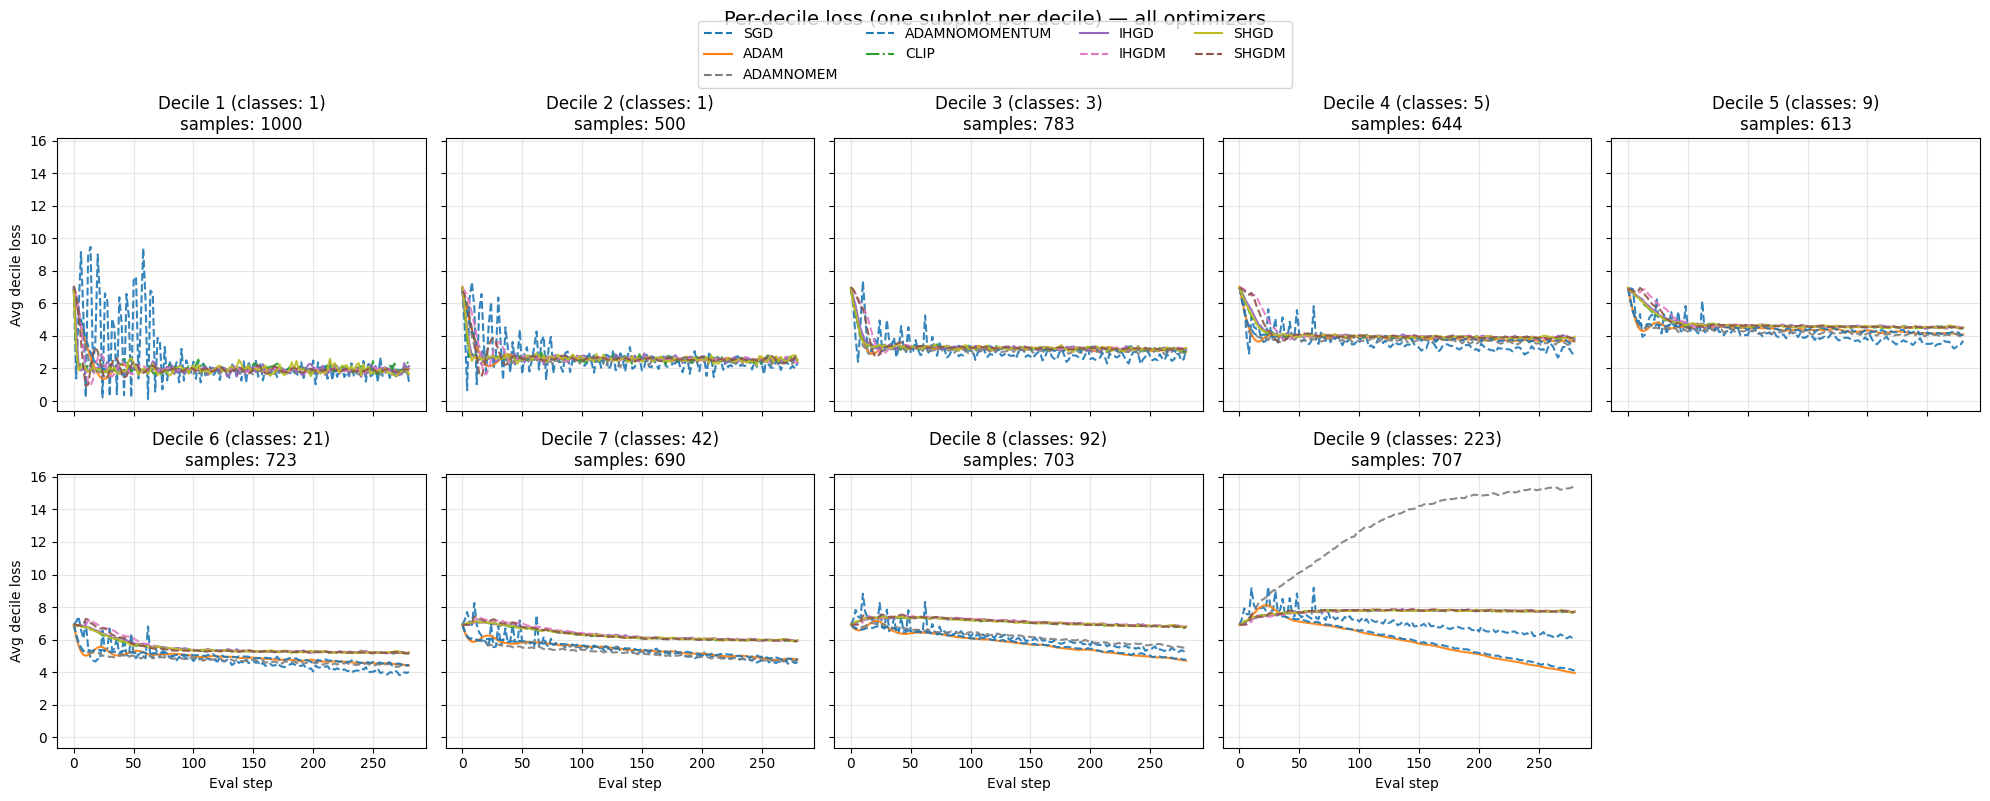

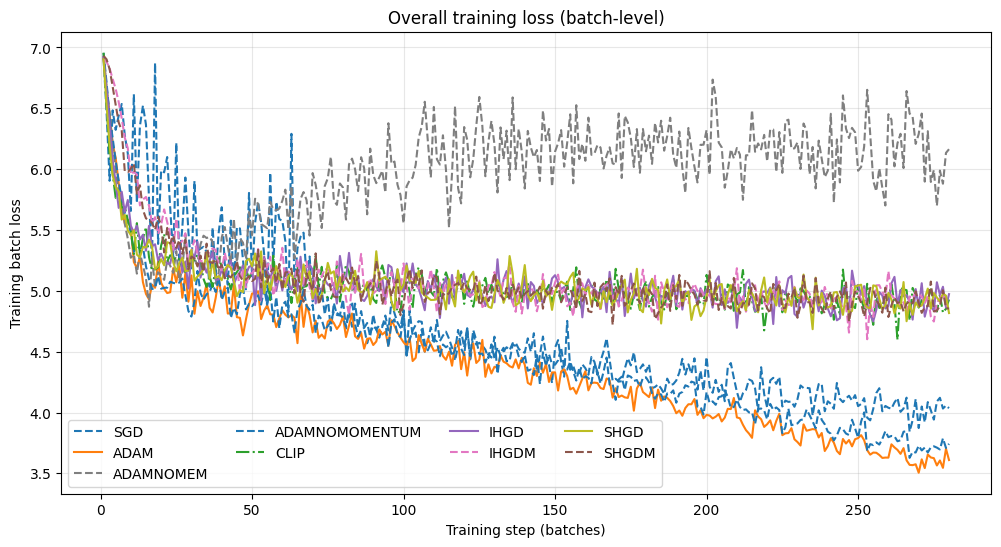

In [9]:
# Paste & run in Colab (one cell)
# Synthetic softmax linear experiment: heavy-tail 1/k class sizes, compare SGD, Adam, Clip, Cosh, iHGD, sHGD, and their momentum variants.

import numpy as np
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from tqdm.notebook import tqdm
import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ------------------------------
# Config
# ------------------------------
C = 1000          # number of classes
d = 512           # input dimension
n1 = 1000           # samples for class 1 (largest class)
alpha = 1.0        # exponent in n_k ~ n1 / k^alpha
batch_size = 512
epochs = 20
evals_per_epoch = 6
seed = 42

np.random.seed(seed)
torch.manual_seed(seed)

# ------------------------------
# Build class sizes n_k ∝ n1 / k^alpha
# ------------------------------
ks = np.arange(1, C+1)
desired = (n1 / (ks**alpha)).astype(int)
desired[desired == 0] = 1
total_train = desired.sum()
print(f"Class counts summary: C={C}, total_train={total_train}, n1={n1}, alpha={alpha}")
print("First 10 class sizes:", desired[:10])

# ------------------------------
# Create synthetic inputs and labels (TRAIN ONLY)
# ------------------------------
X_list, y_list = [], []
for k, nk in enumerate(desired, start=1):
    Xk = np.random.rand(nk, d).astype(np.float32)
    yk = np.full(nk, k-1, dtype=np.int64)
    X_list.append(Xk)
    y_list.append(yk)

X_train = np.vstack(X_list)
y_train = np.concatenate(y_list)
print("Train shape:", X_train.shape, y_train.shape)

# Convert to tensors & DataLoaders
train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
train_eval_loader = DataLoader(train_ds, batch_size=1024, shuffle=False, num_workers=2)

# ------------------------------
# Softmax linear model
# ------------------------------
class SoftmaxLinear(nn.Module):
    def __init__(self, d, C):
        super().__init__()
        self.fc = nn.Linear(d, C)
    def forward(self, x):
        return self.fc(x)

def get_model():
    m = SoftmaxLinear(d, C).to(device)
    nn.init.normal_(m.fc.weight, std=0.01)
    nn.init.zeros_(m.fc.bias)
    return m

# ------------------------------
# Preconditioners (not used directly now, but kept for clarity)
# ------------------------------
class Preconditioner:
    def prec(self, x): return x

class Clip(Preconditioner):
    def prec(self, x): return torch.clamp(x, min=-1, max=1)

class Cosh(Preconditioner):
    def prec(self, x): return torch.arcsinh(x)

# ------------------------------
# Custom optimizer: PrecGD with variants:
#   - mode='clip' : per-element clamp [-1,1]
#   - mode='cosh' : per-element asinh(grad)
#   - mode='s'    : sHGD per-element asinh(grad) (same as cosh here)
#   - mode='i'    : iHGD isotropic scale: scale = asinh(global_norm)/global_norm
# Supports optional heavy-ball momentum (beta in [0,1)).
# ------------------------------
from torch.optim import Optimizer

class PrecGD(Optimizer):
    """
    Preconditioned GD optimizer supporting:
      - mode='clip'  -> per-element clamp
      - mode='cosh'  -> per-element asinh
      - mode='s'     -> alias for 'cosh'
      - mode='i'     -> isotropic scaling asinh(norm)/norm
    Momentum (heavy-ball style) supported via `momentum` arg (beta).
    """
    def __init__(self, params, mode='cosh', lr=1e-2, momentum=0.0):
        if lr <= 0.0:
            raise ValueError("lr must be > 0")
        if not (0.0 <= momentum < 1.0):
            raise ValueError("momentum must be in [0,1)")
        defaults = dict(lr=lr, momentum=momentum, mode=mode)
        super().__init__(params, defaults)
        self.mode = mode
        self._global_scale = None  # only used for 'i' mode

    def _compute_global_norm(self):
        total = 0.0
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None: continue
                g = p.grad.data
                total += float((g.float() ** 2).sum().item())
        return math.sqrt(total)

    def step(self, closure=None):
        """Performs a single optimization step."""
        loss = None
        if closure is not None:
            loss = closure()

        # if isotropic mode, compute global norm & scale
        if self.mode == 'i':
            total_norm = self._compute_global_norm()
            eps = 1e-12
            scale = math.asinh(total_norm) / (total_norm + eps)
            self._global_scale = scale

        for group in self.param_groups:
            lr = group['lr']
            beta = group['momentum']
            mode = group['mode']

            for p in group['params']:
                if p.grad is None:
                    continue
                g = p.grad.data

                # compute preconditioned gradient (pre)
                if mode == 'clip':
                    pre = torch.clamp(g, min=-1.0, max=1.0)
                elif mode in ('cosh', 's'):
                    # per-element arcsinh
                    # use torch.asinh for tensor-safe op
                    pre = torch.asinh(g)
                elif mode == 'i':
                    # isotropic scale
                    scale = self._global_scale if self._global_scale is not None else 1.0
                    pre = g.mul(scale)
                else:
                    raise ValueError(f"Unknown mode: {mode}")

                # heavy-ball momentum: m_k = beta * m_{k-1} + (1-beta) * pre
                state = self.state[p]
                if 'momentum_buffer' not in state:
                    state['momentum_buffer'] = torch.zeros_like(pre)
                m_buf = state['momentum_buffer']
                if beta > 0.0:
                    # in-place ops for speed
                    m_buf.mul_(beta).add_(pre, alpha=(1.0 - beta))
                    update = m_buf
                else:
                    update = pre

                # parameter update
                p.data.add_(update, alpha=-lr)

        return loss

# ------------------------------
# Evaluation on training data
# ------------------------------
loss_fn_none = nn.CrossEntropyLoss(reduction='none')

def evaluate_per_class_on_train(model, loader):
    model.eval()
    per_class_loss = np.zeros(C, dtype=float)
    per_class_count = np.zeros(C, dtype=int)
    total_loss = 0.0
    total_samples = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            losses = loss_fn_none(logits, yb)
            total_loss += losses.sum().item()
            total_samples += yb.size(0)
            y_cpu = yb.cpu().numpy()
            losses_cpu = losses.cpu().numpy()
            for i, label in enumerate(y_cpu):
                per_class_loss[label] += float(losses_cpu[i])
                per_class_count[label] += 1
    per_class_avg = np.full(C, np.nan, dtype=float)
    mask = per_class_count > 0
    per_class_avg[mask] = per_class_loss[mask]/per_class_count[mask]
    overall_avg = total_loss/max(1,total_samples)
    return overall_avg, per_class_avg, per_class_count

# ------------------------------
# Decile grouping
# ------------------------------
class_freqs = desired.copy()
sorted_classes_desc = np.argsort(-class_freqs)
sorted_counts = class_freqs[sorted_classes_desc]
total_samples = sorted_counts.sum()
cuts = [total_samples*i/10.0 for i in range(1,10)]
cumsum = np.cumsum(sorted_counts)
cut_positions = np.searchsorted(cumsum, cuts, side='left')

decile_indices = []
prev=0
for pos in cut_positions:
    if pos<prev: pos=prev
    decile_indices.append(sorted_classes_desc[prev:pos+1])
    prev=pos+1
decile_indices.append(sorted_classes_desc[prev:])
# fix empty bins
for i in range(len(decile_indices)):
    if len(decile_indices[i])==0:
        if i+1<len(decile_indices) and len(decile_indices[i+1])>1:
            decile_indices[i]=np.array([decile_indices[i+1][0]])
            decile_indices[i+1]=decile_indices[i+1][1:]
        elif i-1>=0 and len(decile_indices[i-1])>1:
            decile_indices[i]=np.array([decile_indices[i-1][-1]])
            decile_indices[i-1]=decile_indices[i-1][:-1]

decile_counts = np.array([class_freqs[inds].sum() if len(inds)>0 else 0 for inds in decile_indices])
num_deciles = len(decile_indices)
print("Decile sample counts (final):", decile_counts, "sum:", decile_counts.sum())

# ------------------------------
# Runner (supports many optimizers)
# ------------------------------
def run_single(opt_name, lr=None):
    model = get_model()
    opt_name = opt_name.lower()
    if opt_name == 'sgd':
        opt = optim.SGD(model.parameters(), lr=0.1 if lr is None else lr, momentum=0.9)
    elif opt_name == 'adam':
        opt = optim.Adam(model.parameters(), lr=1e-3 if lr is None else lr)
    elif opt_name == 'adamnomem':
        opt = optim.Adam(model.parameters(), lr=1e-3 if lr is None else lr, betas=(0.0,0.0))
    elif opt_name == 'adamnomemwithmomentum':
        opt = optim.Adam(model.parameters(), lr=1e-3 if lr is None else lr, betas=(0.9,0.0))
    elif opt_name == 'adamnomomentum':
        opt = optim.Adam(model.parameters(), lr=1e-3 if lr is None else lr, betas=(0.0,0.999))
    elif opt_name == 'clip':
        opt = PrecGD(model.parameters(), mode='clip', lr=0.1 if lr is None else lr, momentum=0.0)
    elif opt_name == 'cosh':
        opt = PrecGD(model.parameters(), mode='cosh', lr=0.1 if lr is None else lr, momentum=0.0)
    elif opt_name == 'ihgd':
        opt = PrecGD(model.parameters(), mode='i', lr=0.1 if lr is None else lr, momentum=0.0)
    elif opt_name == 'ihgdm':
        opt = PrecGD(model.parameters(), mode='i', lr=0.1 if lr is None else lr, momentum=0.9)
    elif opt_name == 'shgd':
        opt = PrecGD(model.parameters(), mode='s', lr=0.1 if lr is None else lr, momentum=0.0)
    elif opt_name == 'shgdm':
        opt = PrecGD(model.parameters(), mode='s', lr=0.1 if lr is None else lr, momentum=0.9)
    else:
        raise ValueError(f"Unknown optimizer: {opt_name}")

    T = len(train_loader)
    eval_interval = max(1, T//evals_per_epoch)

    train_steps, train_losses = [], []
    eval_steps, per_class_hist = [], []
    global_step=0

    ov, pc_avg, pc_cnt = evaluate_per_class_on_train(model, train_eval_loader)
    eval_steps.append(0)
    per_class_hist.append(pc_avg.copy())
    print(f"[Init] {opt_name}: train_loss={ov:.4f}")

    model.train()
    for ep in range(epochs):
        pbar = tqdm(train_loader, desc=f"{opt_name} EP{ep+1}", leave=False)
        for xb, yb in pbar:
            xb, yb = xb.to(device), yb.to(device)
            if hasattr(opt, 'zero_grad'):
                opt.zero_grad()
            logits = model(xb)
            loss = nn.functional.cross_entropy(logits, yb)
            loss.backward()
            # our PrecGD has signature step(self, closure=None) and returns None
            opt.step()
            global_step+=1
            train_steps.append(global_step)
            train_losses.append(loss.item())
            if global_step%eval_interval==0:
                model.eval()
                ov, pc_avg, pc_cnt = evaluate_per_class_on_train(model, train_eval_loader)
                eval_steps.append(global_step)
                per_class_hist.append(pc_avg.copy())
                print(f"  Eval @ step {global_step}: train_loss={ov:.4f}")
                model.train()
        model.eval()
        ov, pc_avg, pc_cnt = evaluate_per_class_on_train(model, train_eval_loader)
        eval_steps.append(global_step)
        per_class_hist.append(pc_avg.copy())
        print(f"[Epoch {ep+1}] {opt_name}: train_loss={ov:.4f}")
        model.train()

    return {
        'train_steps': np.array(train_steps),
        'train_losses': np.array(train_losses),
        'eval_steps': np.array(eval_steps),
        'per_class_history': np.stack(per_class_hist)
    }

# ------------------------------
# Run all optimizers (including 4 new ones)
# ------------------------------
opt_list = ['sgd','adam','adamnomem','adamnomomentum', 'clip','ihgd','ihgdm','shgd','shgdm']
results = {}
for opt in opt_list:
    print("Running:", opt)
    results[opt] = run_single(opt)

# ------------------------------
# Compute decile histories
# ------------------------------
def per_decile_history_from_res(res):
    per_class_hist = res['per_class_history']   # shape (T_eval, C)
    T = per_class_hist.shape[0]
    decile_hist = np.full((num_deciles, T), np.nan)
    for d, inds in enumerate(decile_indices):
        if len(inds)==0: continue
        # take mean across classes in this decile for each eval snapshot
        decile_hist[d,:] = np.nanmean(per_class_hist[:,inds],axis=1)
    return decile_hist

decile_hist = {opt: per_decile_history_from_res(results[opt]) for opt in results}

# ------------------------------
# Plot: one subplot per decile (2 rows x 5 cols)
# ------------------------------
plt.close('all')
nrows, ncols = 2, 5
fig, axes = plt.subplots(nrows, ncols, figsize=(20, 8), sharex=True, sharey=True)
axes = axes.flatten()

styles = {
    'sgd': ('--','tab:blue'),
    'adam': ('-','tab:orange'),
    'adamnomem': ('--','tab:gray'),
    'adamnomomentum': ('--','tab:blue'),
    'clip': ('-.','tab:green'),
    'ihgd': ('-','tab:purple'),
    'ihgdm': ('--','tab:pink'),
    'shgd': ('-','tab:olive'),
    'shgdm': ('--','tab:brown'),
}

for d in range(num_deciles):
    ax = axes[d]
    for opt in opt_list:
        y = decile_hist[opt][d]
        x = results[opt]['eval_steps']
        # mask NaNs (some early evals may have NaN if class empty)
        y_masked = np.ma.masked_invalid(y)
        style, color = styles.get(opt, ('-', 'k'))
        ax.plot(x, y_masked, linestyle=style, color=color, alpha=0.9, label=opt.upper())
    ax.set_title(f"Decile {d+1} (classes: {len(decile_indices[d])})\nsamples: {decile_counts[d]}")
    ax.grid(alpha=0.3)
    if d % ncols == 0:
        ax.set_ylabel("Avg decile loss")
    if d >= (nrows-1)*ncols:
        ax.set_xlabel("Eval step")

# hide extra axes if any
for i in range(len(opt_list), nrows*ncols):
    fig.delaxes(axes[i])

# global legend (unique entries)
lines = []
labels = []
for opt in opt_list:
    ls, col = styles[opt]
    lines.append(Line2D([0],[0], color=col, ls=ls))
    labels.append(opt.upper())

fig.legend(lines, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 0.99))
fig.suptitle("Per-decile loss (one subplot per decile) — all optimizers", y=0.995, fontsize=14)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

# ------------------------------
# Plot overall training loss (batch-level) (downsampled)
# ------------------------------
plt.figure(figsize=(12,6))
def downsample(x,y,max_points=2000):
    if len(x)<=max_points: return x,y
    idxs = np.linspace(0,len(x)-1,max_points,dtype=int)
    return np.array(x)[idxs], np.array(y)[idxs]

for opt, style_color in styles.items():
    style, color = style_color
    xs, ys = downsample(results[opt]['train_steps'], results[opt]['train_losses'])
    plt.plot(xs, ys, linestyle=style, label=opt.upper(), color=color)

plt.xlabel('Training step (batches)')
plt.ylabel('Training batch loss')
plt.title('Overall training loss (batch-level)')
plt.grid(alpha=0.3)
plt.legend(ncol=4)
plt.show()

Device: cuda
Class counts summary: C=1000, total_train=7069, n1=1000, alpha=1.0
First 10 class sizes: [1000  500  333  250  200  166  142  125  111  100]
Train shape: (7069, 512) (7069,)
Decile sample counts (final): [1000  500  783  644  613  723  690  703  707  706] sum: 7069

=== Running: sepadam_clip_coshv ===
[Init] sepadam_clip_coshv: train_loss=6.9125


sepadam_clip_coshv EP1:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 2: train_loss=6.3926
  Eval @ step 4: train_loss=5.9404
  Eval @ step 6: train_loss=5.5995
  Eval @ step 8: train_loss=5.3657
  Eval @ step 10: train_loss=5.2179
  Eval @ step 12: train_loss=5.1270
  Eval @ step 14: train_loss=5.0940
[Epoch 1] sepadam_clip_coshv: train_loss=5.0940


sepadam_clip_coshv EP2:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 16: train_loss=5.0931
  Eval @ step 18: train_loss=5.1307
  Eval @ step 20: train_loss=5.1551
  Eval @ step 22: train_loss=5.1463
  Eval @ step 24: train_loss=5.0293
  Eval @ step 26: train_loss=4.9399
  Eval @ step 28: train_loss=4.8961
[Epoch 2] sepadam_clip_coshv: train_loss=4.8961


sepadam_clip_coshv EP3:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 30: train_loss=4.8892
  Eval @ step 32: train_loss=4.8654
  Eval @ step 34: train_loss=4.8211
  Eval @ step 36: train_loss=4.7726
  Eval @ step 38: train_loss=4.7271
  Eval @ step 40: train_loss=4.6832
  Eval @ step 42: train_loss=4.6462
[Epoch 3] sepadam_clip_coshv: train_loss=4.6462


sepadam_clip_coshv EP4:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 44: train_loss=4.6189
  Eval @ step 46: train_loss=4.5964
  Eval @ step 48: train_loss=4.5763
  Eval @ step 50: train_loss=4.5467
  Eval @ step 52: train_loss=4.5046
  Eval @ step 54: train_loss=4.4683
  Eval @ step 56: train_loss=4.4330
[Epoch 4] sepadam_clip_coshv: train_loss=4.4330


sepadam_clip_coshv EP5:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 58: train_loss=4.4048
  Eval @ step 60: train_loss=4.3867
  Eval @ step 62: train_loss=4.3706
  Eval @ step 64: train_loss=4.3437
  Eval @ step 66: train_loss=4.3052
  Eval @ step 68: train_loss=4.2631
  Eval @ step 70: train_loss=4.2250
[Epoch 5] sepadam_clip_coshv: train_loss=4.2250


sepadam_clip_coshv EP6:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 72: train_loss=4.2095
  Eval @ step 74: train_loss=4.1978
  Eval @ step 76: train_loss=4.1698
  Eval @ step 78: train_loss=4.1372
  Eval @ step 80: train_loss=4.1066
  Eval @ step 82: train_loss=4.0741
  Eval @ step 84: train_loss=4.0358
[Epoch 6] sepadam_clip_coshv: train_loss=4.0358


sepadam_clip_coshv EP7:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 86: train_loss=4.0059
  Eval @ step 88: train_loss=3.9890
  Eval @ step 90: train_loss=3.9696
  Eval @ step 92: train_loss=3.9422
  Eval @ step 94: train_loss=3.9098
  Eval @ step 96: train_loss=3.8714
  Eval @ step 98: train_loss=3.8353
[Epoch 7] sepadam_clip_coshv: train_loss=3.8353


sepadam_clip_coshv EP8:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 100: train_loss=3.8155
  Eval @ step 102: train_loss=3.7986
  Eval @ step 104: train_loss=3.7775
  Eval @ step 106: train_loss=3.7496
  Eval @ step 108: train_loss=3.7179
  Eval @ step 110: train_loss=3.6812
  Eval @ step 112: train_loss=3.6542
[Epoch 8] sepadam_clip_coshv: train_loss=3.6542


sepadam_clip_coshv EP9:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 114: train_loss=3.6370
  Eval @ step 116: train_loss=3.6191
  Eval @ step 118: train_loss=3.5984
  Eval @ step 120: train_loss=3.5762
  Eval @ step 122: train_loss=3.5433
  Eval @ step 124: train_loss=3.5059
  Eval @ step 126: train_loss=3.4732
[Epoch 9] sepadam_clip_coshv: train_loss=3.4732


sepadam_clip_coshv EP10:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 128: train_loss=3.4571
  Eval @ step 130: train_loss=3.4421
  Eval @ step 132: train_loss=3.4221
  Eval @ step 134: train_loss=3.3933
  Eval @ step 136: train_loss=3.3637
  Eval @ step 138: train_loss=3.3337
  Eval @ step 140: train_loss=3.3021
[Epoch 10] sepadam_clip_coshv: train_loss=3.3021


sepadam_clip_coshv EP11:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 142: train_loss=3.2832
  Eval @ step 144: train_loss=3.2720
  Eval @ step 146: train_loss=3.2524
  Eval @ step 148: train_loss=3.2239
  Eval @ step 150: train_loss=3.1984
  Eval @ step 152: train_loss=3.1790
  Eval @ step 154: train_loss=3.1497
[Epoch 11] sepadam_clip_coshv: train_loss=3.1497


sepadam_clip_coshv EP12:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 156: train_loss=3.1307
  Eval @ step 158: train_loss=3.1217
  Eval @ step 160: train_loss=3.1108
  Eval @ step 162: train_loss=3.0879
  Eval @ step 164: train_loss=3.0609
  Eval @ step 166: train_loss=3.0343
  Eval @ step 168: train_loss=3.0097
[Epoch 12] sepadam_clip_coshv: train_loss=3.0097


sepadam_clip_coshv EP13:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 170: train_loss=2.9949
  Eval @ step 172: train_loss=2.9852
  Eval @ step 174: train_loss=2.9680
  Eval @ step 176: train_loss=2.9499
  Eval @ step 178: train_loss=2.9302
  Eval @ step 180: train_loss=2.9040
  Eval @ step 182: train_loss=2.8801
[Epoch 13] sepadam_clip_coshv: train_loss=2.8801


sepadam_clip_coshv EP14:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 184: train_loss=2.8649
  Eval @ step 186: train_loss=2.8588
  Eval @ step 188: train_loss=2.8505
  Eval @ step 190: train_loss=2.8323
  Eval @ step 192: train_loss=2.8072
  Eval @ step 194: train_loss=2.7886
  Eval @ step 196: train_loss=2.7743
[Epoch 14] sepadam_clip_coshv: train_loss=2.7743


sepadam_clip_coshv EP15:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 198: train_loss=2.7626
  Eval @ step 200: train_loss=2.7496
  Eval @ step 202: train_loss=2.7340
  Eval @ step 204: train_loss=2.7232
  Eval @ step 206: train_loss=2.7069
  Eval @ step 208: train_loss=2.6863
  Eval @ step 210: train_loss=2.6594
[Epoch 15] sepadam_clip_coshv: train_loss=2.6594


sepadam_clip_coshv EP16:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 212: train_loss=2.6470
  Eval @ step 214: train_loss=2.6416
  Eval @ step 216: train_loss=2.6366
  Eval @ step 218: train_loss=2.6216
  Eval @ step 220: train_loss=2.6011
  Eval @ step 222: train_loss=2.5808
  Eval @ step 224: train_loss=2.5646
[Epoch 16] sepadam_clip_coshv: train_loss=2.5646


sepadam_clip_coshv EP17:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 226: train_loss=2.5643
  Eval @ step 228: train_loss=2.5576
  Eval @ step 230: train_loss=2.5447
  Eval @ step 232: train_loss=2.5319
  Eval @ step 234: train_loss=2.5147
  Eval @ step 236: train_loss=2.4895
  Eval @ step 238: train_loss=2.4729
[Epoch 17] sepadam_clip_coshv: train_loss=2.4729


sepadam_clip_coshv EP18:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 240: train_loss=2.4713
  Eval @ step 242: train_loss=2.4648
  Eval @ step 244: train_loss=2.4495
  Eval @ step 246: train_loss=2.4378
  Eval @ step 248: train_loss=2.4239
  Eval @ step 250: train_loss=2.4007
  Eval @ step 252: train_loss=2.3844
[Epoch 18] sepadam_clip_coshv: train_loss=2.3844


sepadam_clip_coshv EP19:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 254: train_loss=2.3851
  Eval @ step 256: train_loss=2.3834
  Eval @ step 258: train_loss=2.3693
  Eval @ step 260: train_loss=2.3515
  Eval @ step 262: train_loss=2.3378
  Eval @ step 264: train_loss=2.3288
  Eval @ step 266: train_loss=2.3132
[Epoch 19] sepadam_clip_coshv: train_loss=2.3132


sepadam_clip_coshv EP20:   0%|          | 0/14 [00:00<?, ?it/s]

  Eval @ step 268: train_loss=2.3033
  Eval @ step 270: train_loss=2.3034
  Eval @ step 272: train_loss=2.2954
  Eval @ step 274: train_loss=2.2853
  Eval @ step 276: train_loss=2.2700
  Eval @ step 278: train_loss=2.2513
  Eval @ step 280: train_loss=2.2373
[Epoch 20] sepadam_clip_coshv: train_loss=2.2373


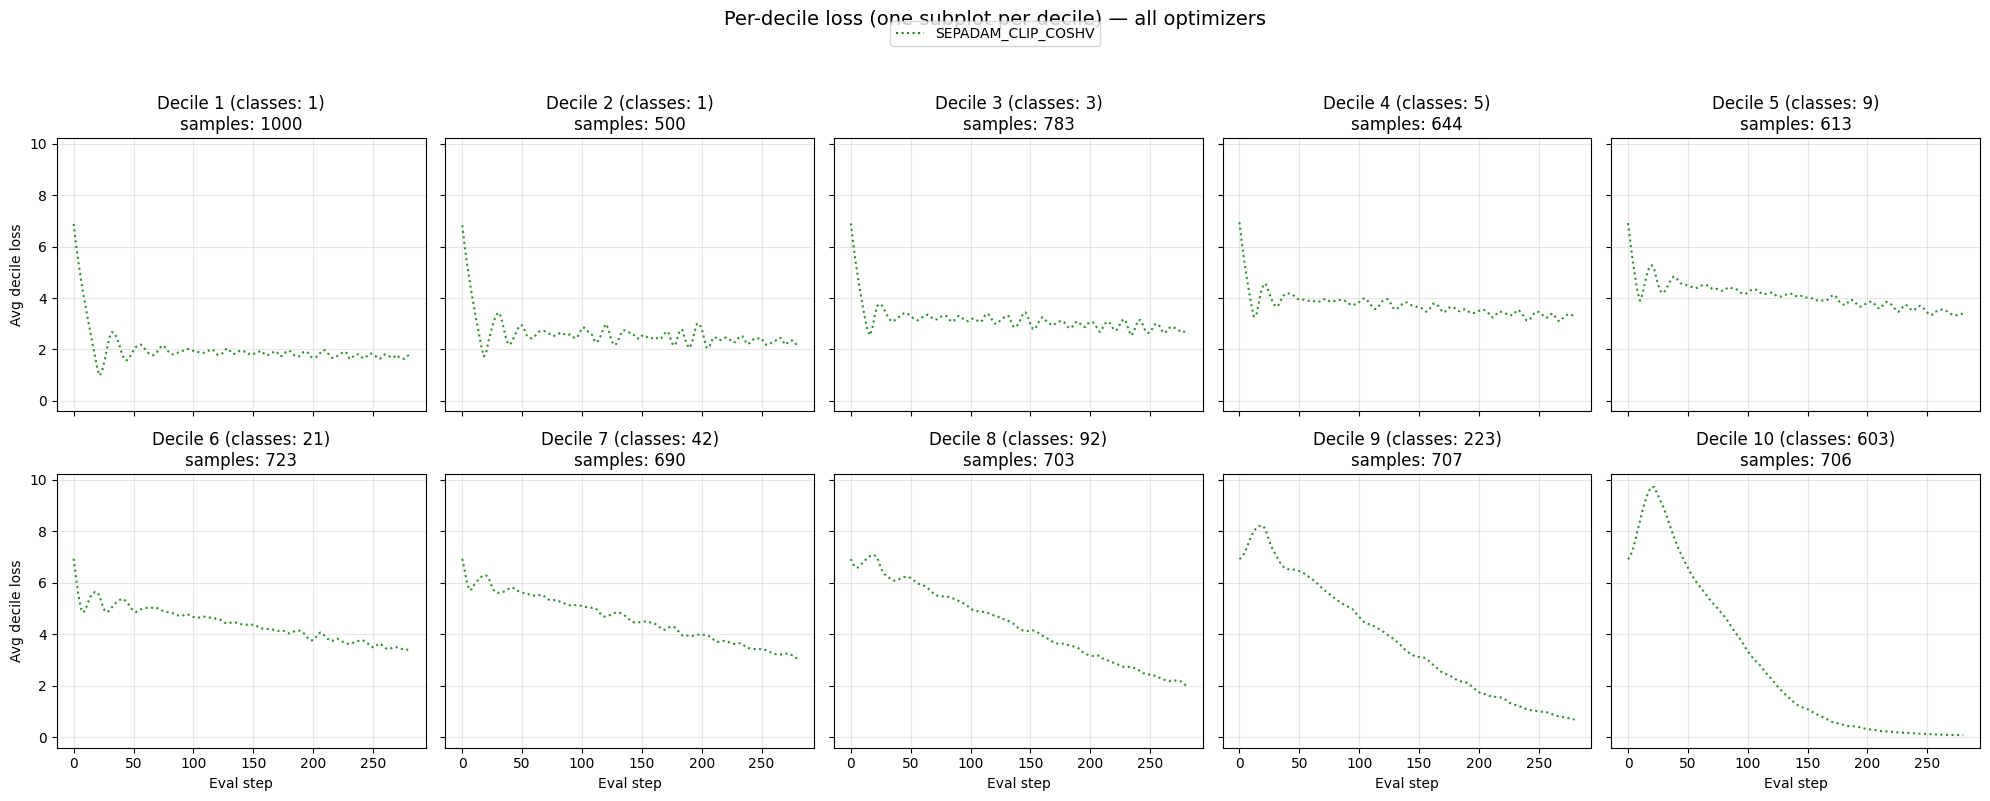

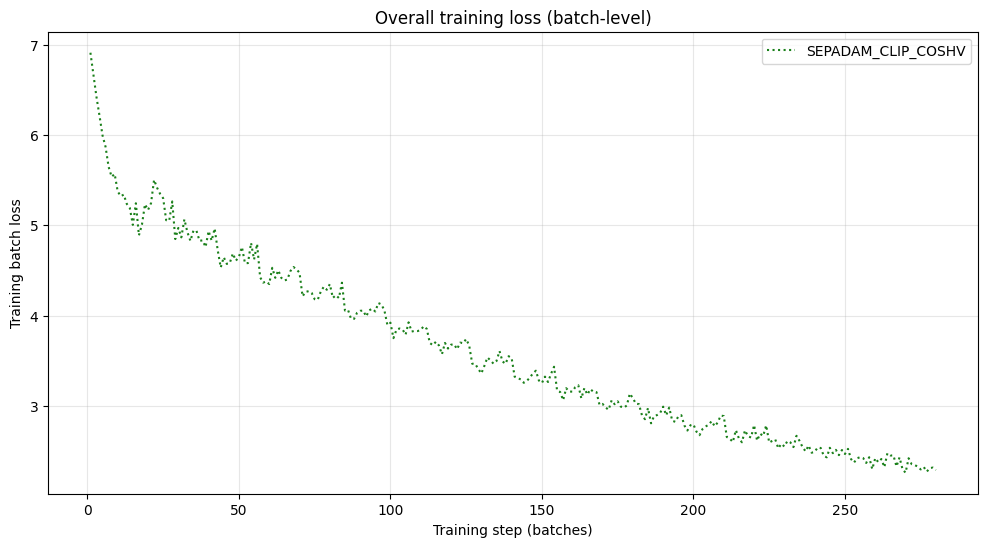

Done.


In [11]:
# ----------------------------- paste & run in Colab -----------------------------
# Synthetic softmax linear experiment with many optimizers including preconditioned-Adam
import os, math, numpy as np, random, time
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from tqdm.notebook import tqdm
from collections import Counter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ------------------------------ Config (tweak if needed) ------------------------------
C = 1000          # number of classes
d = 512           # input dimension
n1 = 1000         # samples for class 1 (largest class)
alpha = 1.0       # exponent in n_k ~ n1 / k^alpha
batch_size = 512
epochs = 20
evals_per_epoch = 6
seed = 42

np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

# ------------------------------ Build class sizes n_k ∝ n1 / k^alpha ------------------------------
ks = np.arange(1, C+1)
desired = (n1 / (ks**alpha)).astype(int)
desired[desired == 0] = 1
total_train = desired.sum()
print(f"Class counts summary: C={C}, total_train={total_train}, n1={n1}, alpha={alpha}")
print("First 10 class sizes:", desired[:10])

# ------------------------------ Create synthetic inputs and labels (TRAIN ONLY) ------------------------------
X_list, y_list = [], []
for k, nk in enumerate(desired, start=1):
    Xk = np.random.rand(nk, d).astype(np.float32)
    yk = np.full(nk, k-1, dtype=np.int64)
    X_list.append(Xk); y_list.append(yk)

X_train = np.vstack(X_list)
y_train = np.concatenate(y_list)
print("Train shape:", X_train.shape, y_train.shape)

# DataLoaders
train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
train_eval_loader = DataLoader(train_ds, batch_size=1024, shuffle=False, num_workers=2)

# ------------------------------ Softmax linear model ------------------------------
class SoftmaxLinear(nn.Module):
    def __init__(self, d, C):
        super().__init__()
        self.fc = nn.Linear(d, C)
    def forward(self, x):
        return self.fc(x)

def get_model():
    m = SoftmaxLinear(d, C).to(device)
    nn.init.normal_(m.fc.weight, std=0.01)
    nn.init.zeros_(m.fc.bias)
    return m

# ------------------------------ Preconditioners ------------------------------
class Preconditioner:
    def prec(self, x): return x

import torch

class Clip(Preconditioner):
    """Elementwise hard clipping to [-1, 1]. Safe and bounded."""
    def prec(self, x):
        return torch.clamp(x, min=-1.0, max=1.0)

class Cosh(Preconditioner):
    """
    'Cosh' preconditioner: use a soft inverse-like transform.
    We use asinh(x) (inverse hyperbolic sine) as a smooth, odd transform that
    behaves like x for small values and like sign(x) * log(2|x|) for large values.
    This compresses large components instead of amplifying them.
    """
    def prec(self, x):
        return torch.asinh(x)   # numerically stable for all real x

class Exp(Preconditioner):
    """
    'Exp' (soft-exp) preconditioner: *not* raw exp(x) (would explode).
    Instead use sign(x) * log1p(|x|) which grows logarithmically for large |x|.
    This gives a soft, odd transform that compresses large gradients:
        prec(x) = sign(x) * log(1 + |x|)
    """
    def prec(self, x):
        return torch.sign(x) * torch.log1p(torch.abs(x))

class NegLog(Preconditioner):
    """
    'NegLog' preconditioner: a bounded, saturating transform.
    Implemented as x / (1 + |x|) which is odd, bounded in (-1,1), and
    behaves linearly near zero:
        prec(x) = x / (1 + |x|)
    This is numerically safe for all x.
    """
    def prec(self, x):
        return x / (1.0 + torch.abs(x))

class Identity(Preconditioner):
    """No preconditioning — returns the gradient as-is."""
    def prec(self, x):
        return x

# ------------------------------ PrecGD: user-provided preconditioning (Clip/Cosh/iHGD/sHGD) ------------------------------
from torch.optim import Optimizer

class PrecGD(Optimizer):
    """
    Preconditioned GD:
      - mode='clip' -> elementwise clamp
      - mode='cosh' or 's' -> elementwise asinh
      - mode='i' -> isotropic: scale = asinh(global_norm)/global_norm
    Supports heavy-ball momentum via `momentum` (beta).
    """
    def __init__(self, params, mode='cosh', lr=1e-2, momentum=0.0):
        if lr <= 0.0: raise ValueError("lr must be > 0")
        if not (0.0 <= momentum < 1.0): raise ValueError("momentum must be in [0,1)")
        defaults = dict(lr=lr, momentum=momentum, mode=mode)
        super().__init__(params, defaults)
        self.mode = mode
        self._global_scale = None

    def _compute_global_norm(self):
        total = 0.0
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None: continue
                g = p.grad.data
                total += float((g.float() ** 2).sum().item())
        return math.sqrt(total)

    def step(self, closure=None):
        loss = None
        if closure is not None: loss = closure()

        if self.mode == 'i':
            total_norm = self._compute_global_norm()
            eps = 1e-12
            scale = math.asinh(total_norm) / (total_norm + eps)
            self._global_scale = scale

        for group in self.param_groups:
            lr = group['lr']; beta = group['momentum']; mode = group['mode']
            for p in group['params']:
                if p.grad is None: continue
                g = p.grad.data

                if mode == 'clip':
                    pre = torch.clamp(g, min=-1.0, max=1.0)
                elif mode in ('cosh', 's'):
                    pre = torch.asinh(g)
                elif mode == 'i':
                    scale = self._global_scale if self._global_scale is not None else 1.0
                    pre = g.mul(scale)
                else:
                    raise ValueError(f"Unknown mode: {mode}")

                state = self.state[p]
                if 'momentum_buffer' not in state:
                    state['momentum_buffer'] = torch.zeros_like(pre)
                m_buf = state['momentum_buffer']
                if beta > 0.0:
                    m_buf.mul_(beta).add_(pre, alpha=(1.0 - beta))
                    update = m_buf
                else:
                    update = pre

                p.data.add_(update, alpha=-lr)
        return loss

# ------------------------------ New: PrecGDSepAdam & PrecGDIsoAdam ------------------------------
class PrecGDSepAdam(Optimizer):
    """
    Separable Adam-style preconditioning with pluggable second-moment transform.

    Options for v_transform:
      - 'square'     : standard Adam, psi(g) = g^2
      - 'cosh'       : psi(g) = cosh(scale * g) - 1
      - 'asinh_sq'   : psi(g) = asinh(g)^2
      - 'log1p_sq'   : psi(g) = log1p(g^2)
      - 'abs'        : psi(g) = |g|
      - callable     : a function psi(tensor) -> tensor

    The update still computes scaled = m_hat / (sqrt(v_hat) + eps),
    then delta = prec.prec(lamb * scaled) elementwise, and p -= lr * delta.
    """
    def __init__(self, params, prec,
                 lr=1e-3, lamb=1.0,
                 betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=0.0, bias_correction=True,
                 v_transform='square', v_scale=1.0):
        if lr <= 0.0:
            raise ValueError("Invalid lr")
        defaults = dict(lr=lr, lamb=lamb, betas=betas, eps=eps,
                        weight_decay=weight_decay, bias_correction=bias_correction,
                        v_transform=v_transform, v_scale=v_scale)
        super().__init__(params, defaults)
        self.prec = prec
        self._step = 0

        # map standard names to functions (callable expects tensor input)
        def _psi_square(g, scale=1.0):
            return (g * scale) ** 2

        def _psi_cosh(g, scale=1.0):
            # cosh(scale * g) - 1 ; subtract 1 so psi(0)=0
            return torch.cosh(g * scale) - 1.0

        def _psi_asinh_sq(g, scale=1.0):
            return torch.asinh(g * scale) ** 2

        def _psi_log1p_sq(g, scale=1.0):
            return torch.log1p((g * scale) ** 2)

        def _psi_abs(g, scale=1.0):
            return torch.abs(g * scale)

        self._builtin_psi = {
            'square': _psi_square,
            'cosh': _psi_cosh,
            'asinh_sq': _psi_asinh_sq,
            'log1p_sq': _psi_log1p_sq,
            'abs': _psi_abs
        }

    def _apply_psi(self, psi_spec, g, scale):
        """Return psi(g) given psi_spec (name or callable) and scale."""
        if callable(psi_spec):
            return psi_spec(g, scale) if _callable_accepts_scale(psi_spec) else psi_spec(g)
        if isinstance(psi_spec, str):
            fn = self._builtin_psi.get(psi_spec)
            if fn is None:
                raise ValueError(f"Unknown v_transform '{psi_spec}'")
            return fn(g, scale)
        raise ValueError("v_transform must be str or callable")

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()
        self._step += 1

        for group in self.param_groups:
            lr = group['lr']
            lamb = group['lamb']
            beta1, beta2 = group['betas']
            eps = group['eps']
            wd = group['weight_decay']
            bias_corr = group['bias_correction']
            psi_spec = group.get('v_transform', 'square')
            psi_scale = float(group.get('v_scale', 1.0))

            for p in group['params']:
                if p.grad is None:
                    continue
                g = p.grad.data
                # apply weight decay in Adam style if requested (decoupled or not? here we simply add)
                if wd != 0:
                    g = g.add(p.data, alpha=wd)

                state = self.state.setdefault(p, {})
                if 'm' not in state:
                    state['m'] = torch.zeros_like(p.data)
                    state['v'] = torch.zeros_like(p.data)

                m = state['m']
                v = state['v']

                # first moment
                m.mul_(beta1).add_(g, alpha=(1 - beta1))

                # second moment uses psi transform instead of g^2
                try:
                    psi_val = self._apply_psi(psi_spec, g, psi_scale)
                except Exception as e:
                    # fallback: if psi is weird, fall back to square
                    psi_val = g * g

                # ensure psi_val is same device/shape
                if not isinstance(psi_val, torch.Tensor) or psi_val.shape != g.shape:
                    psi_val = torch.as_tensor(psi_val, device=g.device, dtype=g.dtype).view_as(g)

                v.mul_(beta2).add_(psi_val, alpha=(1 - beta2))

                # bias correction
                if bias_corr:
                    bc1 = 1 - beta1 ** self._step
                    bc2 = 1 - beta2 ** self._step
                    # avoid divide-by-zero in early steps
                    m_hat = m / (bc1 + 1e-16)
                    v_hat = v / (bc2 + 1e-16)
                else:
                    m_hat = m
                    v_hat = v

                # ensure non-negativity and stability of v_hat (some psi could produce tiny negatives numerically)
                # clamp minimum to small positive
                v_hat = v_hat.clamp(min=1e-30)

                denom = v_hat.sqrt().add(eps)
                scaled = m_hat / denom

                # elementwise preconditioner application
                try:
                    delta = self.prec.prec(lamb * scaled)
                except Exception:
                    # fallback to elementwise scalar application (slower)
                    flat = scaled.view(-1)
                    vals = [self.prec.prec(float(x)) for x in flat]
                    delta = torch.tensor(vals, device=scaled.device, dtype=scaled.dtype).view_as(scaled)

                p.data.add_(delta, alpha=-lr)

        return loss

# helper to introspect whether a callable accepts (g, scale) or just (g)
import inspect
def _callable_accepts_scale(fn):
    try:
        sig = inspect.signature(fn)
        return len(sig.parameters) >= 2
    except Exception:
        return False


class PrecGDIsoAdam(Optimizer):
    """
    Isotropic Adam-style: aggregate grads into scalar m/v, compute scaled_scalar = m_hat / (sqrt(v_hat)+eps),
    prec_val = prec.prec(lamb * scaled_scalar) (scalar), update p -= lr * (prec_val / ||g||) * g  (preserve direction)
    """
    def __init__(self, params, prec, lr=1e-3, lamb=1.0, betas=(0.9,0.999), eps=1e-8, weight_decay=0.0, bias_correction=True):
        defaults = dict(lr=lr, lamb=lamb, betas=betas, eps=eps, weight_decay=weight_decay, bias_correction=bias_correction)
        super().__init__(params, defaults)
        self.prec = prec
        self._step = 0
        # scalar moments (per optimizer instance)
        self._m_scalar = 0.0
        self._v_scalar = 0.0

    def step(self, closure=None):
        loss = None
        if closure is not None: loss = closure()
        self._step += 1

        for group in self.param_groups:
            lr = group['lr']; lamb = group['lamb']; beta1, beta2 = group['betas']
            eps = group['eps']; wd = group['weight_decay']; bias_corr = group['bias_correction']

            # collect grads flattened
            grads = []
            for p in group['params']:
                if p.grad is None: continue
                g = p.grad.data
                if wd != 0:
                    g = g.add(p.data, alpha=wd)
                grads.append(g.view(-1))

            if len(grads) == 0:
                continue

            cat = torch.cat(grads)
            g_mean = float(cat.mean().item())
            g_mean_sq = float((cat * cat).mean().item())

            # update scalar moments
            self._m_scalar = beta1 * self._m_scalar + (1 - beta1) * g_mean
            self._v_scalar = beta2 * self._v_scalar + (1 - beta2) * g_mean_sq

            if bias_corr:
                bc1 = 1 - beta1 ** self._step
                bc2 = 1 - beta2 ** self._step
                m_hat = self._m_scalar / bc1
                v_hat = self._v_scalar / bc2
            else:
                m_hat = self._m_scalar; v_hat = self._v_scalar

            denom_scalar = math.sqrt(max(v_hat, 0.0)) + eps
            scaled_scalar = m_hat / denom_scalar

            # evaluate preconditioner on scalar
            try:
                prec_val = self.prec.prec(torch.tensor(lamb * scaled_scalar, device=cat.device))
                scal_prec = float(prec_val.item()) if isinstance(prec_val, torch.Tensor) else float(prec_val)
            except Exception:
                scal_prec = float(self.prec.prec(lamb * scaled_scalar))

            # apply scaled update preserving direction per parameter
            for p in group['params']:
                if p.grad is None: continue
                g = p.grad.data
                g_norm = g.norm().item()
                if g_norm > 1e-16:
                    mul = (scal_prec / (g_norm + 1e-16))
                    p.data.add_(g, alpha = -lr * mul)
                else:
                    pass
        return loss

# ------------------------------ Evaluation helper ------------------------------
loss_fn_none = nn.CrossEntropyLoss(reduction='none')
def evaluate_per_class_on_train(model, loader):
    model.eval()
    per_class_loss = np.zeros(C, dtype=float)
    per_class_count = np.zeros(C, dtype=int)
    total_loss = 0.0; total_samples = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            losses = loss_fn_none(logits, yb)
            total_loss += losses.sum().item()
            total_samples += yb.size(0)
            y_cpu = yb.cpu().numpy(); losses_cpu = losses.cpu().numpy()
            for i, label in enumerate(y_cpu):
                per_class_loss[label] += float(losses_cpu[i])
                per_class_count[label] += 1
    per_class_avg = np.full(C, np.nan, dtype=float)
    mask = per_class_count > 0
    per_class_avg[mask] = per_class_loss[mask] / per_class_count[mask]
    overall_avg = total_loss / max(1, total_samples)
    return overall_avg, per_class_avg, per_class_count

# ------------------------------ Decile grouping (by ~10% sample mass) ------------------------------
class_freqs = desired.copy()
sorted_classes_desc = np.argsort(-class_freqs)
sorted_counts = class_freqs[sorted_classes_desc]
total_samples = sorted_counts.sum()
cuts = [total_samples * i / 10.0 for i in range(1,10)]
cumsum = np.cumsum(sorted_counts)
cut_positions = np.searchsorted(cumsum, cuts, side='left')

decile_indices = []
prev = 0
for pos in cut_positions:
    if pos < prev: pos = prev
    decile_indices.append(sorted_classes_desc[prev:pos+1])
    prev = pos+1
decile_indices.append(sorted_classes_desc[prev:])
# repair empty bins
for i in range(len(decile_indices)):
    if len(decile_indices[i]) == 0:
        if i+1 < len(decile_indices) and len(decile_indices[i+1]) > 1:
            decile_indices[i] = np.array([decile_indices[i+1][0]])
            decile_indices[i+1] = decile_indices[i+1][1:]
        elif i-1 >= 0 and len(decile_indices[i-1]) > 1:
            decile_indices[i] = np.array([decile_indices[i-1][-1]])
            decile_indices[i-1] = decile_indices[i-1][:-1]

decile_counts = np.array([class_freqs[inds].sum() if len(inds)>0 else 0 for inds in decile_indices])
num_deciles = len(decile_indices)
print("Decile sample counts (final):", decile_counts, "sum:", decile_counts.sum())

# ------------------------------ Runner (supports many optimizers) ------------------------------
def run_single(opt_name, lr=None):
    model = get_model()
    name = opt_name.lower()
    if name == 'sgd':
        opt = optim.SGD(model.parameters(), lr=0.1 if lr is None else lr, momentum=0.9)
    elif name == 'adam':
        opt = optim.Adam(model.parameters(), lr=1e-3 if lr is None else lr)
    elif name == 'adamnomem':
        opt = optim.Adam(model.parameters(), lr=1e-3 if lr is None else lr, betas=(0.0,0.0))
    elif name == 'adamnomomentum':
        opt = optim.Adam(model.parameters(), lr=1e-3 if lr is None else lr, betas=(0.0,0.999))
    elif name == 'clip':
        opt = PrecGD(model.parameters(), mode='clip', lr=0.1 if lr is None else lr, momentum=0.0)
    elif name == 'cosh':
        opt = PrecGD(model.parameters(), mode='cosh', lr=0.1 if lr is None else lr, momentum=0.0)
    elif name == 'ihgd':
        opt = PrecGD(model.parameters(), mode='i', lr=0.1 if lr is None else lr, momentum=0.0)
    elif name == 'ihgdm':
        opt = PrecGD(model.parameters(), mode='i', lr=0.1 if lr is None else lr, momentum=0.9)
    elif name == 'shgd':
        opt = PrecGD(model.parameters(), mode='s', lr=0.1 if lr is None else lr, momentum=0.0)
    elif name == 'shgdm':
        opt = PrecGD(model.parameters(), mode='s', lr=0.1 if lr is None else lr, momentum=0.9)
    elif name == 'sepadam_clip':
        opt = PrecGDSepAdam(
            model.parameters(),
            prec=Clip(),
            lr=1e-3 if lr is None else lr,
            lamb=1.0,
            betas=(0.9, 0.999),
            v_transform='square'
        )

    elif name == 'sepadam_cosh':
        opt = PrecGDSepAdam(
            model.parameters(),
            prec=Cosh(),
            lr=1e-3 if lr is None else lr,
            lamb=1.0,
            betas=(0.9, 0.999),
            v_transform='square'
        )

    elif name == 'sepadam_exp':
        opt = PrecGDSepAdam(
            model.parameters(),
            prec=Exp(),
            lr=1e-3 if lr is None else lr,
            lamb=1.0,
            betas=(0.9, 0.999),
            v_transform='square'
        )

    elif name == 'sepadam_neglog':
        opt = PrecGDSepAdam(
            model.parameters(),
            prec=NegLog(),
            lr=1e-3 if lr is None else lr,
            lamb=1.0,
            betas=(0.9, 0.999),
            v_transform='square'
        )
    elif name == 'sepadam_clip_coshv':
        opt = PrecGDSepAdam(
            model.parameters(),
            prec=Clip(),
            lr=1e-3 if lr is None else lr,
            lamb=1.0,
            betas=(0.9, 0.999),
            v_transform='cosh',
            v_scale=0.5
        )
    elif name == 'sepadam_cosh_asinhv':
        opt = PrecGDSepAdam(
            model.parameters(),
            prec=Cosh(),
            lr=1e-3 if lr is None else lr,
            lamb=1.0,
            betas=(0.9, 0.999),
            v_transform='asinh_sq'
        )
    elif name == 'sepadam_exp_logv':
        opt = PrecGDSepAdam(
            model.parameters(),
            prec=Exp(),
            lr=1e-3 if lr is None else lr,
            lamb=1.0,
            betas=(0.9, 0.999),
            v_transform='log1p_sq'
        )
    elif name == 'sepadam_neglog_absv':
        opt = PrecGDSepAdam(
            model.parameters(),
            prec=NegLog(),
            lr=1e-3 if lr is None else lr,
            lamb=1.0,
            betas=(0.9, 0.999),
            v_transform='abs'
        )
    elif name == 'sepadam_cosh_logv':
        opt = PrecGDSepAdam(
            model.parameters(),
            prec=Cosh(),
            lr=1e-3 if lr is None else lr,
            lamb=1.0,
            betas=(0.9, 0.999),
            v_transform='log1p_sq'
        )
      # Identity but use log(1+g^2) for v (robust second-moment estimate)
    elif name == 'sepadam_id_logv':
        opt = PrecGDSepAdam(
            model.parameters(),
            prec=Identity(),
            lr=1e-3 if lr is None else lr,
            lamb=1.0,
            betas=(0.9, 0.999),
            v_transform='log1p_sq'
        )

    # Identity + asinh^2 for v (compress large grad contributions smoothly)
    elif name == 'sepadam_id_asinhv':
        opt = PrecGDSepAdam(
            model.parameters(),
            prec=Identity(),
            lr=1e-3 if lr is None else lr,
            lamb=1.0,
            betas=(0.9, 0.999),
            v_transform='asinh_sq'
        )

    # Identity + absolute-value v (L1-like second moment)
    elif name == 'sepadam_id_absv':
        opt = PrecGDSepAdam(
            model.parameters(),
            prec=Identity(),
            lr=1e-3 if lr is None else lr,
            lamb=1.0,
            betas=(0.9, 0.999),
            v_transform='abs'
        )

    # Identity + cosh-v (very strong penalty on large grads; use small v_scale)
    elif name == 'sepadam_id_coshv':
        opt = PrecGDSepAdam(
            model.parameters(),
            prec=Identity(),
            lr=5e-4 if lr is None else lr,
            lamb=1.0,
            betas=(0.9, 0.999),
            v_transform='cosh',
            v_scale=0.25   # scale down cosh input to avoid huge values
        )

    # Identity but apply a small lambda to scaled before prec (softens precond effect)
    elif name == 'sepadam_id_smalllambda':
        opt = PrecGDSepAdam(
            model.parameters(),
            prec=Identity(),
            lr=1e-3 if lr is None else lr,
            lamb=0.1,               # smaller lambda -> milder preconditioning
            betas=(0.9, 0.999),
            v_transform='square'
        )

    # Identity + log-v and slightly larger eps for numerical stability
    elif name == 'sepadam_id_logv_eps':
        opt = PrecGDSepAdam(
            model.parameters(),
            prec=Identity(),
            lr=1e-3 if lr is None else lr,
            lamb=1.0,
            betas=(0.9, 0.999),
            v_transform='log1p_sq',
            v_scale=1.0
        )
    elif name == 'isoadam_clip':
        opt = PrecGDIsoAdam(model.parameters(), prec=Clip(), lr=1e-3 if lr is None else lr, lamb=1.0, betas=(0.9,0.999))
    elif name == 'isoadam_cosh':
        opt = PrecGDIsoAdam(model.parameters(), prec=Cosh(), lr=1e-3 if lr is None else lr, lamb=1.0, betas=(0.9,0.999))
    else:
        raise ValueError(f"Unknown optimizer: {opt_name}")

    T = len(train_loader)
    eval_interval = max(1, T // evals_per_epoch)

    train_steps, train_losses = [], []
    eval_steps, per_class_hist = [], []
    global_step = 0

    ov, pc_avg, pc_cnt = evaluate_per_class_on_train(model, train_eval_loader)
    eval_steps.append(0); per_class_hist.append(pc_avg.copy())
    print(f"[Init] {opt_name}: train_loss={ov:.4f}")

    model.train()
    for ep in range(epochs):
        pbar = tqdm(train_loader, desc=f"{opt_name} EP{ep+1}", leave=False)
        for xb, yb in pbar:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            logits = model(xb)
            loss = nn.functional.cross_entropy(logits, yb)
            loss.backward()
            opt.step()
            global_step += 1
            train_steps.append(global_step)
            train_losses.append(loss.item())
            if global_step % eval_interval == 0:
                model.eval()
                ov, pc_avg, pc_cnt = evaluate_per_class_on_train(model, train_eval_loader)
                eval_steps.append(global_step); per_class_hist.append(pc_avg.copy())
                print(f"  Eval @ step {global_step}: train_loss={ov:.4f}")
                model.train()
        model.eval()
        ov, pc_avg, pc_cnt = evaluate_per_class_on_train(model, train_eval_loader)
        eval_steps.append(global_step); per_class_hist.append(pc_avg.copy())
        print(f"[Epoch {ep+1}] {opt_name}: train_loss={ov:.4f}")
        model.train()

    return {
        'train_steps': np.array(train_steps),
        'train_losses': np.array(train_losses),
        'eval_steps': np.array(eval_steps),
        'per_class_history': np.stack(per_class_hist)
    }

# ------------------------------ Run experiments ------------------------------
opt_list = [
    'sgd',
    'adam',
    'sepadam_exp',
    'sepadam_neglog',
    'sepadam_clip',
    'sepadam_cosh',
    'sepadam_clip_coshv',
    'sepadam_cosh_asinhv',
    'sepadam_exp_logv',
    'sepadam_neglog_absv',
    'sepadam_cosh_logv',
    # --- Identity-based variants ---
    'sepadam_id_coshv',
    'sepadam_id_logv',
    'sepadam_id_asinhv',
    'sepadam_id_absv',
    'sepadam_id_smalllambda',
    'sepadam_id_logv_eps'
]

opt_list = ['sepadam_clip_coshv']


results = {}
for opt_name in opt_list:
    print("\n=== Running:", opt_name, "===")
    results[opt_name] = run_single(opt_name)

# ------------------------------ Compute decile histories ------------------------------
def per_decile_history_from_res(res):
    per_class_hist = res['per_class_history']   # shape (T_eval, C)
    T = per_class_hist.shape[0]
    decile_hist = np.full((num_deciles, T), np.nan)
    for d, inds in enumerate(decile_indices):
        if len(inds) == 0: continue
        decile_hist[d, :] = np.nanmean(per_class_hist[:, inds], axis=1)
    return decile_hist

decile_hist = {opt: per_decile_history_from_res(results[opt]) for opt in results}

# ------------------------------ Plot per-decile (2x5 grid) ------------------------------
plt.close('all')
nrows, ncols = 2, 5
fig, axes = plt.subplots(nrows, ncols, figsize=(20, 8), sharex=True, sharey=True)
axes = axes.flatten()

styles = {
    'sgd': ('-', (0.2, 0.4, 0.8)),               # Solid Blue-ish
    'adam': ('--', (0.8, 0.4, 0.1)),             # Dashed Orange-ish
    'sepadam_exp': (':', (0.5, 0.5, 0.5)),       # Dotted Gray
    'sepadam_cosh': ('-', (0.7, 0.1, 0.7)),      # Solid Purple
    'sepadam_exp_logv': ('--', (0.9, 0.6, 0.0)), # Dashed Gold
    'sepadam_neglog_absv': ('-.', (0.4, 0.2, 0.1)), # Dash-dot Brown
    'sepadam_cosh_logv': ('-', (0.8, 0.1, 0.3)), # Solid Red-Magenta
    'sepadam_clip': ('--', (0.2, 0.6, 0.2)),     # Dashed Forest Green
    'sepadam_clip_coshv': (':', (0.1, 0.5, 0.1)), # Dotted Dark Green
    'sepadam_cosh_asinhv': ('-.', (0.6, 0.1, 0.8)), # Dash-dot Violet
    'isoadam_clip': ('--', (0.9, 0.4, 0.7)),     # Dashed Pink
    'isoadam_cosh': ('-', (0.1, 0.1, 0.1)),      # Solid Black
    'sepadam_id_logv': ('--', (0.2, 0.7, 0.7)),        # Dashed Teal
    'sepadam_id_asinhv': (':', (0.6, 0.3, 0.9)),       # Dotted Lavender
    'sepadam_id_absv': ('-.', (0.9, 0.3, 0.1)),        # Dash-dot Coral
    'sepadam_id_coshv': ('-', (0.5, 0.2, 0.7)),        # Solid Indigo
    'sepadam_id_smalllambda': ('--', (0.9, 0.5, 0.0)), # Dashed Amber
    'sepadam_id_logv_eps': (':', (0.3, 0.8, 0.3)),     # Dotted Lime Green
}

for d in range(num_deciles):
    ax = axes[d]
    for opt in opt_list:
        y = decile_hist[opt][d]
        x = results[opt]['eval_steps']
        y_masked = np.ma.masked_invalid(y)
        ls, col = styles.get(opt, ('-', 'k'))
        ax.plot(x, y_masked, linestyle=ls, color=col, alpha=0.9, label=opt.upper())
    ax.set_title(f"Decile {d+1} (classes: {len(decile_indices[d])})\nsamples: {int(decile_counts[d])}")
    ax.grid(alpha=0.3)
    if d % ncols == 0: ax.set_ylabel("Avg decile loss")
    if d >= (nrows-1)*ncols: ax.set_xlabel("Eval step")

for i in range(len(opt_list), nrows * ncols):
    # keep all decile plots (there are 10 deciles) so we don't delete axes

    pass

# global legend
lines = []
labels = []
for opt in opt_list:
    ls, col = styles.get(opt, ('-', 'k'))
    lines.append(Line2D([0],[0], color=col, ls=ls))
    labels.append(opt.upper())

fig.legend(lines, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 0.99))
fig.suptitle("Per-decile loss (one subplot per decile) — all optimizers", y=0.995, fontsize=14)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

# ------------------------------ Plot overall training loss (batch-level) ------------------------------
plt.figure(figsize=(12,6))
def downsample(x,y,max_points=2000):
    if len(x) <= max_points: return x, y
    idxs = np.linspace(0, len(x)-1, max_points, dtype=int)
    return np.array(x)[idxs], np.array(y)[idxs]

for opt in opt_list:
    ls, col = styles.get(opt, ('-', 'k'))
    xs, ys = downsample(results[opt]['train_steps'], results[opt]['train_losses'])
    plt.plot(xs, ys, linestyle=ls, label=opt.upper(), color=col)

plt.xlabel('Training step (batches)')
plt.ylabel('Training batch loss')
plt.title('Overall training loss (batch-level)')
plt.grid(alpha=0.3)
plt.legend(ncol=4)
plt.show()

print("Done.")
# -----------------------------------------------------------------------------------------------


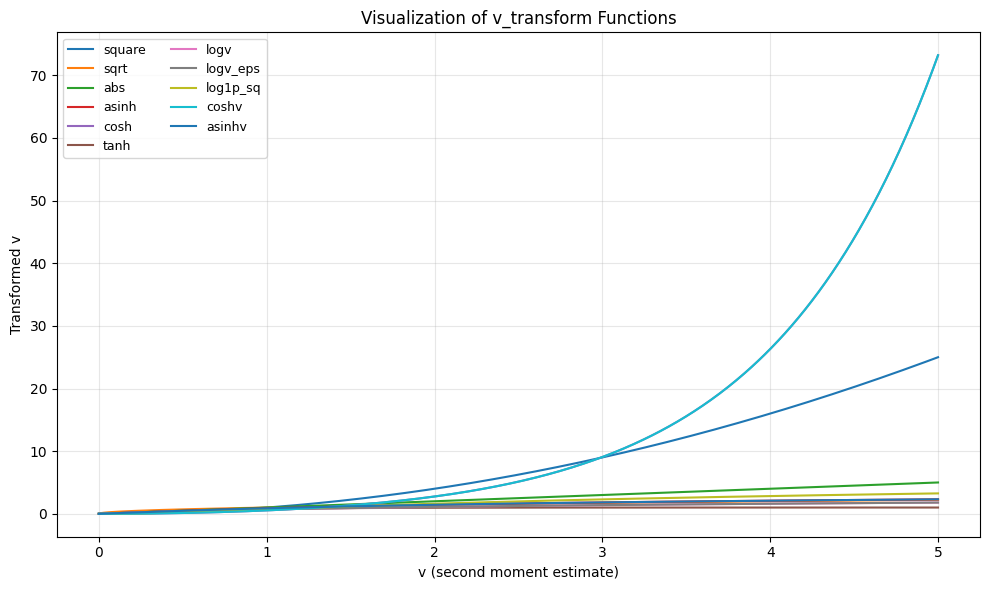

In [4]:
import torch
import matplotlib.pyplot as plt

# -----------------------------
# Define v_transform functions
# -----------------------------
def v_square(v):
    return v ** 2

def v_sqrt(v):
    return torch.sqrt(v + 1e-8)

def v_log1p_sq(v):
    return torch.log1p(v ** 2)

def v_abs(v):
    return torch.abs(v)

def v_asinh(v):
    return torch.asinh(v)

def v_cosh(v):
    return torch.cosh(v) -1

def v_tanh(v):
    return torch.tanh(v)

def v_logv(v):
    return torch.log1p(v)

def v_logv_eps(v, eps=1e-3):
    return torch.log1p(v + eps)

# Optional custom transforms used in your experiment
def v_coshv(v):
    return torch.cosh(v) -1
def v_asinhv(v):
    return torch.asinh(v)
def v_log1p_sq(v):
    return torch.log1p(v ** 2)

# -----------------------------
# Register them all in a dict
# -----------------------------
v_transforms = {
    "square": v_square,
    "sqrt": v_sqrt,
    "abs": v_abs,
    "asinh": v_asinh,
    "cosh": v_cosh,
    "tanh": v_tanh,
    "logv": v_logv,
    "logv_eps": v_logv_eps,
    "log1p_sq": v_log1p_sq,
    "coshv": v_coshv,
    "asinhv": v_asinhv,
}

# -----------------------------
# Input range for visualization
# -----------------------------
v = torch.linspace(0, 5, 500)

# -----------------------------
# Plot setup
# -----------------------------
plt.figure(figsize=(10, 6))
for name, fn in v_transforms.items():
    try:
        plt.plot(v.numpy(), fn(v).numpy(), label=name)
    except Exception as e:
        print(f"Skipping {name}: {e}")

plt.title("Visualization of v_transform Functions")
plt.xlabel("v (second moment estimate)")
plt.ylabel("Transformed v")
plt.grid(alpha=0.3)
plt.legend(ncol=2, fontsize=9)
plt.tight_layout()
plt.show()
